## Vincenzo Di Gennaro


#### City, University of London, Department of Computer Science


#### Summary:

For this project, the main challenges have been to create strategies to obtain acceptable results to classify quite complicated datasets like the SVHN (Google house number) and the Cohn-Kanade Emotions dataset. The main problematics I had to address were:

-	Limited computational capabilities (using a laptop to run the experiments)
-	For the SVHN, coming up with an appropriate augmentation (how many more samples to add and how to modify the original data samples), and dimensionality reduction strategy.
-	For the Emotion dataset, coping with very limited amount of data (just 359 training, 212 validation and 197 test pics – with multiple photos taken from the same person), with the complication that the people (whose photos were taken from) in the train, validation and test set were all different.

To partially compensate for the limited computational capabilities, I implemented two extra optimizers (RMSprop and Adam) which substantially helped to speed up the training of the networks.

Let’s start going through each task:


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from scipy.io import loadmat  # this is the SciPy module that loads mat-files
from datetime import datetime, date, time
%matplotlib inline

#### Useful functions to be used later for the tasks

In [3]:
import time
from IPython.display import display, clear_output
from scipy.special import expit
from scipy.stats import truncnorm

########## useful functions #############
def ReLU(x):
    return np.where(x>0.0,x,0.0)

def ReLU_derivation(x):
    return np.where(x>0.0,1.0,0.0)
    
def LeakyReLU(x, slope=0.01):
    return np.where(x>0.0, x, x*slope)

def LReLU_deriv(x, slope=0.01):
    return np.where(x>0.0,1.0,slope)
    
def softmax(x):
    exp_x = np.exp(x - x.max())
    return exp_x / exp_x.sum(axis=0, keepdims=True)
    
def sigmoid(x):
    return expit(x)

def sigmoid_der(x):
    return expit(x)*(1 - expit(x))

def truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)


def encode_labels(y, k):
    y = y.astype(int)
    onehot = np.zeros((k, y.shape[0]))
    for idx, val in enumerate(y):
        onehot[val, idx] = 1.0
    return onehot

from sklearn.metrics import confusion_matrix
def plot_conf_matrix(true_y, pred, normalized=True, labels=None):
    true_y = true_y.reshape(-1,1)
    pred = pred.reshape(-1,1)
    score = (pred==true_y).mean()
    cm = confusion_matrix(true_y, pred)
    if normalized:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    if labels!=None:
        cm = pd.DataFrame(cm, index=labels_emotions, columns=labels_emotions)
    plt.figure(figsize=(14,6))
    plt.subplot(1,2,1)
    sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'coolwarm');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    all_sample_title = 'Accuracy Score: {:.3f}'.format(score) 
    plt.title(all_sample_title, size = 15);
    plt.subplot(1,2,2)
    sns.heatmap(cm-np.diag(np.diag(cm)), annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'coolwarm');    
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    all_sample_title = 'Accuracy Score: {:.3f}'.format(score) 
    plt.title(all_sample_title, size = 15);


# functions to save and load pretrained model

def save_NN_model(model_instance):
    model_to_save = model_instance
    model = {'weights':{'Bs': model_to_save.Bs, 'Ws': model_to_save.Ws}, 'structure':model_to_save.size_h_layer, 
             'activation_h': model_to_save.activation_h, 'activation_o': model_to_save.activation_o,
             'regs':{'l2_reg':model_to_save.l2_reg, 'dropout':model_to_save.dropout}, 'optimizer': model_to_save.optimizer}
    model_name = 'mdl_'+str(model_to_save.size_h_layer)+'.npy'
    np.save(model_name, model) 


def load_NN_model(file_name, NN_class):
    model_imported = np.load(file_name,allow_pickle='TRUE').item()
    #set up same structure as the model saved:
    test_model = NN_class(size_h_layer=model_imported['structure'], 
                                activation_h=model_imported['activation_h'], activation_o=model_imported['activation_o'],
                                l_rate=0.0001)
    test_model.Bs = model_imported['weights']['Bs']
    test_model.Ws = model_imported['weights']['Ws']
    return test_model


##########################################

## Task 1. Implementing linear and ReLu layers 

For this task I create the first network structure with the following options:

- initialization of parameters using truncnorm function as suggested in the labs - later I will introduce also the "He" initialization and "Xavier" initialization
- ReLU / sigmoid activation and corresponding derivatives - I also implemented the LeakyReLU
- sigmoid / linear activation for the output layer
- optional bias
    


In [3]:

class vidigen_NN_task_1():
    
    def __init__(self, size_h_layer, l_rate, activation_h='ReLU', activation_o= 'sigmoid', bias=1, 
                 cval=0.25, plot_cost=True):
        """
        X has to have shape (#samples, #features)
        y has to have shape (#samples, 1)
        """
        #self.X = X
        #self.y = y
        self.size_h_layer = size_h_layer # (X_feat, h_struct, otput dim)        
        self.activation_h = activation_h
        self.activation_o = activation_o
        self.l_rate = l_rate
        self.bias = bias
        self.cval = cval
        self.plot_cost = plot_cost
        
        if self.activation_h == 'ReLU': 
            self.activation_function = ReLU
            self.derivative_func = ReLU_derivation
        if self.activation_h == 'LeakyReLU': 
            self.activation_function = LeakyReLU
            self.derivative_func = LReLU_deriv
        if self.activation_h == 'sigmoid': 
            self.activation_function = sigmoid    
            self.derivative_func = sigmoid_der
        
        self.initialize_params()
    
    #--------------------------------------------------------------------------------------
    def initialize_params(self):
        bias_node = 1 if self.bias else 0
        self.Ws = {}
        self.Bs = {}
        for l in range(1,len(self.size_h_layer)):            
            if self.bias:
                rad = 1 / np.sqrt(self.size_h_layer[l])
                N = truncated_normal(mean=0, sd=1, low=-rad, upp=rad)
                self.Ws['W_'+str(l)] = N.rvs((self.size_h_layer[l], self.size_h_layer[l-1]))
                self.Bs['b_'+str(l)] = N.rvs((self.size_h_layer[l],1))
            
            else:
                rad = 1 / np.sqrt(self.size_h_layer[l])
                N = truncated_normal(mean=0, sd=1, low=-rad, upp=rad)
                self.Ws['W_'+str(l)] = N.rvs((self.size_h_layer[l], 
                                       self.size_h_layer[l-1]))
                
    #--------------------------------------------------------------------------------------   
    def fwd_prop(self, input_vect):
        self.z = {}
        self.a = {}
        self.d = {}
        
        if self.bias: adjust_bias = 1
        else: adjust_bias = 0
            
        for l in range(1,len(self.size_h_layer)):
            
            if l == 1: # input layer                     
                self.z['z_'+str(l)] = self.Ws['W_'+str(l)].dot(input_vect.T) + self.Bs['b_'+str(l)]*adjust_bias 
                self.a['a_'+str(l)] = self.activation_function(self.z['z_'+str(l)] )                    
            elif (l > 1) and (l < len(self.size_h_layer)-1): 
                self.z['z_'+str(l)] = self.Ws['W_'+str(l)].dot(self.a['a_'+str(l-1)]) + self.Bs['b_'+str(l)]*adjust_bias 
                self.a['a_'+str(l)] = self.activation_function(self.z['z_'+str(l)])                
            elif l == len(self.size_h_layer)-1: 
                if self.activation_o == 'sigmoid':                    
                    self.z['z_'+str(l)] = self.Ws['W_'+str(l)].dot(self.a['a_'+str(l-1)]) + self.Bs['b_'+str(l)]*adjust_bias 
                    self.a['a_'+str(l)] = sigmoid(self.z['z_'+str(l)])
                if self.activation_o == 'softmax':
                    self.z['z_'+str(l)] = self.Ws['W_'+str(l)].dot(self.a['a_'+str(l-1)]) + self.Bs['b_'+str(l)]*adjust_bias 
                    self.a['a_'+str(l)] = softmax(self.z['z_'+str(l)])
                if self.activation_o == 'linear':
                    self.z['z_'+str(l)] = self.Ws['W_'+str(l)].dot(self.a['a_'+str(l-1)]) + self.Bs['b_'+str(l)]*adjust_bias 
                    self.a['a_'+str(l)] = self.z['z_'+str(l)]
                    
        return self.a['a_'+str(l)]
        
    #--------------------------------------------------------------------------------------
    def J_cost(self, y, output):
        m = y.shape[0]
        if self.activation_o == 'sigmoid':
            y_enc = y.T
        elif self.activation_o == 'softmax':
            y_enc = encode_labels(y, self.size_h_layer[-1])
        elif self.activation_o == 'linear':
            y_enc = y.T
                    
        if self.activation_o == 'sigmoid':
            cost_ = -(1/m) * (y_enc * (np.log(output)) + (1.0 - y_enc) * np.log(1.0 - output)) 
        if self.activation_o == 'softmax':
            cost_ = -(1/m) * (y_enc * (np.log(output)))
        if self.activation_o == 'linear':
            cost_ = 0.5 * (1/m) * np.square(y_enc - output)
        cost = np.sum(cost_)   
                           
        return cost
    
    #--------------------------------------------------------------------------------------            
    def back_prop(self, input_vect, y):
       
        assert(y.shape[1]==1)
        
        m = input_vect.shape[0]
        
        self.sigmas = {}
        self.dZ = {}
        self.dW = {}
        self.dB = {}
        
        if self.size_h_layer[-1]>1:
            y = encode_labels(y,self.size_h_layer[-1]) 
        else: y = y.T
            
        # last layer
        output = self.fwd_prop(input_vect)        
        l = len(self.size_h_layer)-1  
        
        #last layer error
        self.sigmas['sigma_'+str(l)] = output - y
        
        #last weights grads
        self.dW['dw_'+str(l)] = (1 / m) * np.dot(self.sigmas['sigma_'+str(l)], self.a['a_'+str(l-1)].T)             
        if self.bias:
            self.dB['db_'+str(l)] = (1 / m) * np.sum(self.sigmas['sigma_'+str(l)], axis=1, keepdims=True) 
                
        # hidden layer back prop
        for l in reversed(range(1, len(self.size_h_layer)-1)): #reverse loop through layer excluding the 1st
            
            self.sigmas['sigma_'+str(l)] = self.Ws['W_'+str(l+1)].T.dot(self.sigmas['sigma_'+str(l+1)]) * self.derivative_func(self.z['z_'+str(l)])                        
            
            #gradients
            if l == 1:                
                self.dW['dw_'+str(l)] = (1 / m) * np.dot(self.sigmas['sigma_'+str(l)], input_vect)
            else:
                self.dW['dw_'+str(l)] = (1 / m) * np.dot(self.sigmas['sigma_'+str(l)], self.a['a_'+str(l-1)].T)            
            if self.bias:
                self.dB['db_'+str(l)] = (1 / m) * np.sum(self.sigmas['sigma_'+str(l)], axis=1, keepdims=True)
            
    #--------------------------------------------------------------------------------------    
    def updates(self):
        for l in range(1,len(self.Ws)+1):
            self.Ws['W_'+str(l)] -= self.l_rate * self.dW['dw_'+str(l)] 
            self.Bs['b_'+str(l)] -= self.l_rate * self.dB['db_'+str(l)]
        
    #--------------------------------------------------------------------------------------
    def train_nn(self):
        pass
        

#### Import some dataset

In [4]:
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X = load_breast_cancer()['data']
y = load_breast_cancer()['target'].reshape(-1,1)

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.25, random_state=42)

# let's scale the dataset
sc = StandardScaler()
Xtrain = sc.fit_transform(Xtrain)
Xtest = sc.transform(Xtest)

print('nro_classes: ',len(np.unique(y)))
print('shape X: ', Xtrain.shape)

nro_classes:  2
shape X:  (426, 30)


let's set up a network with:

- just 1 hidden layer with 5 neurons, 
- ReLU activation for the hidden layers
- activation output "sigmoid" as there are 2 classes (0,1),
- sigmoid activations in the hidden layer 

In [17]:
task_1 = vidigen_NN_task_1(size_h_layer=(Xtrain.shape[1], 20,  1), 
                          activation_h='ReLU', activation_o='sigmoid',
                          l_rate=0.2, bias= 1,
                          plot_cost=False)

Let's do 1 forward pass on first 3 samples:

In [18]:
output = task_1.fwd_prop(Xtrain)
output.shape

(1, 426)

... and a back pass:

In [19]:
task_1.back_prop(Xtrain, ytrain)

In [20]:
task_1.Ws['W_1'].shape

(20, 30)

the gradients calculated in one backpropagation pass are:

- for the Ws

In [21]:
task_1.dW


{'dw_2': array([[ 0.01359825,  0.11597244, -0.20283537, -0.08272375,  0.00306797,
          0.06242705, -0.23069452,  0.16647662, -0.29151246,  0.19541395,
          0.11457025,  0.06352284,  0.15466434, -0.10650567,  0.02848199,
          0.12908815, -0.02315581,  0.30415831,  0.13430395, -0.08941438]]),
 'dw_1': array([[-4.70510539e-02, -1.82267458e-02, -4.94844734e-02,
         -4.17787358e-02, -3.46193951e-02, -6.06451600e-02,
         -6.06776331e-02, -6.11774478e-02, -4.05109900e-02,
         -1.47781539e-02, -3.07121118e-02,  1.38340368e-02,
         -3.34618774e-02, -2.84615400e-02,  1.75230377e-02,
         -3.79158717e-02, -3.31265028e-02, -3.91192417e-02,
         -4.14106099e-03, -1.57562356e-02, -4.81808073e-02,
         -2.45586305e-02, -5.12983871e-02, -4.10535004e-02,
         -3.37316086e-02, -5.84171178e-02, -6.05925672e-02,
         -6.48315303e-02, -4.63734297e-02, -3.99114475e-02],
        [ 1.59883916e-01,  1.09729407e-01,  1.68626180e-01,
          1.49326684e-01

- for the biases

In [22]:
task_1.dB

{'db_2': array([[-0.084223]]), 'db_1': array([[-0.00189386],
        [ 0.05344142],
        [ 0.16601635],
        [ 0.03956053],
        [-0.06762334],
        [-0.01529978],
        [-0.01169753],
        [-0.04262951],
        [ 0.07310196],
        [ 0.08653438],
        [ 0.02700141],
        [ 0.03877044],
        [ 0.02191854],
        [ 0.1831768 ],
        [ 0.00210893],
        [-0.10410914],
        [ 0.01232644],
        [ 0.15784901],
        [ 0.05198212],
        [ 0.01701828]])}

#### gradient cheching

let's do gradient checking to see if the gradients calculated in the backprop pass corrisponds to the actual
change in the COST due to small change in weights:

- let's pick up for example the first weight W_1[0,0]
- we calculate the cost before changing it
- we make a small chang in the weights
- recalculate the Cost
... and see if the Cost changed by the same amount indicated by the corresponding gradient dW_1[0,0]

In [23]:
print('W_1[0,0]: ', task_1.Ws['W_1'][0,0])

W_1[0,0]:  -0.20499598065343935


In [24]:
cost_before =  task_1.J_cost(ytrain,output)
print('Cost_before: ',cost_before)

Cost_before:  1.266637679117785


In [25]:
#let's change the weigth by a small amount
task_1.Ws['W_1'][0,0] += 0.001

#... and recalculate the Cost
output = task_1.fwd_prop(Xtrain)
cost_after = task_1.J_cost(ytrain,output)
print('Cost_after ',cost_after)

Cost_after  1.2665906297618736


In [26]:
# change cost/change weight
np.round((cost_after - cost_before)/0.001,4)

-0.047

In [27]:
np.round(task_1.dW['dw_1'][0,0],4)

-0.0471

as we can see the gradients are calculated correctly as the dCOST/dWeight is the same as the previously calculated gradient

Now let's make 10 forward back pass and see how the cost change (should reduce...)


In [28]:
for i in range(10):
    # forward pass
    output = task_1.fwd_prop(Xtrain)
    # backpropagation pass
    task_1.back_prop(Xtrain, ytrain)
    #update the weights
    task_1.updates()
    # re-calculate the cost
    print(task_1.J_cost(y=ytrain, output=output))

1.2665906297618736
0.3850941369178037
0.28059027712304396
0.23469586177362373
0.20779945931358046
0.19000830247227923
0.1773308647392225
0.16762624385491695
0.15982139170541906
0.1533550933089312


## Task 2. Implementing dropout

DROPOUT is a well know regularization technique where we go through each layer of the network and assign a probability to eliminate some neurons/nodes during the (training) forward and backward pass. This "confuses" the network as any nodes can't "rely" on all the previous activations as they can have randomly been switched of with an assigned probability therefore the network might be "reluctunt" to put too much weight on any particular features (at the input level)/preceding nodes (at hidden levels). This might force the training to spread out the weights more evenly which in turn as the effect of, not just shrinking the size of the weights (similar effect of L2 Regularization also implemented in the code), but, also to spread them uniformly around the network.

The hyperparameters to choose when apply dropout are obviously the probabilities to drop the neurons at every layer:

- here in the code the dropout option is dropout = (None, (0,0.25, 0.25)) where the first element of the tuple is to have dropout on(=1) or off(=None), and the second element is a tuple to assign the probability of dropping out the nodes at the various layers (here in the example I am assuming a structure with 2 hidden layers). Make sure to assign the probs (zero is a possibility ~= no dropout) to all the layers from the input to the last hidden layer. 

A reasonable starting dropout probabilty for a given layer is between 0.25 and 0.5 eventually assigning heavier probability on bigger (#neurons) layers. Later in the coursework where I will train a model to predict a nasty version of the MNIST, dropout comes very handy as the features are quite a lot and sparse which is the typical data where this technique works at its best.

DROPOUT has a problem: let's say that in a particular layer (for example layer 3) we have 100 neurons and we are using a dropout probability of 0.25. This means that we have 75% chance to keep the neurons and (obv) 25% chance to eliminate them. This, in turn, means that the Zs at layer 4 (linear combinations of the W4 and a3 + bias) have a "likely" reduced value coming in (from the a3). In order to compensate for this problem we perfom "INVERTED" dropout which is done by dividing the activations and the gradients by (1 - dropout_probs). This will increase the activations proportionally to the corresponding dropout probability: the higher the chance to be swithed off, the bigger is the adjustment.

- inverted dropout adjustments are implemented in line 75 and 84 of the code.

At testing phase the dropout needs to be switched off because when we make prediction we don't really want to add unnecessary noise (due to the randomness in dropout).

In [29]:

class vidigen_NN_task_2():
    
    def __init__(self, size_h_layer, l_rate, activation_h='ReLU', activation_o= 'sigmoid', l2_reg=None,
                 dropout = (None, (0,0.25)), bias=1, 
                 cval=0.2, plot_cost= False):
        """
        X has to have shape (#samples, #features)
        y has to have shape (#samples, 1)
        """
        self.size_h_layer = size_h_layer     
        self.activation_h = activation_h
        self.activation_o = activation_o
        self.l_rate = l_rate
        self.l2_reg = l2_reg
        self.dropout = dropout
        self.bias = bias
        self.cval = cval
        self.plot_cost = plot_cost
        
        if self.activation_h == 'ReLU': 
            self.activation_function = ReLU
            self.derivative_func = ReLU_derivation
        if self.activation_h == 'LeakyReLU': 
            self.activation_function = LeakyReLU
            self.derivative_func = LReLU_deriv
        if self.activation_h == 'sigmoid': 
            self.activation_function = sigmoid    
            self.derivative_func = sigmoid_der
        
        self.initialize_params()
        
    #--------------------------------------------------------------------------------------
    def initialize_params(self):
        bias_node = 1 if self.bias else 0
        self.Ws = {}
        self.Bs = {}
        for l in range(1,len(self.size_h_layer)):            
            if self.bias:
                rad = 1 / np.sqrt(self.size_h_layer[l])
                N = truncated_normal(mean=0, sd=1, low=-rad, upp=rad)
                self.Ws['W_'+str(l)] = N.rvs((self.size_h_layer[l], self.size_h_layer[l-1]))
                self.Bs['b_'+str(l)] = N.rvs((self.size_h_layer[l],1))
            
            else:
                rad = 1 / np.sqrt(self.size_h_layer[l])
                N = truncated_normal(mean=0, sd=1, low=-rad, upp=rad)
                self.Ws['W_'+str(l)] = N.rvs((self.size_h_layer[l], 
                                       self.size_h_layer[l-1]))
   
    #--------------------------------------------------------------------------------------
    def fwd_prop(self, input_vect, dropout_on=1):
        self.z = {}
        self.a = {}
        self.d = {}
        
        if self.bias: adjust_bias = 1
        else: adjust_bias = 0
            
        for l in range(1,len(self.size_h_layer)):
            
            if l == 1: # input layer 
                    
                self.z['z_'+str(l)] = self.Ws['W_'+str(l)].dot(input_vect.T) + self.Bs['b_'+str(l)]*adjust_bias 
                self.a['a_'+str(l)] = self.activation_function(self.z['z_'+str(l)] )    
                if self.dropout[0] and dropout_on:
                    d = np.random.rand(*self.a['a_'+str(l)].shape)
                    self.d['d_'+str(l)] = 1 * (d > self.dropout[1][l])
                    self.a['a_'+str(l)] *= self.d['d_'+str(l)]
                    self.a['a_'+str(l)] /= (1-self.dropout[1][l])
                    
            elif (l > 1) and (l < len(self.size_h_layer)-1): 
                self.z['z_'+str(l)] = self.Ws['W_'+str(l)].dot(self.a['a_'+str(l-1)]) + self.Bs['b_'+str(l)]*adjust_bias 
                self.a['a_'+str(l)] = self.activation_function(self.z['z_'+str(l)])
                if self.dropout[0] and dropout_on:
                    d = np.random.rand(*self.a['a_'+str(l)].shape)
                    self.d['d_'+str(l)] = 1 * (d > self.dropout[1][l])
                    self.a['a_'+str(l)] *= self.d['d_'+str(l)]
                    self.a['a_'+str(l)] /= (1-self.dropout[1][l])
                    
            elif l == len(self.size_h_layer)-1: 
                if self.activation_o == 'sigmoid':                    
                    self.z['z_'+str(l)] = self.Ws['W_'+str(l)].dot(self.a['a_'+str(l-1)]) + self.Bs['b_'+str(l)]*adjust_bias 
                    self.a['a_'+str(l)] = sigmoid(self.z['z_'+str(l)])
                if self.activation_o == 'softmax':
                    self.z['z_'+str(l)] = self.Ws['W_'+str(l)].dot(self.a['a_'+str(l-1)]) + self.Bs['b_'+str(l)]*adjust_bias 
                    self.a['a_'+str(l)] = softmax(self.z['z_'+str(l)])
                if self.activation_o == 'linear':
                    self.z['z_'+str(l)] = self.Ws['W_'+str(l)].dot(self.a['a_'+str(l-1)]) + self.Bs['b_'+str(l)]*adjust_bias 
                    self.a['a_'+str(l)] = self.z['z_'+str(l)]
                    
        return self.a['a_'+str(l)]
    
    #--------------------------------------------------------------------------------------
    def J_cost(self, y, output):
        m = y.shape[0]
        if self.activation_o == 'sigmoid':
            y_enc = y.T
        elif self.activation_o == 'softmax':
            #y.shape = (#samples, class)
            y_enc = encode_labels(y, self.size_h_layer[-1])
        if self.l2_reg:
            reg = 0
            for k in self.Ws.keys():
                reg = reg + (self.Ws[k]*self.Ws[k]).sum()
            reg = (1/m) * self.l2_reg/2 * reg
        else: reg = 0
            
        if self.activation_o == 'sigmoid':
            cost_ = -(1/m) * (y_enc * (np.log(output)) + (1.0 - y_enc) * np.log(1.0 - output)) + reg
        if self.activation_o == 'softmax':
            cost_ = -(1/m) * (y_enc * (np.log(output))) + reg
        if self.activation_o == 'linear':
            cost_ = 0.5 * (1/m) * np.square(y_enc - output) + reg
        cost = np.sum(cost_)   
                           
        return cost
    
    #--------------------------------------------------------------------------------------
    def back_prop(self, input_vect, y):
       
        assert(y.shape[1]==1)
        
        m = input_vect.shape[0]
        
        self.sigmas = {}
        self.dZ = {}
        self.dW = {}
        self.dB = {}
        
        if self.size_h_layer[-1]>1:
            y = encode_labels(y,self.size_h_layer[-1]) 
        else: y = y.T
            
        # last layer
        output = self.fwd_prop(input_vect)        
        l = len(self.size_h_layer)-1  
        
        #last layer error
        self.sigmas['sigma_'+str(l)] = output - y
        if self.l2_reg:
            add_reg = self.l2_reg/m * self.Ws['W_'+str(l)]
        else: add_reg = 0
            
        #last weights grads
        self.dW['dw_'+str(l)] = (1 / m) * np.dot(self.sigmas['sigma_'+str(l)], self.a['a_'+str(l-1)].T) + add_reg            
        
        if self.bias:
            self.dB['db_'+str(l)] = (1 / m) * np.sum(self.sigmas['sigma_'+str(l)], axis=1, keepdims=True) 
                
        # hidden layer back prop
        for l in reversed(range(1, len(self.size_h_layer)-1)): #reverse loop through layer excluding the 1st
            if self.dropout[0]:
                drop_adj = self.Ws['W_'+str(l+1)].T.dot(self.sigmas['sigma_'+str(l+1)]) * self.d['d_'+str(l)]
                #inverted dropout adjustments
                drop_adj /= (1-self.dropout[1][l])
                self.sigmas['sigma_'+str(l)] = drop_adj * self.derivative_func(self.z['z_'+str(l)])
            else:
                self.sigmas['sigma_'+str(l)] = self.Ws['W_'+str(l+1)].T.dot(self.sigmas['sigma_'+str(l+1)]) * self.derivative_func(self.z['z_'+str(l)])                        
            if self.l2_reg:
                add_reg = self.l2_reg/m * self.Ws['W_'+str(l)]
            else: add_reg = 0 
            #gradients
            if l == 1:                
                self.dW['dw_'+str(l)] = (1 / m) * np.dot(self.sigmas['sigma_'+str(l)], input_vect) + add_reg
            else:
                self.dW['dw_'+str(l)] = (1 / m) * np.dot(self.sigmas['sigma_'+str(l)], self.a['a_'+str(l-1)].T) + add_reg
            
            if self.bias:
                self.dB['db_'+str(l)] = (1 / m) * np.sum(self.sigmas['sigma_'+str(l)], axis=1, keepdims=True)
            
    #--------------------------------------------------------------------------------------        
    def updates(self):
        for l in range(1,len(self.Ws)+1):
            self.Ws['W_'+str(l)] -= self.l_rate * self.dW['dw_'+str(l)] 
            self.Bs['b_'+str(l)] -= self.l_rate * self.dB['db_'+str(l)]
        
    
    
        
        

In [30]:
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X = load_breast_cancer()['data']
y = load_breast_cancer()['target'].reshape(-1,1)

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.25, random_state=42)

# let's scale the dataset
sc = StandardScaler()
Xtrain = sc.fit_transform(Xtrain)
Xtest = sc.transform(Xtest)

print('nro_classes: ',len(np.unique(y)))
print('shape X: ', Xtrain.shape)

nro_classes:  2
shape X:  (426, 30)


To illustrate the effect of DROPOUT on the network I set up the following structure:

- 5 hidden layers with 7,8,7,8,7 neurons respectively
- sigmoid activation (so that we just see the effect of a neuron switched off by dropout (and not by ReLU)
- 30% dropout to each layer ==> dropout=(1, (0, 0.3, 0.3, 0.3))

In [31]:
task_2 = vidigen_NN_task_2(size_h_layer=(Xtrain.shape[1], 7, 8, 7, 8, 7, 1), 
                          activation_h='sigmoid', activation_o='sigmoid',
                          l_rate=0.1, bias= 1,
                          l2_reg= None, dropout=(1, (0, 0.3, 0.4, 0.3, 0.4, 0.4)),
                          plot_cost=False)

In [32]:
task_2.fwd_prop(Xtrain).shape

(1, 426)

Here below I am plotting the hidden layers of the network defined above

Text(0.5, 1.0, 'Network Hidden Layers')

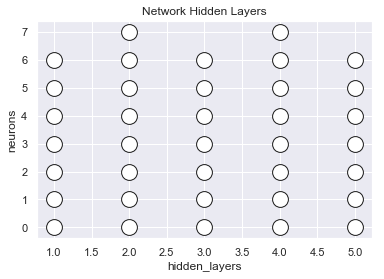

In [33]:
network = []
for l in range(1,len(task_2.size_h_layer)-1):
    network.append(np.vstack([np.ones(task_2.size_h_layer[l])*l, np.arange(task_2.size_h_layer[l])*1]))
full_structure = network[0]
for i in range(1,len(task_2.size_h_layer)-2):
    full_structure = np.hstack([full_structure,network[i]])
full_structure = full_structure.T    
plt.scatter(full_structure[:,0], full_structure[:,1], s=250,c='w', edgecolors='k')
plt.xlabel('hidden_layers')
plt.ylabel('neurons')
plt.title('Network Hidden Layers')

Below I show the effect of dropout running 10 epochs to see which nodes get switched off... the black nodes are the dropped ones

Obviuously also the corrisponding gradients are switched off on the back pass

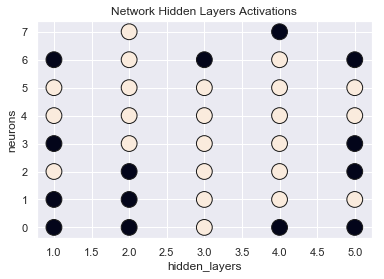

In [34]:
import time
from IPython.display import clear_output
for i in range(10):    
    clear_output()
    # forward pass with dropout
    output = task_2.fwd_prop(Xtrain[:1], dropout_on=1)
    # backpropagation pass with (previous) dropout
    task_2.back_prop(Xtrain[:1], ytrain[:1])
    #update the weights
    dropped_activations = []
    for k in task_2.d.keys():
        dropped_activations.append(task_2.d[k])
    dropped_activations = np.concatenate(dropped_activations).ravel() 

    plt.scatter(full_structure[:,0], full_structure[:,1], s=250,c=dropped_activations, edgecolors='k')
    plt.title('Network Hidden Layers Activations')
    plt.xlabel('hidden_layers')
    plt.ylabel('neurons')
    plt.show()    
    time.sleep(1)
    

On the testing phase I included an option in fwd_pass to switch the dropout off: self.fwd_prop(input_vect, dropout_on= 0)

At testing phase, let's say I want to predict the first 3 samples of the Xtest, we need to switch dropout off: ==> dropout_on=0

In [23]:
np.where(task_2.fwd_prop(input_vect=Xtest[:3], dropout_on=0) > 0.5, 1, 0)

array([[0, 0, 0]])

## Task 3. Implementing softmax classifier

SOFTMAX is usually used when we need to classify an output with multiple outcomes (more than 2 classes). It's a useful function especially for its probability interpretation (similar to the sigmoid but with multiple classes)

I implemented the SOFTMAX with the function below (typical formulation of the softmax)

In [24]:
def softmax(x):
    exp_x = np.exp(x)
    return exp_x / exp_x.sum(axis=0, keepdims=True)

Now let's highlight some problems of the SOFTMAX function: 

let's assume that due to an "exploding gradient" situation in the network the Zs arriving in the output layer (on which we need to apply the softmax function to get the probabilities for the classification task) are huge:

In [25]:
big_Zs = np.array([1000,1150,-2130]).T
#apply softmax function
softmax(big_Zs)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


array([nan, nan,  0.])

As we can see above that creates problems applying the "normal" softmax.

A way to overcome this numerical instability is to subtract a fix value from the elements before applying the exp: typically the max of the elements is the values subtracted:



In [3]:
def softmax(x):
    exp_x = np.exp(x - x.max())
    return exp_x / exp_x.sum(axis=0, keepdims=True)

In [27]:
print(softmax(big_Zs))


[7.17509597e-66 1.00000000e+00 0.00000000e+00]


That's better...


Regarding the COST f the SOFTMAX, I calculated in the following way
     
     cost_ = -(1/m) * (y_enc * (np.log(output))) + reg
     
Obviously in case of multiple classes classification, the output of the network will have the shape (#classes, #samples) which will be compared, to calculate the Cost, with the one hot encoded version of the ys.

I wrote the function below to execute one hot encoding for the targets where y are the targets and k are the number of classes to classify:

In [4]:
def encode_labels(y, k):
    y = y.astype(int)
    onehot = np.zeros((k, y.shape[0]))
    for idx, val in enumerate(y):
        onehot[val, idx] = 1.0
    return onehot

In [29]:

class vidigen_NN_task_3():
    
    def __init__(self, size_h_layer, l_rate, activation_h='ReLU', activation_o= 'sigmoid', l2_reg=None,
                 dropout = (None, (0,0.25)), bias=1, 
                 cval=0.2, plot_cost= False):
        
        self.size_h_layer = size_h_layer # (X_feat, h_struct, otput dim)        
        self.activation_h = activation_h
        self.activation_o = activation_o
        self.l_rate = l_rate
        self.l2_reg = l2_reg
        self.dropout = dropout
        self.bias = bias
        self.cval = cval
        self.plot_cost = plot_cost
        
        if self.activation_h == 'ReLU': 
            self.activation_function = ReLU
            self.derivative_func = ReLU_derivation
        if self.activation_h == 'LeakyReLU': 
            self.activation_function = LeakyReLU
            self.derivative_func = LReLU_deriv
        if self.activation_h == 'sigmoid': 
            self.activation_function = sigmoid    
            self.derivative_func = sigmoid_der
        
        self.initialize_params()
        
    #--------------------------------------------------------------------------------------
    def initialize_params(self):
        bias_node = 1 if self.bias else 0
        self.Ws = {}
        self.Bs = {}
        for l in range(1,len(self.size_h_layer)):            
            if self.bias:
                rad = 1 / np.sqrt(self.size_h_layer[l])
                N = truncated_normal(mean=0, sd=1, low=-rad, upp=rad)
                self.Ws['W_'+str(l)] = N.rvs((self.size_h_layer[l], self.size_h_layer[l-1]))
                self.Bs['b_'+str(l)] = N.rvs((self.size_h_layer[l],1))
            
            else:
                rad = 1 / np.sqrt(self.size_h_layer[l])
                N = truncated_normal(mean=0, sd=1, low=-rad, upp=rad)
                self.Ws['W_'+str(l)] = N.rvs((self.size_h_layer[l], 
                                       self.size_h_layer[l-1]))
    #--------------------------------------------------------------------------------------
    def fwd_prop(self, input_vect, dropout_on=1):
        self.z = {}
        self.a = {}
        self.d = {}
        
        if self.bias: adjust_bias = 1
        else: adjust_bias = 0
            
        for l in range(1,len(self.size_h_layer)):
            
            if l == 1: # input layer 
                    
                self.z['z_'+str(l)] = self.Ws['W_'+str(l)].dot(input_vect.T) + self.Bs['b_'+str(l)]*adjust_bias 
                self.a['a_'+str(l)] = self.activation_function(self.z['z_'+str(l)] )    
                if self.dropout[0] and dropout_on:
                    d = np.random.rand(*self.a['a_'+str(l)].shape)
                    self.d['d_'+str(l)] = 1 * (d > self.dropout[1][l])
                    self.a['a_'+str(l)] *= self.d['d_'+str(l)]
                    self.a['a_'+str(l)] /= (1-self.dropout[1][l])
                    
            elif (l > 1) and (l < len(self.size_h_layer)-1): 
                self.z['z_'+str(l)] = self.Ws['W_'+str(l)].dot(self.a['a_'+str(l-1)]) + self.Bs['b_'+str(l)]*adjust_bias 
                self.a['a_'+str(l)] = self.activation_function(self.z['z_'+str(l)])
                if self.dropout[0] and dropout_on:
                    d = np.random.rand(*self.a['a_'+str(l)].shape)
                    self.d['d_'+str(l)] = 1 * (d > self.dropout[1][l])
                    self.a['a_'+str(l)] *= self.d['d_'+str(l)]
                    self.a['a_'+str(l)] /= (1-self.dropout[1][l])
                    
            elif l == len(self.size_h_layer)-1: 
                if self.activation_o == 'sigmoid':                    
                    self.z['z_'+str(l)] = self.Ws['W_'+str(l)].dot(self.a['a_'+str(l-1)]) + self.Bs['b_'+str(l)]*adjust_bias 
                    self.a['a_'+str(l)] = sigmoid(self.z['z_'+str(l)])
                if self.activation_o == 'softmax':
                    self.z['z_'+str(l)] = self.Ws['W_'+str(l)].dot(self.a['a_'+str(l-1)]) + self.Bs['b_'+str(l)]*adjust_bias 
                    self.a['a_'+str(l)] = softmax(self.z['z_'+str(l)])
                if self.activation_o == 'linear':
                    self.z['z_'+str(l)] = self.Ws['W_'+str(l)].dot(self.a['a_'+str(l-1)]) + self.Bs['b_'+str(l)]*adjust_bias 
                    self.a['a_'+str(l)] = self.z['z_'+str(l)]
                    
        return self.a['a_'+str(l)]
 
    #--------------------------------------------------------------------------------------
    def J_cost(self, y, output):
        m = y.shape[0]
        if self.activation_o == 'sigmoid':
            y_enc = y.T
        elif self.activation_o == 'softmax':
            #y.shape = (#samples, class)
            y_enc = encode_labels(y, self.size_h_layer[-1])
        if self.l2_reg:
            reg = 0
            for k in self.Ws.keys():
                reg = reg + (self.Ws[k]*self.Ws[k]).sum()
            reg = (1/m) * self.l2_reg/2 * reg
        else: reg = 0
            
        if self.activation_o == 'sigmoid':
            cost_ = -(1/m) * (y_enc * (np.log(output)) + (1.0 - y_enc) * np.log(1.0 - output)) + reg
        if self.activation_o == 'softmax':
            cost_ = -(1/m) * (y_enc * (np.log(output))) + reg
        if self.activation_o == 'linear':
            cost_ = 0.5 * (1/m) * np.square(y_enc - output) + reg
        cost = np.sum(cost_)   
                           
        return cost
    
   
    #--------------------------------------------------------------------------------------            
    def back_prop(self, input_vect, y):
       
        assert(y.shape[1]==1)
        
        m = input_vect.shape[0]
        
        self.sigmas = {}
        self.dZ = {}
        self.dW = {}
        self.dB = {}
        
        if self.size_h_layer[-1]>1:
            y = encode_labels(y,self.size_h_layer[-1]) 
        else: y = y.T
            
        # last layer
        output = self.fwd_prop(input_vect)        
        l = len(self.size_h_layer)-1  
        
        #last layer error
        self.sigmas['sigma_'+str(l)] = output - y
        if self.l2_reg:
            add_reg = self.l2_reg/m * self.Ws['W_'+str(l)]
        else: add_reg = 0
            
        #last weights grads
        self.dW['dw_'+str(l)] = (1 / m) * np.dot(self.sigmas['sigma_'+str(l)], self.a['a_'+str(l-1)].T) + add_reg            
        
        if self.bias:
            self.dB['db_'+str(l)] = (1 / m) * np.sum(self.sigmas['sigma_'+str(l)], axis=1, keepdims=True) 
                
        # hidden layer back prop
        for l in reversed(range(1, len(self.size_h_layer)-1)): #reverse loop through layer excluding the 1st
            if self.dropout[0]:
                drop_adj = self.Ws['W_'+str(l+1)].T.dot(self.sigmas['sigma_'+str(l+1)]) * self.d['d_'+str(l)]
                #inverted dropout adjustments
                drop_adj /= (1-self.dropout[1][l])
                self.sigmas['sigma_'+str(l)] = drop_adj * self.derivative_func(self.z['z_'+str(l)])
            else:
                self.sigmas['sigma_'+str(l)] = self.Ws['W_'+str(l+1)].T.dot(self.sigmas['sigma_'+str(l+1)]) * self.derivative_func(self.z['z_'+str(l)])                        
            if self.l2_reg:
                add_reg = self.l2_reg/m * self.Ws['W_'+str(l)]
            else: add_reg = 0 
            #gradients
            if l == 1:                
                self.dW['dw_'+str(l)] = (1 / m) * np.dot(self.sigmas['sigma_'+str(l)], input_vect) + add_reg
            else:
                self.dW['dw_'+str(l)] = (1 / m) * np.dot(self.sigmas['sigma_'+str(l)], self.a['a_'+str(l-1)].T) + add_reg
            
            if self.bias:
                self.dB['db_'+str(l)] = (1 / m) * np.sum(self.sigmas['sigma_'+str(l)], axis=1, keepdims=True)
            
    #--------------------------------------------------------------------------------------        
    def updates(self):
        for l in range(1,len(self.Ws)+1):
            self.Ws['W_'+str(l)] -= self.l_rate * self.dW['dw_'+str(l)] 
            self.Bs['b_'+str(l)] -= self.l_rate * self.dB['db_'+str(l)]
        
    
    
        
        

Let's run it on the IRIS dataset:

In [30]:
from sklearn.datasets import load_iris
X = load_iris()['data']
y = load_iris()['target'].reshape(-1,1)

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.25, random_state=42)

# let's scale the dataset
sc = StandardScaler()
Xtrain = sc.fit_transform(Xtrain)
Xtest = sc.transform(Xtest)

print('nro_classes: ',len(np.unique(y)))
print('shape X: ', Xtrain.shape)

nro_classes:  3
shape X:  (112, 4)


Let's set up a network with:

- 1 hidden layer with 20 nodes
- dropout probs = 0.3
- activation for hidden layer = ReLU
- activation for output layer = softmax

In [31]:
task_3 = vidigen_NN_task_3(size_h_layer=(Xtrain.shape[1], 20, len(np.unique(ytrain))), 
                          activation_h='ReLU', activation_o='softmax',
                          l_rate=0.1, bias= 1,
                          l2_reg= None, dropout=(1, (0, 0.3)),
                          plot_cost=False)

Let's have a fwd pass to see the shape of the output when using softmax:

as we can see below, running with 5 samples the shape of the output is (3,5) as 3 are the # of classes (in the iris dataset) and 5 are the samples passed.

In [32]:
task_3.fwd_prop(input_vect=Xtrain[:5], dropout_on=1 )

array([[0.33814331, 0.41481355, 0.26492474, 0.25726417, 0.24747743],
       [0.41540072, 0.32119995, 0.32502102, 0.37506924, 0.37820798],
       [0.24645596, 0.2639865 , 0.41005424, 0.36766659, 0.37431458]])

...and as we can see below, the probability of the classes sum up to 1

In [33]:
task_3.fwd_prop(input_vect=Xtrain[:5], dropout_on=1 ).sum(axis=0)

array([1., 1., 1., 1., 1.])

## Task 4. Implementing fully-connected NN

Now we are ready to implement the full code:

The syntax of my code is the following:
    


In [5]:



class vidigen_NN_task_4():
    
    def __init__(self, size_h_layer, l_rate, l_decay=None, activation_h='ReLU', activation_o= 'sigmoid', 
                 l2_reg=None, dropout = (None, (0,0.25)), bias=1, 
                 plot_cost= False, plots=1, print_=1):
        """
        X has to have shape (#samples, #features)
        y has to have shape (#samples, 1)
        """
        #self.X = X
        #self.y = y
        self.size_h_layer = size_h_layer # (X_feat, h_struct, otput dim)        
        self.activation_h = activation_h
        self.activation_o = activation_o
        self.l_rate = l_rate
        self.l2_reg = l2_reg
        self.dropout = dropout
        self.bias = bias
        self.l_decay = l_decay
        self.plot_cost = plot_cost
        self.plots = plots
        self.print_ = print_
        
        if self.activation_h == 'ReLU': 
            self.activation_function = ReLU
            self.derivative_func = ReLU_derivation
        if self.activation_h == 'LeakyReLU': 
            self.activation_function = LeakyReLU
            self.derivative_func = LReLU_deriv
        if self.activation_h == 'sigmoid': 
            self.activation_function = sigmoid    
            self.derivative_func = sigmoid_der
        
        self.initialize_params()
        
        if self.l_decay:
            self.initial_l_rate = self.l_rate
    #--------------------------------------------------------------------------------------
    def initialize_params(self):
        bias_node = 1 if self.bias else 0
        self.Ws = {}
        self.Bs = {}
        for l in range(1,len(self.size_h_layer)):            
            if self.bias:
                rad = 1 / np.sqrt(self.size_h_layer[l])
                N = truncated_normal(mean=0, sd=1, low=-rad, upp=rad)
                self.Ws['W_'+str(l)] = N.rvs((self.size_h_layer[l], self.size_h_layer[l-1]))
                self.Bs['b_'+str(l)] = N.rvs((self.size_h_layer[l],1))
            
            else:
                rad = 1 / np.sqrt(self.size_h_layer[l])
                N = truncated_normal(mean=0, sd=1, low=-rad, upp=rad)
                self.Ws['W_'+str(l)] = N.rvs((self.size_h_layer[l], 
                                       self.size_h_layer[l-1]))
                
    #--------------------------------------------------------------------------------------
    def fwd_prop(self, input_vect, dropout_on=1):
        self.z = {}
        self.a = {}
        self.d = {}
        
        if self.bias: adjust_bias = 1
        else: adjust_bias = 0
            
        for l in range(1,len(self.size_h_layer)):
            
            if l == 1: # input layer 
                    
                self.z['z_'+str(l)] = self.Ws['W_'+str(l)].dot(input_vect.T) + self.Bs['b_'+str(l)]*adjust_bias 
                self.a['a_'+str(l)] = self.activation_function(self.z['z_'+str(l)] )    
                if self.dropout[0] and dropout_on:
                    d = np.random.rand(*self.a['a_'+str(l)].shape)
                    self.d['d_'+str(l)] = 1 * (d > self.dropout[1][l])
                    self.a['a_'+str(l)] *= self.d['d_'+str(l)]
                    self.a['a_'+str(l)] /= (1-self.dropout[1][l])
                    
            elif (l > 1) and (l < len(self.size_h_layer)-1): 
                self.z['z_'+str(l)] = self.Ws['W_'+str(l)].dot(self.a['a_'+str(l-1)]) + self.Bs['b_'+str(l)]*adjust_bias 
                self.a['a_'+str(l)] = self.activation_function(self.z['z_'+str(l)])
                if self.dropout[0] and dropout_on:
                    d = np.random.rand(*self.a['a_'+str(l)].shape)
                    self.d['d_'+str(l)] = 1 * (d > self.dropout[1][l])
                    self.a['a_'+str(l)] *= self.d['d_'+str(l)]
                    self.a['a_'+str(l)] /= (1-self.dropout[1][l])
                    
            elif l == len(self.size_h_layer)-1: 
                if self.activation_o == 'sigmoid':                    
                    self.z['z_'+str(l)] = self.Ws['W_'+str(l)].dot(self.a['a_'+str(l-1)]) + self.Bs['b_'+str(l)]*adjust_bias 
                    self.a['a_'+str(l)] = sigmoid(self.z['z_'+str(l)])
                if self.activation_o == 'softmax':
                    self.z['z_'+str(l)] = self.Ws['W_'+str(l)].dot(self.a['a_'+str(l-1)]) + self.Bs['b_'+str(l)]*adjust_bias 
                    self.a['a_'+str(l)] = softmax(self.z['z_'+str(l)])
                if self.activation_o == 'linear':
                    self.z['z_'+str(l)] = self.Ws['W_'+str(l)].dot(self.a['a_'+str(l-1)]) + self.Bs['b_'+str(l)]*adjust_bias 
                    self.a['a_'+str(l)] = self.z['z_'+str(l)]
                    
        return self.a['a_'+str(l)]
    
    #--------------------------------------------------------------------------------------    
    def predict(self,X):
        pred = self.fwd_prop(X, dropout_on=0)
        if self.activation_o=='softmax':
            pred = np.argmax(pred, axis=0).reshape(-1,1)
        if self.activation_o=='sigmoid':
            pred = np.where(pred>0.5,1,0).reshape(-1,1)
        if self.activation_o=='linear':
            pred = pred.reshape(-1,1)
        else:
            pred = pred
        return pred
        
    #--------------------------------------------------------------------------------------
    def J_cost(self, y, output):
        m = y.shape[0]
        if self.activation_o == 'sigmoid':
            y_enc = y.T
        elif self.activation_o == 'softmax':
            #y.shape = (#samples, class)
            y_enc = encode_labels(y, self.size_h_layer[-1])
        elif self.activation_o == 'linear':
            y_enc = y.T
            
        if self.l2_reg:
            reg = 0
            for k in self.Ws.keys():
                reg = reg + (self.Ws[k]*self.Ws[k]).sum()
            reg = (1/m) * self.l2_reg/2 * reg
        else: reg = 0
            
        if self.activation_o == 'sigmoid':
            cost_ = -(1/m) * (y_enc * (np.log(output)) + (1.0 - y_enc) * np.log(1.0 - output))# + reg
        if self.activation_o == 'softmax':
            cost_ = -(1/m) * (y_enc * (np.log(output))) #+ reg
        if self.activation_o == 'linear':
            cost_ = 0.5 * (1/m) * np.square(y_enc - output) #+ reg
        cost = np.sum(cost_)   
                           
        return cost
    
    #--------------------------------------------------------------------------------------
    def back_prop(self, input_vect, y):
       
        assert(y.shape[1]==1)
        
        m = input_vect.shape[0]
        
        self.sigmas = {}
        self.dZ = {}
        self.dW = {}
        self.dB = {}
        
        if self.size_h_layer[-1]>1:
            y = encode_labels(y,self.size_h_layer[-1]) 
        else: y = y.T
            
        # last layer
        output = self.fwd_prop(input_vect)        
        l = len(self.size_h_layer)-1  
        
        #last layer error
        self.sigmas['sigma_'+str(l)] = output - y
        if self.l2_reg:
            add_reg = self.l2_reg/m * self.Ws['W_'+str(l)]
        else: add_reg = 0
            
        #last weights grads
        self.dW['dw_'+str(l)] = (1 / m) * np.dot(self.sigmas['sigma_'+str(l)], self.a['a_'+str(l-1)].T) + add_reg            
        
        if self.bias:
            self.dB['db_'+str(l)] = (1 / m) * np.sum(self.sigmas['sigma_'+str(l)], axis=1, keepdims=True) 
                
        # hidden layer back prop
        for l in reversed(range(1, len(self.size_h_layer)-1)): #reverse loop through layer excluding the 1st
            if self.dropout[0]:
                drop_adj = self.Ws['W_'+str(l+1)].T.dot(self.sigmas['sigma_'+str(l+1)]) * self.d['d_'+str(l)]
                #inverted dropout adjustments
                drop_adj /= (1-self.dropout[1][l])
                self.sigmas['sigma_'+str(l)] = drop_adj * self.derivative_func(self.z['z_'+str(l)])
            else:
                self.sigmas['sigma_'+str(l)] = self.Ws['W_'+str(l+1)].T.dot(self.sigmas['sigma_'+str(l+1)]) * self.derivative_func(self.z['z_'+str(l)])                        
            if self.l2_reg:
                add_reg = self.l2_reg/m * self.Ws['W_'+str(l)]
            else: add_reg = 0 
            #gradients
            if l == 1:                
                self.dW['dw_'+str(l)] = (1 / m) * np.dot(self.sigmas['sigma_'+str(l)], input_vect) + add_reg
            else:
                self.dW['dw_'+str(l)] = (1 / m) * np.dot(self.sigmas['sigma_'+str(l)], self.a['a_'+str(l-1)].T) + add_reg
            
            if self.bias:
                self.dB['db_'+str(l)] = (1 / m) * np.sum(self.sigmas['sigma_'+str(l)], axis=1, keepdims=True)
            
    #--------------------------------------------------------------------------------------    
    def updates(self):
        for l in range(1,len(self.Ws)+1):
            self.Ws['W_'+str(l)] -= self.l_rate * self.dW['dw_'+str(l)] 
            self.Bs['b_'+str(l)] -= self.l_rate * self.dB['db_'+str(l)]
        
    #--------------------------------------------------------------------------------------
    def train_nn(self, X_train, y_train, epochs=10, batch_size=32, cval=None):
        self.t = 1
        m = X_train.shape[0]
        assert(y_train.shape[1]==1)
        assert(X_train.shape[0] == y_train.shape[0])
        
        if cval!=None:   
            #reshuffle training set
            data = np.hstack([X_train, y_train])
            np.random.shuffle(data)
            
            val_data = np.round(cval*m,0).astype(int)
            X_val = data[:val_data,:-1]
            y_val = data[:val_data,-1].reshape(-1,1).astype(int)
            
            X_train_ = data[val_data:,:-1]
            y_train_ = data[val_data:,-1].reshape(-1,1).astype(int)
            

        else:
            X_train_ = X_train.copy()
            y_train_ = y_train.copy()
        
        
        
        validation_accuracy = []
        training_accuracy = []
        validation_cost = []
        training_cost = []
        self.tr_batch_cost = []
        self.val_batch_cost = []
        self.gradient_sizes = []
        
        #initial cost and accuracy
        train_output = self.fwd_prop(input_vect=X_train_)
        initial_cost = np.round(self.J_cost(y=y_train_, output=train_output),4)
        
        if self.activation_o == 'softmax':
            initial_acc = np.round((np.argmax(train_output, axis=0).reshape(-1,1)==y_train_).mean(),4)
        elif self.activation_o =='sigmoid':
            initial_acc = (np.where(train_output>0.5,1,0) == y_train_.reshape(1,-1)).mean()
        elif self.activation_o =='linear':
            initial_acc = np.round(np.sqrt(np.square(train_output - y_train_.reshape(1,-1))).sum()/y_train_.mean(),4)
        else:
            pass
        if self.print_!=None:
            print('initial_cost: ',initial_cost, ' initial_acc: ',initial_acc)
        
        # epochs run
        for e in range(epochs):
    
            m = X_train_.shape[0]
            #reshuffle training set
            data = np.hstack([X_train_, y_train_])
            np.random.shuffle(data)
            X_train_ = data[:,:-1]
            y_train_ = data[:,-1].reshape(-1,1).astype(int)
            
            if batch_size!= None:
                n_batches = m // batch_size
            else:
                n_batches = 1 #// batch_size
                batch_size = m
            batches = np.array_split(np.arange(m), n_batches)
            
            
            for i, b in enumerate(batches):
                X_ = X_train_[b,:] 
                y_ = y_train_[b,:] 
                #output = self.fwd_prop(input_vect=X_)                    
                self.back_prop(input_vect=X_, y=y_)
                self.updates()
                self.t +=1
                wait = "progress: " + str(np.round(np.round(i/len(batches),2)*100,0))+'%'
                print (wait, end="\r")
                # to solve!!!!!!!!!!!!!!!!!
                if i%25==0:
                    train_output = self.fwd_prop(input_vect=X_, dropout_on=0)
                    train_cost = np.round(self.J_cost(y=y_, output=train_output),4)
                    self.tr_batch_cost.append(train_cost)
                    if cval!= None:
                        val_samples = np.random.choice(X_val.shape[0],np.minimum(batch_size,X_val.shape[0]))
                        val_output = self.fwd_prop(input_vect=X_val[val_samples], dropout_on=0)
                        val_cost = np.round(self.J_cost(y=y_val[val_samples], output=val_output),4)
                        self.val_batch_cost.append(val_cost)
            
            if batch_size==None or batch_size==m:
                train_output = self.fwd_prop(input_vect=X_, dropout_on=0)
                train_cost = np.round(self.J_cost(y=y_, output=train_output),4)
                self.tr_batch_cost.append(train_cost)
                if cval!= None:
                    val_samples = np.random.choice(X_val.shape[0],np.minimum(batch_size,X_val.shape[0]))
                    val_output = self.fwd_prop(input_vect=X_val[val_samples], dropout_on=0)
                    val_cost = np.round(self.J_cost(y=y_val[val_samples], output=val_output),4)
                    self.val_batch_cost.append(val_cost)
                
                    
            # update learning rate with decay
            if self.l_decay:
                self.l_rate = self.initial_l_rate * self.l_decay**e
            
            # calculating improvements at the end of each epoch
            train_output = self.fwd_prop(input_vect=X_train_, dropout_on=0)
            if self.activation_o == 'softmax':    
                train_acc = np.round((np.argmax(train_output, axis=0).reshape(-1,1)==y_train_).mean(),4)
            elif self.activation_o == 'sigmoid':
                train_acc = np.round((np.where(train_output>0.5,1,0) == y_train_.T).mean(),4)
            elif self.activation_o =='linear':
                train_acc = np.round(np.sqrt(np.square(train_output - y_train_.reshape(1,-1))).mean()/y_train_.mean(),4)
            training_accuracy.append(train_acc)
            
            if cval: 
                val_output = self.fwd_prop(input_vect=X_val, dropout_on=0) # switch off the dropout in validation test    
            if cval:    
                if self.activation_o == 'softmax':
                    val_acc = np.round((np.argmax(val_output, axis=0).reshape(-1,1)==y_val).mean(),4)   
                elif self.activation_o == 'sigmoid':
                    val_acc = np.round((np.where(val_output>0.5,1,0) == y_val.T).mean(),4)
                elif self.activation_o == 'linear':
                    val_acc = np.round(np.sqrt(np.square(val_output - y_val.reshape(1,-1))).sum()/y_val.mean(),4)
            else: val_cost = 0; val_acc = 0
            validation_accuracy.append(val_acc)  
            
            train_cost = np.round(np.array(self.tr_batch_cost)[-n_batches:].mean(),4)
            training_cost.append(train_cost)
            if cval!= None:
                val_cost = np.round(np.array(self.val_batch_cost)[-n_batches:].mean(),4)
                validation_cost.append(val_cost)
            
            # adding shock to move from local minima
            grads_ = 0
            for d in self.dW:
                grads_ += np.abs(self.dW[d]).sum()/np.array(self.dW[d].shape).prod()
            self.gradient_sizes.append(grads_)
            
            if self.print_!=None:                
                print('epoch_'+str(e),' --> cost_train: ', train_cost,'train_acc: ', train_acc, ' -- cost_val: ', val_cost,' val_acc: ', val_acc, ' ==> grads: ', np.round(grads_,5))
                           
           
          
        if self.plots:
            plt.figure(figsize=(14,4))
            plt.subplot(1,2,1)
            plt.plot(self.tr_batch_cost)
            plt.plot(self.val_batch_cost,alpha=0.5)
            plt.legend(['training_cost', 'validation_cost'])
            plt.subplot(1,2,2)
            plt.plot(training_accuracy)
            plt.plot(validation_accuracy,alpha=0.5)
            plt.legend(['training_accuracy', 'validation_accuracy'])
            plt.show()
            if cval: 
                plt.figure(figsize=(14,4))
                if self.activation_o == 'softmax':
                    plot_conf_matrix(true_y=y_val, pred=np.argmax(val_output, axis=0))     
                elif self.activation_o == 'sigmoid':
                    plot_conf_matrix(true_y=y_val.reshape(val_output.shape), pred=np.where(val_output>0.5,1,0))
        
        

Let's test the fully connected network on the wine dataset:

Note:

- we don't split the data into into train/test samples as the dataset is quite small (just 178 samples with 13 features) but we can afford to do a k-fold cross validation given that this network is not computationally expensive to train:


In [8]:
from sklearn.datasets import load_wine
X = load_wine()['data']
y = load_wine()['target'].reshape(-1,1)

# let's scale the dataset
sc = StandardScaler()
X = sc.fit_transform(X)


print('nro_classes: ',len(np.unique(y)))
print('shape X: ', X.shape)

nro_classes:  3
shape X:  (178, 13)


Let's set up a network in the following way:

- 2 hidden layer with 12 nodes each (just for demostration as being an easy dataset, it works quite well also with just 1 layer)
- activation_h='ReLU', activation_o='softmax'
- l_rate=0.01 we can afford a big learning rate 
- add just 10% dropout: dropout=(1, (0, 0.10, 0.10))
- we validate the model on 25% of the training set chosen randomly at the beginning of the training.

Note: I reshuffle the dataset at the beginning of the training, when I select the validation set, and to improve the training also at the beginning of every epoch

In [101]:
task_4 = vidigen_NN_task_4(size_h_layer=(X.shape[1], 12, 12, len(np.unique(y))), 
                          activation_h='ReLU', activation_o='softmax',
                          l_rate= 0.2, l_decay=0.95, bias= 1,
                          l2_reg= 0, dropout=(None, (0, 0.1, 0.1)),
                          plot_cost=False, print_=1, plots=1) #

let's have a go using 25% of the dataset as cross validation (option: cval=0.25) and a SGD (training on 1 sample at the time --> batch_size=1)

initial_cost:  1.1798  initial_acc:  0.2388
epoch_0  --> cost_train:  1.0252 train_acc:  0.694  -- cost_val:  1.0002  val_acc:  0.6136  ==> grads:  0.07599
epoch_1  --> cost_train:  0.7774 train_acc:  0.8284  -- cost_val:  0.882  val_acc:  0.8864  ==> grads:  0.05201
epoch_2  --> cost_train:  0.6745 train_acc:  0.9851  -- cost_val:  0.7425  val_acc:  1.0  ==> grads:  0.0622
epoch_3  --> cost_train:  0.5713 train_acc:  0.9925  -- cost_val:  0.626  val_acc:  1.0  ==> grads:  0.03518
epoch_4  --> cost_train:  0.4861 train_acc:  0.9925  -- cost_val:  0.5374  val_acc:  1.0  ==> grads:  0.03604
epoch_5  --> cost_train:  0.4212 train_acc:  0.9925  -- cost_val:  0.4671  val_acc:  1.0  ==> grads:  0.03507
epoch_6  --> cost_train:  0.3661 train_acc:  0.9925  -- cost_val:  0.4076  val_acc:  1.0  ==> grads:  0.01558
epoch_7  --> cost_train:  0.3261 train_acc:  1.0  -- cost_val:  0.3615  val_acc:  1.0  ==> grads:  0.03259
epoch_8  --> cost_train:  0.2014 train_acc:  1.0  -- cost_val:  0.2432  val_a

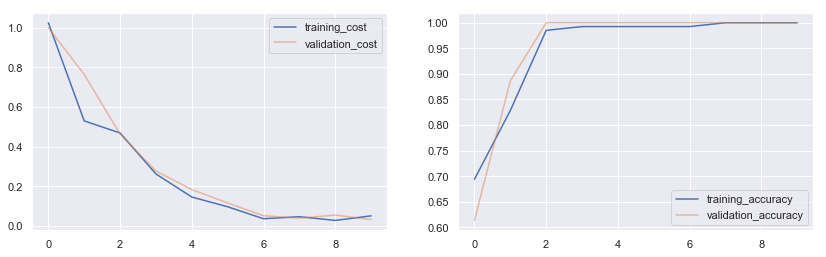

<Figure size 1008x288 with 0 Axes>

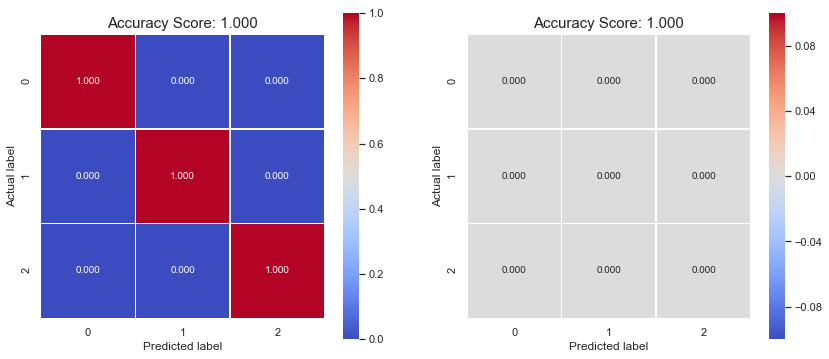

In [102]:
task_4.train_nn(X_train=X, y_train=y, epochs=10, batch_size=16, cval=0.25)

Notice above I plot on the right a modified version of the confusion matrix where I get rid of the diagonals so that I can clearly see where the eventual classification problems are.

We now run the model on the K_folds using this time L2_regularization instead of dropout:
    
- l2_reg= 0.01

In [103]:
task_4 = vidigen_NN_task_4(size_h_layer=(X.shape[1], 12, 12, len(np.unique(y))), 
                          activation_h='ReLU', activation_o='softmax',
                          l_rate=0.25, l_decay=0.95, bias= 1,
                          l2_reg= 0.01, dropout=(None, (0, 0.20, 0.20)),
                          plot_cost=False, print_=None, plots=None)

Let's run the model on the k_fold cross validation: notice that for accuracy I am fitting the scaler (fit_transform) just to the traning samples used and and scaling (transform) the testing samples created by k_fold:

In [105]:
from sklearn.model_selection import KFold

folds = 5
kf = KFold(folds)
sc = StandardScaler()
accuracy_on_xval_set = []
for train_idx, val_idx in kf.split(X,y):
    Xtrain = sc.fit_transform(X[train_idx])
    ytrain = y[train_idx]
    Xtest = sc.transform(X[val_idx])
    ytest = y[val_idx]
    task_4.train_nn(X_train=Xtrain, y_train=ytrain, epochs=20, batch_size=10)
    accuracy_on_xval_set.append((np.argmax(task_4.fwd_prop(Xtest, dropout_on=0), axis=0) == ytest.reshape(1,-1)).mean())
    
print('accuracy_on_'+str(folds)+'_val_sets: ',np.round(accuracy_on_xval_set,4))
print('avg_accuracy: ', np.round(np.array(accuracy_on_xval_set).mean(),4))

accuracy_on_5_val_sets:  [1. 1. 1. 1. 1.]
avg_accuracy:  1.0


as we can see the model is pretty accurate on all the validation sets! and if we re-run the above code (which means we are retraining the network starting from the pre-trained weights) we get almoast 100% accuracy

### Load the nasty SVHN dataset from http://ufldl.stanford.edu/housenumbers/ 

I load the matlab file version and then I convert it in pandas df with "loadmat". The format of the datasets is explain below:

From the website above: "Character level ground truth in an MNIST-like format. All digits have been resized to a fixed resolution of 32-by-32 pixels. The original character bounding boxes are extended in the appropriate dimension to become square windows, so that resizing them to 32-by-32 pixels does not introduce aspect ratio distortions. Nevertheless this preprocessing introduces some distracting digits to the sides of the digit of interest. Loading the .mat files creates 2 variables: X which is a 4-D matrix containing the images, and y which is a vector of class labels. To access the images, X(:,:,:,i) gives the i-th 32-by-32 RGB image, with class label y(i)."

http://ufldl.stanford.edu/housenumbers/train_32x32.mat

http://ufldl.stanford.edu/housenumbers/test_32x32.mat

In [315]:
#!wget -O '.'/train_32x32.mat http://ufldl.stanford.edu/housenumbers/train_32x32.mat

In [316]:
#!wget -O '.'/test_32x32.mat http://ufldl.stanford.edu/housenumbers/test_32x32.mat

In [317]:
from scipy.io import loadmat

df = loadmat('train_32x32.mat')
df.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])

In [318]:
df['X'].shape

(32, 32, 3, 73257)

Let's print some random examples from the dataset...

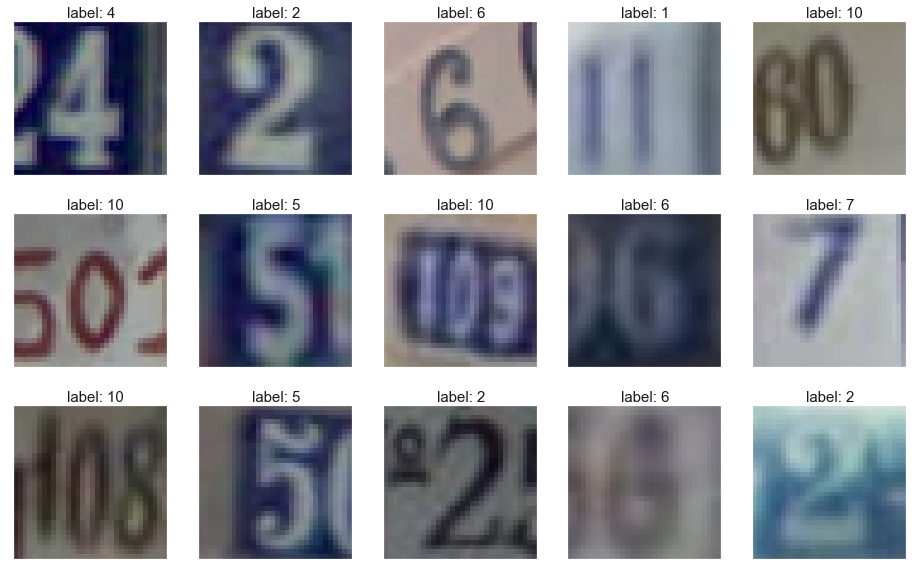

In [319]:
fig, axes = plt.subplots(3, 5, figsize=(16, 10),
                         subplot_kw={'xticks':[], 'yticks':[]})

rnd_choice = np.random.choice(73257,15)
for i, ax in enumerate(axes.flat):
    ax.imshow(df['X'][:,:,:,rnd_choice[i]])
    ax.text(0.35, 1.025, 'label: '+str(df['y'][rnd_choice[i]][0]),
            transform=ax.transAxes, color='k',fontsize=15)

as we can see it's a pretty complicated dataset with lots of noises, some digits are rotated and some are barely readable. Also you can see how the classifier might get confused by the digits next to the centered one we want to classify.

Let's now slit the data in a Training and Testing set. Note this testing set has created from the train_32x32.mat downloaded. Instead the final test will be done on the file test_32x32.mat that we don't touch during training.

- to process the data to feed to the network I flatten the dimensions ( 32,32,3,#samples ) and transpose to have the shape ( #samples, 3072 )
- also I replace the label 10 with 0 so that it doesn't create problem when I execute the hotencoding


In [320]:
#del df

In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#we need the loadmat function to convert the MATLAB file downloaded into pandas dataframe
df = loadmat('train_32x32.mat')
X = df['X'].reshape(3072,-1).T
y = df['y'].astype(int).copy()
# for calculation reasons (it creates problem with the onehot encoding later) 
#we replace the target label 10 with 0
y[y==10]=0

# I take a small split for the test set as I need more data to train to then test it on the main TEST set
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.10, random_state=42)
unscaled_Xtrain = Xtrain.copy()
sc = StandardScaler()
Xtrain = sc.fit_transform(Xtrain.astype(float))
Xtest = sc.transform(Xtest.astype(float))

print('Xtrain_shape: ',Xtrain.shape, ' ytrain_shape: ',ytrain.shape)
print('Xtest_shape: ',Xtrain.shape, ' ytest_shape: ',ytrain.shape)

Xtrain_shape:  (72524, 3072)  ytrain_shape:  (72524, 1)
Xtest_shape:  (72524, 3072)  ytest_shape:  (72524, 1)


let's see if there are some imbalanced classes

In [322]:
pd.Series(y.reshape(-1,)).value_counts()


1    13861
2    10585
3     8497
4     7458
5     6882
6     5727
7     5595
8     5045
0     4948
9     4659
dtype: int64

In [30]:
# Main test set not used for training nor to extract a test set with train_test_split
df_test = loadmat('test_32x32.mat')
X_main_test = df_test['X'].reshape(3072,-1).T
X_main_test = sc.transform(X_main_test.astype(float))
y_main_test = df_test['y'].astype(int).copy()
y_main_test[y_main_test==10]=0

Given how noisy and sparse the data is and that it has 3072 features, we will start training a network with 1 layer but with a relatively big number of neurons. We start with the following structure

- 1 hidden layer with 256 neurons
- ReLU hidden activation
- l_rate = 0.001
- no dropout / no L2 reg

In [347]:
task_4 = vidigen_NN_task_4(size_h_layer=(Xtrain.shape[1], 256, len(np.unique(ytrain))), 
                          activation_h='ReLU', activation_o='softmax',
                          l_rate=0.01, bias= 1,
                          l2_reg= None, dropout=(None, (0, 0.10)),
                          plot_cost=False, print_=1, plots=1)

we start with 20 epoch with a batch_size = 64. Notice that the initial accuracy should be ~= to the random guess

initial_cost:  6.8171  initial_acc:  0.0917
epoch_0  --> cost_train:  1.8831 train_acc:  0.651  -- cost_val:  2.5052  val_acc:  0.6448  ==> grads:  0.03055
epoch_1  --> cost_train:  1.2867 train_acc:  0.7236  -- cost_val:  1.8231  val_acc:  0.7079  ==> grads:  0.0284
epoch_2  --> cost_train:  1.0399 train_acc:  0.7661  -- cost_val:  1.5286  val_acc:  0.7422  ==> grads:  0.03288
epoch_3  --> cost_train:  0.9014 train_acc:  0.7415  -- cost_val:  1.3523  val_acc:  0.7163  ==> grads:  0.03597
epoch_4  --> cost_train:  0.8128 train_acc:  0.7985  -- cost_val:  1.2422  val_acc:  0.7666  ==> grads:  0.01887
epoch_5  --> cost_train:  0.7489 train_acc:  0.8198  -- cost_val:  1.158  val_acc:  0.7858  ==> grads:  0.02159
epoch_6  --> cost_train:  0.6992 train_acc:  0.8402  -- cost_val:  1.0938  val_acc:  0.8047  ==> grads:  0.0275
epoch_7  --> cost_train:  0.6587 train_acc:  0.848  -- cost_val:  1.0441  val_acc:  0.8081  ==> grads:  0.02248
epoch_8  --> cost_train:  0.6227 train_acc:  0.8558  -- c

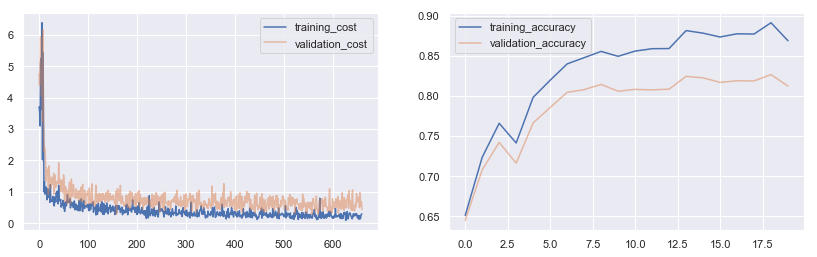

0:04:36.722223


<Figure size 1008x288 with 0 Axes>

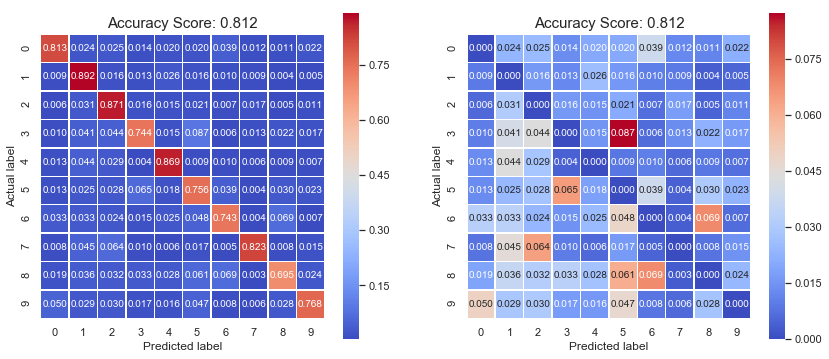

In [348]:
now = pd.datetime.now()
task_4.train_nn(X_train=Xtrain, y_train=ytrain, epochs=20, batch_size=64, cval=0.2)
after = pd.datetime.now()
print(after - now)

We trained it for 20 epochs and as we can see the cost has gone nicely down (so as the accuracy has gone up) both on the training set and the validation set, but clearly the network needs to train more. The learning rate seems about right

So let's do the following changes:

- increase the epoch to 50 
- batch size to 64 
- we add the 2nd layer to see if the network will benefit from it, comparing the grads health during training and the improvements for the same epochs and batchs


In [363]:
task_4 = vidigen_NN_task_4(size_h_layer=(Xtrain.shape[1], 256, 256, len(np.unique(ytrain))), 
                          activation_h='ReLU', activation_o='softmax',
                          l_rate=0.01, bias= 1,
                          l2_reg= None, dropout=(None, (0, 0.5,0.5)),
                          plot_cost=False, print_=1, plots=1)



initial_cost:  3.2704  initial_acc:  0.0896
epoch_0  --> cost_train:  1.2266 train_acc:  0.6823  -- cost_val:  1.5047  val_acc:  0.6696  ==> grads:  0.01906
epoch_1  --> cost_train:  0.9517 train_acc:  0.7454  -- cost_val:  1.2475  val_acc:  0.7258  ==> grads:  0.01661
epoch_2  --> cost_train:  0.8295 train_acc:  0.776  -- cost_val:  1.1005  val_acc:  0.7494  ==> grads:  0.02199
epoch_3  --> cost_train:  0.7426 train_acc:  0.8106  -- cost_val:  1.0332  val_acc:  0.7796  ==> grads:  0.0231
epoch_4  --> cost_train:  0.68 train_acc:  0.8276  -- cost_val:  0.978  val_acc:  0.7931  ==> grads:  0.01908
epoch_5  --> cost_train:  0.6272 train_acc:  0.8233  -- cost_val:  0.9378  val_acc:  0.7868  ==> grads:  0.02541
epoch_6  --> cost_train:  0.5909 train_acc:  0.838  -- cost_val:  0.8991  val_acc:  0.7955  ==> grads:  0.01822
epoch_7  --> cost_train:  0.5563 train_acc:  0.8617  -- cost_val:  0.8757  val_acc:  0.8117  ==> grads:  0.01764
epoch_8  --> cost_train:  0.5298 train_acc:  0.8659  -- co

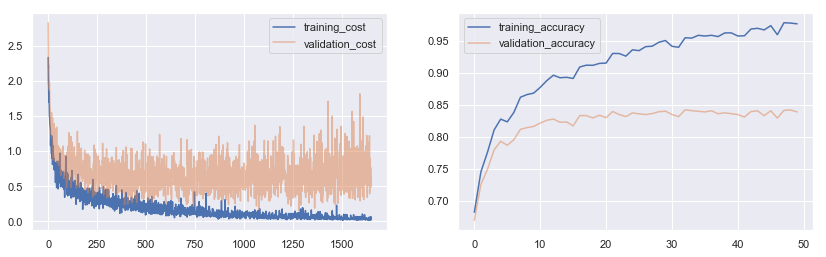

<Figure size 1008x288 with 0 Axes>

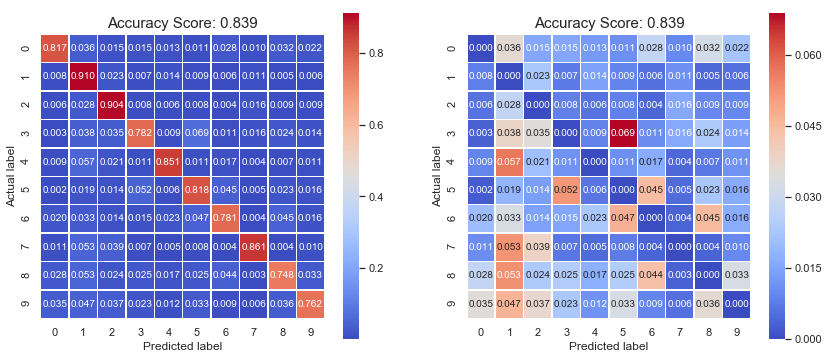

In [364]:
task_4.train_nn(X_train=Xtrain, y_train=ytrain, epochs=50, batch_size=64, cval=0.2)

Observations from the results:


- it seems to have been beneficial to increase to 2 layer
- we should add some regularization as we can noticed that, after the 10th epoch the accuracy on the validation set has been flattened and got stuck to around 82/83% diverging from the accuracy on the training set which reached a level above 97%. The training should have been early stopped (I introduce early stopping for task 5)
- no signs yet we need to further increase the number of layers (or neurons)
- so far the learning rate seems about right 
- the grads are healthy all the way through the training (no vanishing/exploding gradient problems)

Therefore, next:

1) we keep 2 layers of 256 neurons each

2) we train it for 50 epochs

3) leave the batch_size to 64

4) add dropout (20%) and L2 reg = 0.001

Let's print some results on the partial TEST set and on the main TEST set

In [366]:
print('accuracy on the training set: ',(task_4.predict(Xtrain) == ytrain).mean())
print('')
print('accuracy on the partial test set: ',(task_4.predict(Xtest) == ytest).mean())
print('')
print('accuracy on the "main" Test set: ',(task_4.predict(X_main_test) == y_main_test).mean())

accuracy on the training set:  0.9487191154388679

accuracy on the partial test set:  0.8458913458913458

accuracy on the "main" Test set:  0.8165334972341733


...as to be expected the accuracy on the main TEST set is not great. We definetly need some regularization!

In [382]:
task_4_reg = vidigen_NN_task_4(size_h_layer=(Xtrain.shape[1], 256, 256, len(np.unique(ytrain))), 
                          activation_h='ReLU', activation_o='softmax',
                          l_rate=0.01, bias= 1,  l_decay=0.95,
                          l2_reg= 0.001, dropout=(1, (0, 0.2, 0.2)),
                          plot_cost=False, print_=1, plots=1)


initial_cost:  3.8013  initial_acc:  0.0894
epoch_0  --> cost_train:  1.3494 train_acc:  0.6738  -- cost_val:  1.52  val_acc:  0.659  ==> grads:  0.01897
epoch_1  --> cost_train:  1.1065 train_acc:  0.7334  -- cost_val:  1.263  val_acc:  0.7167  ==> grads:  0.0199
epoch_2  --> cost_train:  0.9836 train_acc:  0.7604  -- cost_val:  1.1498  val_acc:  0.7393  ==> grads:  0.01629
epoch_3  --> cost_train:  0.913 train_acc:  0.781  -- cost_val:  1.0687  val_acc:  0.7595  ==> grads:  0.02222
epoch_4  --> cost_train:  0.8558 train_acc:  0.7976  -- cost_val:  1.0083  val_acc:  0.7723  ==> grads:  0.01689
epoch_5  --> cost_train:  0.8143 train_acc:  0.8117  -- cost_val:  0.9698  val_acc:  0.7843  ==> grads:  0.01817
epoch_6  --> cost_train:  0.7793 train_acc:  0.8184  -- cost_val:  0.9327  val_acc:  0.7909  ==> grads:  0.01369
epoch_7  --> cost_train:  0.7524 train_acc:  0.8265  -- cost_val:  0.9003  val_acc:  0.7987  ==> grads:  0.01354
epoch_8  --> cost_train:  0.7269 train_acc:  0.8334  -- cos

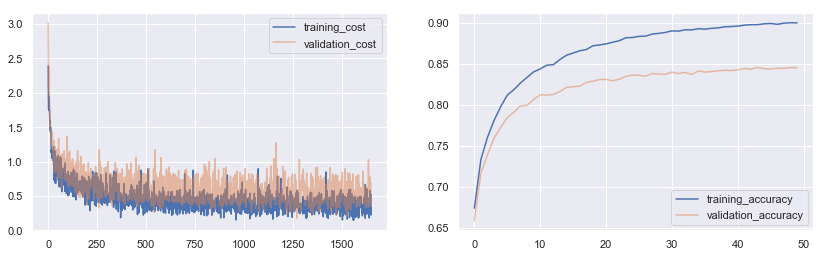

<Figure size 1008x288 with 0 Axes>

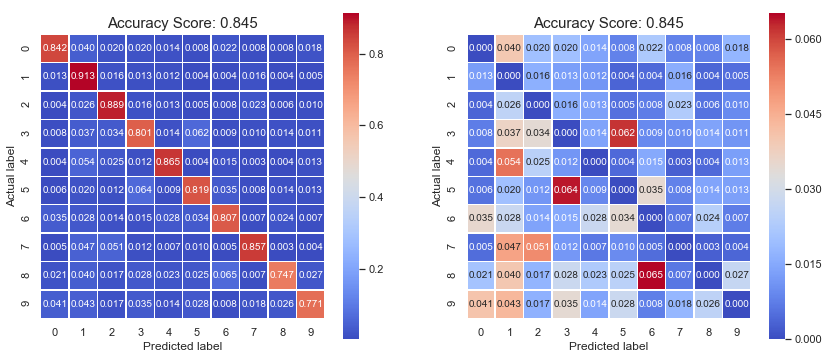

In [383]:
task_4_reg.train_nn(X_train=Xtrain, y_train=ytrain, epochs=50, batch_size=64, cval=0.2)

In [384]:
print('accuracy on the training set: ',(task_4_reg.predict(Xtrain) == ytrain).mean())
print('')
print('accuracy on the partial test set: ',(task_4_reg.predict(Xtest) == ytest).mean())
print('')
print('accuracy on the "main" Test set: ',(task_4_reg.predict(X_main_test) == y_main_test).mean())

accuracy on the training set:  0.888883833098239

accuracy on the partial test set:  0.858039858039858

accuracy on the "main" Test set:  0.8229486785494776


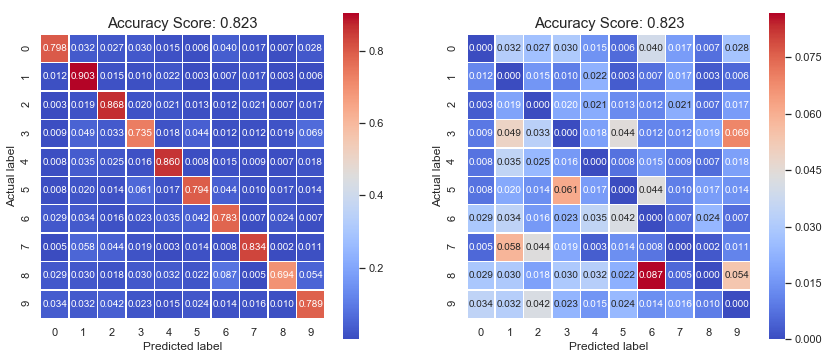

In [385]:
plot_conf_matrix(y_main_test, task_4_reg.predict(X_main_test))

Observations: 

1) The result on the main TEST set is a bit better

2) as we can see from the first epochs the regularization ( dropout and L2 reg) takes its toll as the divergence between the training accuracy and the validation one is less severe and the accuracy on the training set doesn't go anymore well above 90. The level of regularization seems about right.

3) bear in mind that there is also some randomness on the result on the validation test due to the fact that when I reset the training, I reshuffle the data and allocate a part to the validation set which by definition is always different. This is done intentionally because (as humans) we are always guilty of confirmation bias hence we obsessively keep trying until we get the results we want. So by randomly modifying the val set all the time we run it, it's like applying a sort of (human) regularization!

4) we could have stopped earlier as after the 20th epoch the network was not learning anymore although we had a better result on the validation set than before.
    
    Possible reasons:
        - the most obvious is that we added too heavy dropout
        - the learning rate is too high
        - we might have ended up in a local minima
        - we might need to increase the size of the NN in case it needs to learns additional features

Strategy for next run:

- use adaptive learning rate
- increase first the number of neurons to 512 in both layers to try to capture extra non linear features: some reasearchers (Andrew NG, ect..) think that it doesn't really hurt adding extra layers or neurons as long as they are used with sufficient regularization
- investigate the misclassified data point: typically the 1 and 3 get confused respectively with 7 and 5, while 6 gets confused with 8. To address this problem we can:
        - augment the training set adding some noised version of specifically 1,3,5,7, 6 and 8 data/labels
        - we simply augment proportionally the dataset

### Data augmentation

To try to improve the results I generated more data using ImageDataGenerator from keras where we randomly generate new data sampled from the original. This new data will be generate by randomly:

- rotate the original data by 45 degree
- shifted up or down by 10%
- shifted left or right by 10%
- zooming in and out (zoom_range=[0.95,1.2]))

I also added some random noise to the generated augmented data ===> Augmented_X = np.random.normal(Augmented_X,10).astype(int)

In [389]:
X.shape

(73257, 3072)

In [11]:
from keras.preprocessing.image import ImageDataGenerator

pct_increase_train_data = 1

df = loadmat('train_32x32.mat')
X = df['X'].reshape(3072,-1).T
y = df['y'].astype(int).copy()
y[y==10]=0
X = X.reshape(-1,32,32,3)

# generating the augmented data
datagen = ImageDataGenerator(rotation_range=30, width_shift_range=0.1, height_shift_range=0.1, zoom_range=[0.95,1.2])
X_aug = X.astype('float32').copy()
y_aug = y.astype('float32').copy() #np.ones((len(X_aug),1))*class_aug
datagen.fit(X_aug)
X_aug_ = []
y_aug_ = []
for X_batch, y_batch in datagen.flow(X_aug, y_aug, batch_size=np.int(np.round(X.shape[0]*pct_increase_train_data,0))):
    X_aug_.append(X_batch.astype(int))
    y_aug_.append(y_batch.astype(int))
    break
    
#create the augmented dataset
Augmented_X = np.array(X_aug_[0]).reshape(-1,3072)
#add random noise
Augmented_X = np.random.normal(Augmented_X,10).astype(int)

Augmented_y = np.array(y_aug_).reshape(-1,1)
Augmented_y[Augmented_y==10]=0

#merge the original training set with the augmented one
X_train_aug = np.vstack([X.reshape(-1,3072),Augmented_X])
y_train_aug = np.vstack([y,Augmented_y])

In [12]:
print('augmented training set shape: ', X_train_aug.shape)

augmented training set shape:  (146514, 3072)


In [13]:
# Main test set not used for training nor to extract a test set with train_test_split
df_test = loadmat('test_32x32.mat')
X_main_test = df_test['X'].reshape(3072,-1).T
y_main_test = df_test['y'].astype(int).copy()
y_main_test[y_main_test==10]=0

In [15]:
import pickle
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

#def load_obj(name ):
#    with open(name, 'rb') as f:
#        return pickle.load(f).item()

In [16]:
#Aug_X_data = {'X_train_aug':X_train_aug, 'y_train_aug':y_train_aug}
#save_obj(Aug_X_data, 'Aug_X_data')

In [20]:
#Aug_X_data = pd.read_pickle('Aug_X_data.pkl')
#X_train_aug = Aug_X_data['X_train_aug']
#y_train_aug = Aug_X_data['y_train_aug']


Below are some random example of the generated data

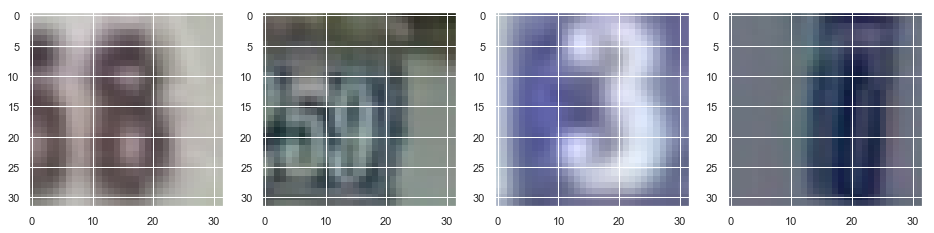

In [15]:
# here we plot some random data
plt.figure(figsize=(16,4))
plt.subplot(1,4,1)
plt.imshow(X_train_aug[np.random.choice(50000,1)].reshape(32,32,3))
plt.subplot(1,4,2)
plt.imshow(X_train_aug[np.random.choice(50000,1)].reshape(32,32,3))
plt.subplot(1,4,3)
plt.imshow(X_train_aug[np.random.choice(50000,1)].reshape(32,32,3))
plt.subplot(1,4,4)
plt.imshow(X_train_aug[np.random.choice(50000,1)].reshape(32,32,3))

In [14]:
# scaling the data

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

X_train_aug_sc = sc.fit_transform(X_train_aug.astype(float))
X_main_test_sc = sc.transform(X_main_test.astype(float))


and now let's train a deepr 2 layers network with 512 neurons each:

- we increase dropout rate and decrease the L2 reg

In [24]:
task_4_reg_aug = vidigen_NN_task_4(size_h_layer=(X_train_aug_sc.shape[1], 1024, 256, len(np.unique(ytrain))), 
                          activation_h='ReLU', activation_o='softmax',
                          l_rate=0.01, bias= 1,  l_decay=0.95,
                          l2_reg= 0.0, dropout=(1, (0, 0.5, 0.3)),
                          plot_cost=False, print_=1, plots=1)



initial_cost:  4.8075  initial_acc:  0.0996
epoch_0  --> cost_train:  1.7975 train_acc:  0.4802  -- cost_val:  1.8853  val_acc:  0.4809  ==> grads:  0.01206
epoch_1  --> cost_train:  1.6008 train_acc:  0.5602  -- cost_val:  1.6846  val_acc:  0.5523  ==> grads:  0.01108
epoch_2  --> cost_train:  1.5027 train_acc:  0.5957  -- cost_val:  1.5827  val_acc:  0.5878  ==> grads:  0.01034
epoch_3  --> cost_train:  1.4254 train_acc:  0.6242  -- cost_val:  1.5099  val_acc:  0.61  ==> grads:  0.01089
epoch_4  --> cost_train:  1.3649 train_acc:  0.6427  -- cost_val:  1.4539  val_acc:  0.6291  ==> grads:  0.01201
epoch_5  --> cost_train:  1.316 train_acc:  0.6639  -- cost_val:  1.408  val_acc:  0.6462  ==> grads:  0.01055
epoch_6  --> cost_train:  1.2743 train_acc:  0.6744  -- cost_val:  1.3689  val_acc:  0.656  ==> grads:  0.01044
epoch_7  --> cost_train:  1.2412 train_acc:  0.6879  -- cost_val:  1.3351  val_acc:  0.6678  ==> grads:  0.01109
epoch_8  --> cost_train:  1.2094 train_acc:  0.6979  -- c

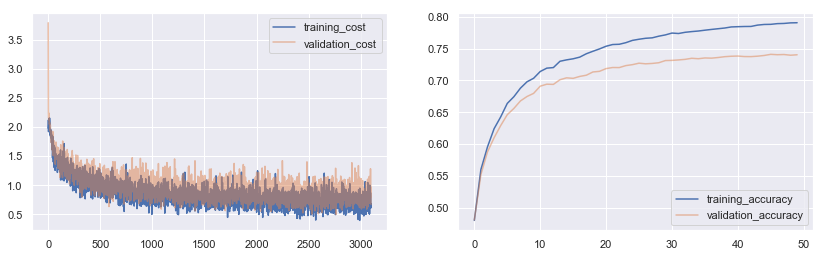

<Figure size 1008x288 with 0 Axes>

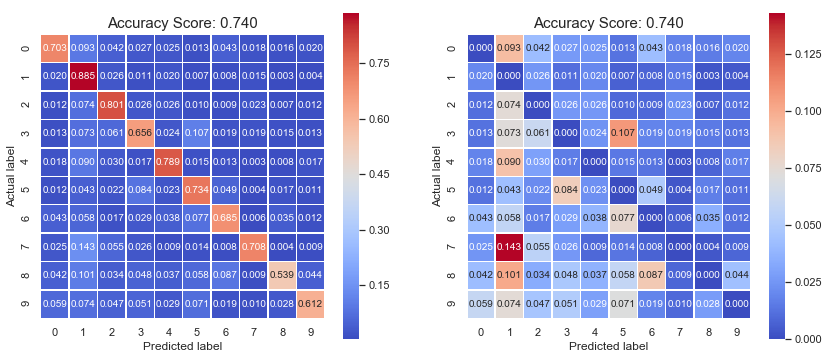

In [25]:
task_4_reg_aug.train_nn(X_train=X_train_aug_sc, y_train=y_train_aug, epochs=50, batch_size=64, cval=0.2)

In [26]:
print('accuracy on the training set: ',(task_4_reg_aug.predict(X_train_aug_sc) == y_train_aug).mean())
print('')
print('accuracy on the "main" Test set: ',(task_4_reg_aug.predict(X_main_test) == y_main_test).mean())

accuracy on the training set:  0.7805073951175187

accuracy on the "main" Test set:  0.821681007990166


Results have improved but I guess to train it efficiently we need an optimizer. We'll have another go in task 5 with this SVHN dataset

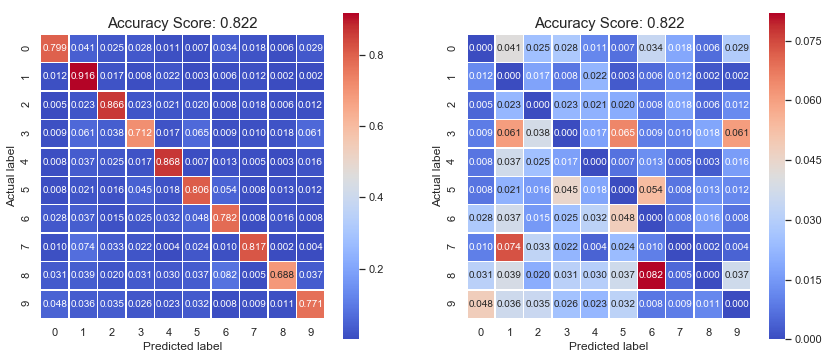

In [53]:
plot_conf_matrix(y_main_test,task_4_reg_aug.predict(X_main_test))

## Task 5. Optimization of hyper-parameters

Here below I introduced:
    
    1) optimizers: momentum, RMSprop and adam
    2) a personalized early stopping strategy
    3) a learning rate decay with the following update at the end on each epoch: l_rate = 0.95**epoch * initial_l_rate
        syntax in the code: l_decay=
    4) "he" initialization (paper of 2015 by He) which according to the research works well with ReLU:
        np.random.randn([l]_size, [l-1]_size)*np.sqrt(2/[l-1]_size)
        

Optimizers: in the code set up I create the tuple optimizer=('adam',{'beta1':0.9, 'beta2':0.999})
where the options are: "momentum", "RMSprop", "adam"

- MOMENTUM: the basic idea is to calculate an exponential weighted moving average of the gradients and using this averages to update parameters. At each iteration (batch in epochs) we compute the normal gradients (dW and dB) and we then use this function (exponential weighted moving avg) to update the v parameters:
        
        vdW = beta1 * previous_vdW + (1-beta1)*dW
        vdB = beta1 * previous_vdB + (1-beta1)*dB
        
  and then we use this vdW to update the W and b paramenters:
  
        W = W - vdW * l_rate
        b = b - vdB * l_rate
        
  in the code I use the standard (commonly used value) for the parameter beta1 set = 0.9
  
  
- RMSprop: this optimizer uses the following exponential moving averages:
        
        sdW = beta2 * previous_sdW + (1-beta2)*dW**2
        sdB = beta2 * previous_sdB + (1-beta2)*dB**2
   and it updates the parameters in the following way:
   
        W = W - dW/(np.sqrt(sdW) + 1e-8) * l_rate
        b = b - dB/(np.sqrt(sdB) + 1e-8) * l_rate
        
   notice that I added a small number at the denominator in case sqrt(sdW) becomes =0
   
        
- ADAM: same principle but it combine the effect of both exp mov avgs above:

        vdW = beta1 * previous_vdW + (1-beta1)*dW
        vdB = beta1 * previous_vdB + (1-beta1)*dB
        sdW = beta2 * previous_sdW + (1-beta2)*dW**2
        sdB = beta2 * previous_sdB + (1-beta2)*dB**2
    
  and the update rules are:
  
        W = W - vdW/(np.sqrt(sdW) + 1e-8) * l_rate
        b = b - vdB/(np.sqrt(sdB) + 1e-8) * l_rate
        
In summary, the idea behind the optimizers is that this methods, during backpropagation, try to give some momentum/acceleration to the gradients so reducing chance of local minima but especially improving the learning in situations in which the gradients become really small and they could slow down the algorithm. So, in this caes, if the gradients accumulated some momentum, the updates are done with values that are less small they would have been without using any momentum.
        
Early stopping strategy:

Early stopping is a form of regularization as it prevents to overtrain the network and therefore to overfit it. The downside of it is that we might early stop it when the training it's just temporary stucked to then start inmproving again if left run further. Also deciding when to early stop the training is always quite discretional as it relies on the choice of a certain increase in the cost function evaluated either on the training or on the validation set. Another possibility is to estabilish some form of divergence between the accuracy on the training set and the validation set, etc...
My personalized early stop strategy works as following:

- after a certain # of epochs (let's say 20) I fit a line onto the previous 20 cost levels calculated on the training set and on the validation set (in both cases I switch off the dropout). Then I have 3 options:

        1)"soft": stop the training when the slope of the regression line of the training costs becomes positive or above a very small negative number (eg: -1e-5) which means that the cost function on the training set has flattened or start going up.
    
        2)"hard": stop the training when eighter the slope of the training cost line or the validation cost one becomes positive (or bigger than a small negaive number)

In [3]:
from sklearn.metrics import mean_squared_error

class vidigen_NN_task_5():
    
    def __init__(self, size_h_layer, l_rate, l_decay=None, initialization='he', activation_h='ReLU', activation_o= 'sigmoid', l2_reg=None,
                 dropout = (None, (0,0.25)), bias=1, 
                 optimizer=('momentum',{'beta1':0.9, 'beta2':0.999}),
                 plot_cost= False, plots=True, print_=True):
        """
        X has to have shape (#samples, #features)
        y has to have shape (#samples, 1)
        """
        self.size_h_layer = size_h_layer # (X_feat, h_struct, otput dim)        
        self.activation_h = activation_h
        self.activation_o = activation_o
        self.l_rate = l_rate
        self.l_decay = l_decay
        self.initialization = initialization
        self.l2_reg = l2_reg
        self.dropout = dropout
        self.bias = bias
        self.optimizer = optimizer
        self.plot_cost = plot_cost
        self.print_ = print_
        self.plots = plots
        
        if self.activation_h == 'ReLU': 
            self.activation_function = ReLU
            self.derivative_func = ReLU_derivation
        if self.activation_h == 'LeakyReLU': 
            self.activation_function = LeakyReLU
            self.derivative_func = LReLU_deriv
        if self.activation_h == 'sigmoid': 
            self.activation_function = sigmoid    
            self.derivative_func = sigmoid_der
        
        self.initialize_params()
        
        if self.optimizer[0]=='momentum':
            self.initialize_v()
        if self.optimizer[0]=='RMSprop':
            self.initialize_s()
        if self.optimizer[0]=='adam':
            self.initialize_v()
            self.initialize_s()
            
        if self.l_decay:
            self.initial_l_rate = self.l_rate
    
    #--------------------------------------------------------------------------------------
    def initialize_params(self):
        bias_node = 1 if self.bias else 0
        self.Ws = {}
        self.Bs = {}
        for l in range(1,len(self.size_h_layer)):            
            if self.bias:
                if self.initialization == 'truncnorm':
                    rad = 1 / np.sqrt(self.size_h_layer[l])
                    N = truncated_normal(mean=0, sd=1, low=-rad, upp=rad)
                    self.Ws['W_'+str(l)] = N.rvs((self.size_h_layer[l], self.size_h_layer[l-1]))
                    self.Bs['b_'+str(l)] = N.rvs((self.size_h_layer[l],1))
                if self.initialization == 'he':
                    self.Ws['W_'+str(l)] = np.random.randn(self.size_h_layer[l], self.size_h_layer[l-1]) * np.sqrt(1/self.size_h_layer[l-1])
                    self.Bs['b_'+str(l)] = np.random.randn(self.size_h_layer[l],1) * np.sqrt(1/self.size_h_layer[l-1])
            
            else:
                if self.initialization == 'truncnorm':
                    rad = 1 / np.sqrt(self.size_h_layer[l])
                    N = truncated_normal(mean=0, sd=1, low=-rad, upp=rad)
                    self.Ws['W_'+str(l)] = N.rvs((self.size_h_layer[l], 
                                           self.size_h_layer[l-1]))
                if self.initialization == 'he':
                    self.Ws['W_'+str(l)] = np.random.randn(self.size_h_layer[l], self.size_h_layer[l-1]) * np.sqrt(1/self.size_h_layer[l-1])
                    
    #--------------------------------------------------------------------------------------            
    def initialize_v(self):
        L = len(self.Ws)
        self.v = {}
        for l in range(L):
            self.v['vdW_'+str(l+1)] = np.zeros(self.Ws['W_'+str(l+1)].shape)
            if self.bias:
                self.v['vdB_'+str(l+1)] = np.zeros(self.Bs['b_'+str(l+1)].shape)
    #--------------------------------------------------------------------------------------
    def initialize_s(self):
        L = len(self.Ws)
        self.s = {}
        for l in range(L):
            self.s['sdW_'+str(l+1)] = np.zeros(self.Ws['W_'+str(l+1)].shape)
            if self.bias:
                self.s['sdB_'+str(l+1)] = np.zeros(self.Bs['b_'+str(l+1)].shape)
            
    #--------------------------------------------------------------------------------------   
    def fwd_prop(self, input_vect, dropout_on=1):
        self.z = {}
        self.a = {}
        self.d = {}
        
        if self.bias: adjust_bias = 1
        else: adjust_bias = 0
            
        for l in range(1,len(self.size_h_layer)):
            
            if l == 1: # input layer 
                    
                self.z['z_'+str(l)] = self.Ws['W_'+str(l)].dot(input_vect.T) + self.Bs['b_'+str(l)]*adjust_bias 
                self.a['a_'+str(l)] = self.activation_function(self.z['z_'+str(l)] )    
                if self.dropout[0] and dropout_on:
                    d = np.random.rand(*self.a['a_'+str(l)].shape)
                    self.d['d_'+str(l)] = 1 * (d > self.dropout[1][l])
                    self.a['a_'+str(l)] *= self.d['d_'+str(l)]
                    self.a['a_'+str(l)] /= (1-self.dropout[1][l])
                    
            elif (l > 1) and (l < len(self.size_h_layer)-1): 
                self.z['z_'+str(l)] = self.Ws['W_'+str(l)].dot(self.a['a_'+str(l-1)]) + self.Bs['b_'+str(l)]*adjust_bias 
                self.a['a_'+str(l)] = self.activation_function(self.z['z_'+str(l)])
                if self.dropout[0] and dropout_on:
                    d = np.random.rand(*self.a['a_'+str(l)].shape)
                    self.d['d_'+str(l)] = 1 * (d > self.dropout[1][l])
                    self.a['a_'+str(l)] *= self.d['d_'+str(l)]
                    self.a['a_'+str(l)] /= (1-self.dropout[1][l])
                    
            elif l == len(self.size_h_layer)-1: 
                if self.activation_o == 'sigmoid':                    
                    self.z['z_'+str(l)] = self.Ws['W_'+str(l)].dot(self.a['a_'+str(l-1)]) + self.Bs['b_'+str(l)]*adjust_bias 
                    self.a['a_'+str(l)] = sigmoid(self.z['z_'+str(l)])
                if self.activation_o == 'softmax':
                    self.z['z_'+str(l)] = self.Ws['W_'+str(l)].dot(self.a['a_'+str(l-1)]) + self.Bs['b_'+str(l)]*adjust_bias 
                    self.a['a_'+str(l)] = softmax(self.z['z_'+str(l)])
                if self.activation_o == 'linear':
                    self.z['z_'+str(l)] = self.Ws['W_'+str(l)].dot(self.a['a_'+str(l-1)]) + self.Bs['b_'+str(l)]*adjust_bias 
                    self.a['a_'+str(l)] = self.z['z_'+str(l)]
                    
        return self.a['a_'+str(l)]
        
    #--------------------------------------------------------------------------------------
    def J_cost(self, y, output):
        m = y.shape[0]
        if self.activation_o == 'sigmoid':
            y_enc = y.T
        elif self.activation_o == 'softmax':
            #y.shape = (#samples, class)
            y_enc = encode_labels(y, self.size_h_layer[-1])
        elif self.activation_o == 'linear':
            y_enc = y.T
            
        if self.l2_reg:
            reg = 0
            for k in self.Ws.keys():
                reg = reg + (np.square(self.Ws[k])).sum()
            reg = (1/m) * self.l2_reg/2 * reg
        else: reg = 0
            
        if self.activation_o == 'sigmoid':
            cost_ = -(1/m) * (y_enc * (np.log(output)) + (1.0 - y_enc) * np.log(1.0 - output)) #+ reg
        if self.activation_o == 'softmax':
            cost_ = -(1/m) * (y_enc * (np.log(output))) #+ reg
        if self.activation_o == 'linear':
            cost_ = 0.5 * (1/m) * np.square(y_enc - output) #+ reg
        cost = np.sum(cost_)   
                           
        return cost
    
    #--------------------------------------------------------------------------------------
    def optimize_grads(self, layer):
        l = layer
        if self.optimizer[0]=='momentum':
            beta1 = self.optimizer[1]['beta1']
            self.v['vdW_'+str(l)] = beta1 * self.v['vdW_'+str(l)] + (1-beta1)*self.dW['dw_'+str(l)]
            if self.bias:
                self.v['vdB_'+str(l)] = beta1*self.v['vdB_'+str(l)] + (1-beta1)*self.dB['db_'+str(l)]
        if self.optimizer[0]=='RMSprop':# or self.optimizer[0]=='adam':
            t = np.where(self.t,self.t, 2)
            #print(t)
            beta2 = self.optimizer[1]['beta2']
            #print(beta2)
            self.s['sdW_'+str(l)] = beta2*self.s['sdW_'+str(l)] + (1-beta2)*np.square(self.dW['dw_'+str(l)])
            #self.s['sdW_'+str(l-1)] /= (1-self.optimizer[1]['beta2']**t)
            #print(self.s['sdW_'+str(l-1)])
            if self.bias:
                self.s['sdB_'+str(l)] = beta2*self.s['sdB_'+str(l)] + (1-beta2)*np.square(self.dB['db_'+str(l)])
                #self.s['sdB_'+str(l-1)] /= (1-self.optimizer[1]['beta2']**t)
                
        if self.optimizer[0]=='adam':# or self.optimizer[0]=='adam':
            beta1 = self.optimizer[1]['beta1']
            beta2 = self.optimizer[1]['beta2']
            self.v['vdW_'+str(l)] = beta1*self.v['vdW_'+str(l)] + (1-beta1)*self.dW['dw_'+str(l)]
            self.s['sdW_'+str(l)] = beta2*self.s['sdW_'+str(l)] + (1-beta2)*np.square(self.dW['dw_'+str(l)])
            if self.bias:
                self.v['vdB_'+str(l)] = beta1*self.v['vdB_'+str(l)] + (1-beta1)*self.dB['db_'+str(l)]
                self.s['sdB_'+str(l)] = beta2*self.s['sdB_'+str(l)] + (1-beta2)*np.square(self.dB['db_'+str(l)])
                
    #--------------------------------------------------------------------------------------            
    def back_prop(self, input_vect, y):
       
        assert(y.shape[1]==1)
        
        m = input_vect.shape[0]
        
        self.sigmas = {}
        self.dZ = {}
        self.dW = {}
        self.dB = {}
        
        if self.size_h_layer[-1]>1:
            y = encode_labels(y,self.size_h_layer[-1]) 
        else: y = y.T
            
        # last layer
        output = self.fwd_prop(input_vect)        
        l = len(self.size_h_layer)-1  
        
        #last layer error
        self.sigmas['sigma_'+str(l)] = output - y
        if self.l2_reg:
            add_reg = self.l2_reg/m * self.Ws['W_'+str(l)]
        else: add_reg = 0
            
        #last weights grads
        self.dW['dw_'+str(l)] = (1 / m) * np.dot(self.sigmas['sigma_'+str(l)], self.a['a_'+str(l-1)].T) + add_reg            
        
        if self.bias:
            self.dB['db_'+str(l)] = (1 / m) * np.sum(self.sigmas['sigma_'+str(l)], axis=1, keepdims=True) 
            
        if self.optimizer[0] != None:
            self.optimize_grads(layer=l)
        
                
        # hidden layer back prop
        for l in reversed(range(1, len(self.size_h_layer)-1)): #reverse loop through layer excluding the 1st
            if self.dropout[0]:
                drop_adj = self.Ws['W_'+str(l+1)].T.dot(self.sigmas['sigma_'+str(l+1)]) * self.d['d_'+str(l)]
                #inverted dropout adjustments
                drop_adj /= (1-self.dropout[1][l])
                self.sigmas['sigma_'+str(l)] = drop_adj * self.derivative_func(self.z['z_'+str(l)])
            else:
                self.sigmas['sigma_'+str(l)] = self.Ws['W_'+str(l+1)].T.dot(self.sigmas['sigma_'+str(l+1)]) * self.derivative_func(self.z['z_'+str(l)])                        
            if self.l2_reg:
                add_reg = self.l2_reg/m * self.Ws['W_'+str(l)]
            else: add_reg = 0 
            #gradients
            if l == 1:                
                self.dW['dw_'+str(l)] = (1 / m) * np.dot(self.sigmas['sigma_'+str(l)], input_vect) + add_reg
            else:
                self.dW['dw_'+str(l)] = (1 / m) * np.dot(self.sigmas['sigma_'+str(l)], self.a['a_'+str(l-1)].T) + add_reg
            
            if self.bias:
                self.dB['db_'+str(l)] = (1 / m) * np.sum(self.sigmas['sigma_'+str(l)], axis=1, keepdims=True)
                
            if self.optimizer[0] != None:
                self.optimize_grads(layer=l)
            
            
    #--------------------------------------------------------------------------------------    
    def updates(self):
        for l in range(1,len(self.Ws)+1):
            if self.optimizer[0] == 'momentum':
                # use v/(1-beta**t) for bias adjustments
                t = np.where(self.t,self.t,2)
                self.Ws['W_'+str(l)] -= self.l_rate * self.v['vdW_'+str(l)]/(1-self.optimizer[1]['beta1']**t)
                self.Bs['b_'+str(l)] -= self.l_rate * self.v['vdB_'+str(l)]/(1-self.optimizer[1]['beta1']**t)
            if self.optimizer[0] == 'RMSprop':
                # use v/(1-beta**t) for bias adjustments
                t = np.where(self.t,self.t,2)
                self.Ws['W_'+str(l)] -= self.l_rate * self.dW['dw_'+str(l)] / (np.sqrt(self.s['sdW_'+str(l)]) + 1e-07)#/(1-self.optimizer[1]['beta2']**t))
                self.Bs['b_'+str(l)] -= self.l_rate * self.dB['db_'+str(l)] / (np.sqrt(self.s['sdB_'+str(l)]) + 1e-07)#/(1-self.optimizer[1]['beta2']**t))
            if self.optimizer[0] == 'adam':
                # use v/(1-beta**t) for bias adjustments
                t = np.where(self.t,self.t,2)
                self.Ws['W_'+str(l)] -= self.l_rate * self.v['vdW_'+str(l)] / (np.sqrt(self.s['sdW_'+str(l)]) + 1e-07)# /(1-self.optimizer[1]['beta1']**t))
                self.Bs['b_'+str(l)] -= self.l_rate * self.v['vdB_'+str(l)] / (np.sqrt(self.s['sdB_'+str(l)]) + 1e-07)# /(1-self.optimizer[1]['beta1']**t))
                       
            else:
                self.Ws['W_'+str(l)] -= self.l_rate * self.dW['dw_'+str(l)] 
                self.Bs['b_'+str(l)] -= self.l_rate * self.dB['db_'+str(l)]
    
    #--------------------------------------------------------------------------------------
    def predict(self,X):
        pred = self.fwd_prop(X, dropout_on=0)
        if self.activation_o=='softmax':
            pred = np.argmax(pred, axis=0).reshape(-1,1)
        if self.activation_o=='sigmoid':
            pred = np.where(pred>0.5,1,0).reshape(-1,1)
        if self.activation_o=='linear':
            pred = pred.reshape(-1,1)
        else:
            pred = pred
        return pred
    
    #--------------------------------------------------------------------------------------
    def train_nn(self, X_train, y_train, epochs=10, batch_size=32, cval=None, early_stopping=('soft', {'epochs':20}), grads_stopping=None):
        self.t = 1
        m = X_train.shape[0]
        assert(y_train.shape[1]==1)
        assert(X_train.shape[0] == y_train.shape[0])
        
        if cval!=None:   
            #reshuffle training set
            data = np.hstack([X_train, y_train])
            np.random.shuffle(data)
            
            val_data = np.round(cval*m,0).astype(int)
            X_val = data[:val_data,:-1]
            y_val = data[:val_data,-1].reshape(-1,1).astype(int)
            
            X_train_ = data[val_data:,:-1]
            y_train_ = data[val_data:,-1].reshape(-1,1).astype(int)
            

        else:
            X_train_ = X_train.copy()
            y_train_ = y_train.copy()
        
        
        
        validation_accuracy = []
        training_accuracy = []
        validation_cost = []
        training_cost = []
        self.tr_batch_cost = []
        self.val_batch_cost = []
        self.gradient_sizes = []
        
        #initial cost and accuracy
        train_output = self.fwd_prop(input_vect=X_train_)
        initial_cost = np.round(self.J_cost(y=y_train_, output=train_output),4)
        
        if self.activation_o == 'softmax':
            initial_acc = np.round((np.argmax(train_output, axis=0).reshape(-1,1)==y_train_).mean(),4)
        elif self.activation_o =='sigmoid':
            initial_acc = (np.where(train_output>0.5,1,0) == y_train_.reshape(1,-1)).mean()
        elif self.activation_o =='linear':
            initial_acc = np.round(np.sqrt(np.square(train_output - y_train_.reshape(1,-1))).sum()/y_train_.mean(),4)
        else:
            pass
        if self.print_!=None:
            print('initial_cost: ',initial_cost, ' initial_acc: ',initial_acc)
        
        # epochs run
        for e in range(epochs):
    
            m = X_train_.shape[0]
            #reshuffle training set
            data = np.hstack([X_train_, y_train_])
            np.random.shuffle(data)
            X_train_ = data[:,:-1]
            y_train_ = data[:,-1].reshape(-1,1).astype(int)
            
            if batch_size!= None:
                n_batches = m // batch_size
            else:
                n_batches = 1 #// batch_size
                batch_size = m
            batches = np.array_split(np.arange(m), n_batches)
            
            
            for i, b in enumerate(batches):
                X_ = X_train_[b,:] 
                y_ = y_train_[b,:] 
                #output = self.fwd_prop(input_vect=X_)                    
                self.back_prop(input_vect=X_, y=y_)
                self.updates()
                self.t +=1
                wait = "progress: " + str(np.round(np.round(i/len(batches),2)*100,0))+'%'
                print (wait, end="\r")
                # to solve!!!!!!!!!!!!!!!!!
                if i%25==0:
                    train_output = self.fwd_prop(input_vect=X_, dropout_on=0)
                    train_cost = np.round(self.J_cost(y=y_, output=train_output),4)
                    self.tr_batch_cost.append(train_cost)
                    if cval!= None:
                        val_samples = np.random.choice(X_val.shape[0],np.minimum(batch_size,X_val.shape[0]))
                        val_output = self.fwd_prop(input_vect=X_val[val_samples], dropout_on=0)
                        val_cost = np.round(self.J_cost(y=y_val[val_samples], output=val_output),4)
                        self.val_batch_cost.append(val_cost)
            
            if batch_size==None or batch_size==m:
                train_output = self.fwd_prop(input_vect=X_, dropout_on=0)
                train_cost = np.round(self.J_cost(y=y_, output=train_output),4)
                self.tr_batch_cost.append(train_cost)
                if cval!= None:
                    val_samples = np.random.choice(X_val.shape[0],np.minimum(batch_size,X_val.shape[0]))
                    val_output = self.fwd_prop(input_vect=X_val[val_samples], dropout_on=0)
                    val_cost = np.round(self.J_cost(y=y_val[val_samples], output=val_output),4)
                    self.val_batch_cost.append(val_cost)
                
                    
            # update learning rate with decay
            if self.l_decay:
                self.l_rate = self.initial_l_rate * self.l_decay**e
            
            # calculating improvements at the end of each epoch
            train_output = self.fwd_prop(input_vect=X_train_, dropout_on=0)
            if self.activation_o == 'softmax':    
                train_acc = np.round((np.argmax(train_output, axis=0).reshape(-1,1)==y_train_).mean(),4)
            elif self.activation_o == 'sigmoid':
                train_acc = np.round((np.where(train_output>0.5,1,0) == y_train_.T).mean(),4)
            elif self.activation_o =='linear':
                train_acc = np.round(np.sqrt(np.square(train_output - y_train_.reshape(1,-1))).mean()/y_train_.mean(),4)
            training_accuracy.append(train_acc)
            
            if cval: 
                val_output = self.fwd_prop(input_vect=X_val, dropout_on=0) # switch off the dropout in validation test    
            if cval:    
                if self.activation_o == 'softmax':
                    val_acc = np.round((np.argmax(val_output, axis=0).reshape(-1,1)==y_val).mean(),4)   
                elif self.activation_o == 'sigmoid':
                    val_acc = np.round((np.where(val_output>0.5,1,0) == y_val.T).mean(),4)
                elif self.activation_o == 'linear':
                    val_acc = np.round(np.sqrt(np.square(val_output - y_val.reshape(1,-1))).sum()/y_val.mean(),4)
            else: val_cost = 0; val_acc = 0
            validation_accuracy.append(val_acc)  
            
            train_cost = np.round(np.array(self.tr_batch_cost)[-n_batches:].mean(),4)
            training_cost.append(train_cost)
            if cval!= None:
                val_cost = np.round(np.array(self.val_batch_cost)[-n_batches:].mean(),4)
                validation_cost.append(val_cost)
            
            # adding shock to move from local minima
            grads_ = 0
            for d in self.dW:
                grads_ += np.abs(self.dW[d]).sum()/np.array(self.dW[d].shape).prod()
            self.gradient_sizes.append(grads_)
            
            if self.print_!=None:                
                print('epoch_'+str(e),' --> cost_train: ', train_cost,'train_acc: ', train_acc, ' -- cost_val: ', val_cost,' val_acc: ', val_acc, ' ==> grads: ', np.round(grads_,5))
                           
                
            #early stopping conditions
            if early_stopping[0] and e > early_stopping[1]['epochs']:
                epochs_chk = early_stopping[1]['epochs']
                cost_regr = np.vstack([np.ones(epochs_chk),np.arange(epochs_chk)]).T
                try:
                    coeff_tr = np.linalg.inv(cost_regr.T@cost_regr)@cost_regr.T@np.array(training_cost[-epochs_chk:]).reshape(-1,1)
                    if early_stopping[0] == 'hard':
                        coeff_test = np.linalg.inv(cost_regr.T@cost_regr)@cost_regr.T@np.array(validation_cost[-epochs_chk:]).reshape(-1,1)
                    else: coeff_test = (0,-1)
                    print('training_cost_slope: ',coeff_tr[1], ' --- val_cost_slope: ', coeff_test[1])
                    if coeff_tr[1]> -1e-5 or coeff_test[1]> -1e-5:
                        break                    
                except:pass  
            
            if grads_stopping != None:
                if np.array(self.gradient_sizes)[-5:].mean() < 1e-4:
                    break
                    
        if self.activation_o == 'linear':
            print('')
            print('training rmse/y_mean: ', np.sqrt(mean_squared_error(y_train_,self.predict(X_train_)))/y_train_.mean())
            print('validation rmse/y_mean: ', np.sqrt(mean_squared_error(y_val,self.predict(X_val)))/y_val.mean())       
            
        if self.plots:
            plt.figure(figsize=(14,4))
            plt.subplot(1,2,1)
            plt.plot(self.tr_batch_cost)
            plt.plot(self.val_batch_cost,alpha=0.5)
            plt.legend(['training_cost', 'validation_cost'])
            plt.subplot(1,2,2)
            plt.plot(training_accuracy)
            plt.plot(validation_accuracy,alpha=0.5)
            plt.legend(['training_accuracy', 'validation_accuracy'])
            plt.show()
            if cval: 
                plt.figure(figsize=(14,4))
                if self.activation_o == 'softmax':
                    plot_conf_matrix(true_y=y_val, pred=np.argmax(val_output, axis=0))     
                elif self.activation_o == 'sigmoid':
                    plot_conf_matrix(true_y=y_val.reshape(val_output.shape), pred=np.where(val_output>0.5,1,0))
                
        
        

Let's analyse the effect of this optimizer: we train the dataset for just 3 epocs and see the diffence in learning:

1) we test first without any ==> optimizer=(None,{'beta1':0.9, 'beta2':0.999})

2) then with momentum ==> optimizer=("momentum",{'beta1':0.9, 'beta2':0.999})

3) then with RMSprop ==> optimizer=("RMSprop",{'beta1':0.9, 'beta2':0.999})

4) and with ADAM ==> optimizer=("adam",{'beta1':0.9, 'beta2':0.999})

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#we need the loadmat function to convert the MATLAB file downloaded into pandas dataframe
df = loadmat('train_32x32.mat')
X = df['X'].reshape(3072,-1).T
y = df['y'].astype(int).copy()
# for calculation reasons (it creates problem with the onehot encoding later) 
#we replace the target label 10 with 0
y[y==10]=0

# I take a small split for the test set as I need more data to train to then test it on the main TEST set
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.10, random_state=42)
unscaled_Xtrain = Xtrain.copy()
sc = StandardScaler()
Xtrain = sc.fit_transform(Xtrain.astype(float))
Xtest = sc.transform(Xtest.astype(float))

print('Xtrain_shape: ',Xtrain.shape, ' ytrain_shape: ',ytrain.shape)
print('Xtest_shape: ',Xtrain.shape, ' ytest_shape: ',ytrain.shape)

In [227]:
task_5_no_optim = vidigen_NN_task_5(size_h_layer=(Xtrain.shape[1], 256, len(np.unique(ytrain))), 
                          activation_h='ReLU', activation_o='softmax', initialization='he',
                          l_rate=0.001, l_decay=0.95, bias= 1 , l2_reg= None, dropout=(1, (0,0.25)),
                          optimizer=(None,{'beta1':0.9, 'beta2':0.999}),
                          plot_cost=False, print_=1, plots=0)

In [228]:
task_5_no_optim.train_nn(X_train=Xtrain, y_train=ytrain, epochs=3, batch_size=32, cval=0.25)

initial_cost:  2.5705  initial_acc:  0.0896
epoch_0  --> cost_train:  1.976 train_acc:  0.4405  -- cost_val:  2.0378  val_acc:  0.4334  ==> grads:  0.03027
epoch_1  --> cost_train:  1.7762 train_acc:  0.5811  -- cost_val:  1.8269  val_acc:  0.5736  ==> grads:  0.02985
epoch_2  --> cost_train:  1.6356 train_acc:  0.6438  -- cost_val:  1.6835  val_acc:  0.6345  ==> grads:  0.02569


In [229]:
task_5_mom = vidigen_NN_task_5(size_h_layer=(Xtrain.shape[1], 256, len(np.unique(ytrain))), 
                          activation_h='ReLU', activation_o='softmax', initialization='he',
                          l_rate=0.001, l_decay=0.95, bias= 1 , l2_reg= None, dropout=(1, (0,0.25)),
                          optimizer=('momentum',{'beta1':0.9, 'beta2':0.99}),
                           plot_cost=False, print_=1, plots=0)

In [230]:
task_5_mom.train_nn(X_train=Xtrain, y_train=ytrain, epochs=3, batch_size=32, cval=0.25)

initial_cost:  2.6584  initial_acc:  0.0825
epoch_0  --> cost_train:  1.8038 train_acc:  0.5727  -- cost_val:  1.874  val_acc:  0.5591  ==> grads:  0.02307
epoch_1  --> cost_train:  1.5608 train_acc:  0.6711  -- cost_val:  1.6208  val_acc:  0.6544  ==> grads:  0.03466
epoch_2  --> cost_train:  1.4196 train_acc:  0.7056  -- cost_val:  1.4738  val_acc:  0.6873  ==> grads:  0.02858


In [233]:
task_5_RMSprop = vidigen_NN_task_5(size_h_layer=(Xtrain.shape[1], 256, len(np.unique(ytrain))), 
                          activation_h='ReLU', activation_o='softmax', initialization='he',
                          l_rate=0.001, l_decay=0.95, bias= 1 , l2_reg= None, dropout=(1, (0,0.25)),
                          optimizer=('RMSprop',{'beta1':0.9, 'beta2':0.99}),
                           plot_cost=False, print_=1, plots=0)

In [234]:
task_5_RMSprop.train_nn(X_train=Xtrain, y_train=ytrain, epochs=3, batch_size=32, cval=0.25)

initial_cost:  2.5621  initial_acc:  0.0926
epoch_0  --> cost_train:  1.1054 train_acc:  0.6342  -- cost_val:  2.067  val_acc:  0.6287  ==> grads:  0.16132
epoch_1  --> cost_train:  0.8375 train_acc:  0.6883  -- cost_val:  1.6472  val_acc:  0.6714  ==> grads:  0.16795
epoch_2  --> cost_train:  0.7099 train_acc:  0.7253  -- cost_val:  1.4652  val_acc:  0.7125  ==> grads:  0.21979


In [235]:
task_5_ADAM = vidigen_NN_task_5(size_h_layer=(Xtrain.shape[1], 256, len(np.unique(ytrain))), 
                          activation_h='ReLU', activation_o='softmax', initialization='he',
                          l_rate=0.001, l_decay=0.95, bias= 1 , l2_reg= None, dropout=(1, (0,0.25)),
                          optimizer=('adam',{'beta1':0.9, 'beta2':0.99}),
                           plot_cost=False, print_=1, plots=0)

In [236]:
task_5_ADAM.train_nn(X_train=Xtrain, y_train=ytrain, epochs=3, batch_size=32, cval=0.25)

initial_cost:  2.6453  initial_acc:  0.0806
epoch_0  --> cost_train:  1.3581 train_acc:  0.6422  -- cost_val:  1.5192  val_acc:  0.6341  ==> grads:  0.14688
epoch_1  --> cost_train:  1.1496 train_acc:  0.718  -- cost_val:  1.3091  val_acc:  0.7053  ==> grads:  0.22601
epoch_2  --> cost_train:  1.0491 train_acc:  0.7532  -- cost_val:  1.189  val_acc:  0.7372  ==> grads:  0.16968


As we can see from just 3 epochs run for the 3 optimizers, the ADAM optimizer most of the times performs sbetter than the others, followed by RMSprop and then last momentum. All three, though, beat the plain model.

### Training of the augmented SVHN dataset using ADAM as optimizer

Given the increase in the dataset and the noise we can afford to run a deeper network:

- I use 4 hidden layers with a total of 1536 neurons
- initial learning rate 0.0005 with exponential decay of 0.98
- adam optimizer run for 50 epochs with batch size 64
- dropout (0.25,0.50,0.5,0.25) and very light L2 reg (as we hope the augmentation works well as regularizer

X_train_aug_sc, y_train_aug have been created previously...

In [18]:
task_5_SVHN_aug_adam = vidigen_NN_task_5(size_h_layer=(X_train_aug_sc.shape[1], 256, 512, 512, 256, len(np.unique(y_train_aug))), 
                          activation_h='ReLU', activation_o='softmax', initialization='he',
                          l_rate=0.0005, l_decay=0.98, bias= 1 , l2_reg= 0.000001, dropout=(1, (0,0.25,0.4,0.4,0.25)),
                          optimizer=('adam',{'beta1':0.9, 'beta2':0.999}),
                          plot_cost=False, print_=1, plots=1)

initial_cost:  2.4528  initial_acc:  0.1104
epoch_0  --> cost_train:  1.9756 train_acc:  0.4428  -- cost_val:  1.9759  val_acc:  0.4319  ==> grads:  0.01357
epoch_1  --> cost_train:  1.697 train_acc:  0.5805  -- cost_val:  1.7018  val_acc:  0.5698  ==> grads:  0.01779
epoch_2  --> cost_train:  1.5449 train_acc:  0.6395  -- cost_val:  1.5564  val_acc:  0.6315  ==> grads:  0.01608
epoch_3  --> cost_train:  1.4314 train_acc:  0.6824  -- cost_val:  1.4459  val_acc:  0.6769  ==> grads:  0.02589
epoch_4  --> cost_train:  1.3463 train_acc:  0.6946  -- cost_val:  1.3642  val_acc:  0.6869  ==> grads:  0.02191
epoch_5  --> cost_train:  1.2819 train_acc:  0.7153  -- cost_val:  1.2971  val_acc:  0.7068  ==> grads:  0.0279
epoch_6  --> cost_train:  1.2245 train_acc:  0.7325  -- cost_val:  1.2422  val_acc:  0.718  ==> grads:  0.02922
training_cost_slope:  [-0.07903]  --- val_cost_slope:  [-0.07772]
epoch_7  --> cost_train:  1.1745 train_acc:  0.746  -- cost_val:  1.1979  val_acc:  0.7336  ==> grads:

epoch_48  --> cost_train:  0.4885 train_acc:  0.8796  -- cost_val:  0.6294  val_acc:  0.8176  ==> grads:  0.02076
training_cost_slope:  [-0.00664]  --- val_cost_slope:  [-0.0041]
epoch_49  --> cost_train:  0.4831 train_acc:  0.8792  -- cost_val:  0.6253  val_acc:  0.818  ==> grads:  0.02568
training_cost_slope:  [-0.0065]  --- val_cost_slope:  [-0.00384]


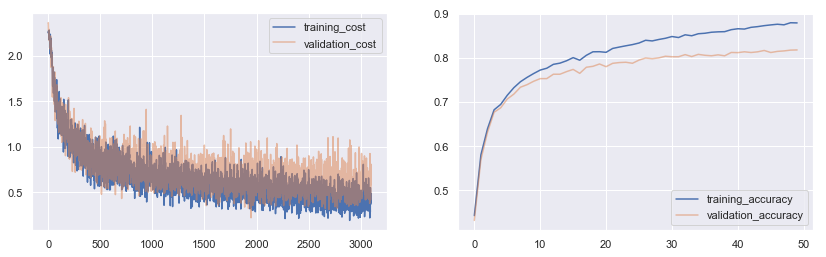

<Figure size 1008x288 with 0 Axes>

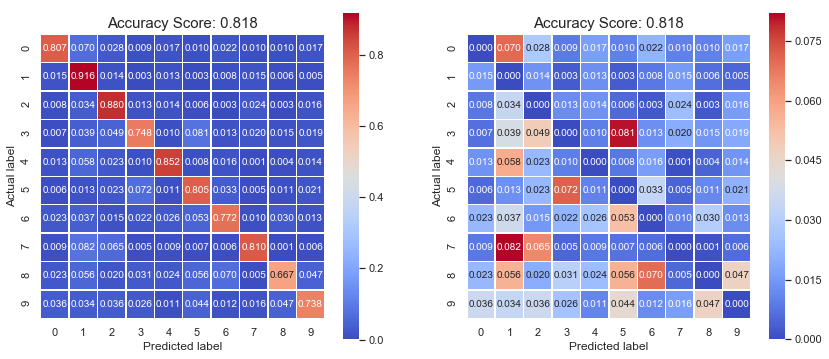

In [19]:
task_5_SVHN_aug_adam.train_nn(X_train=X_train_aug_sc, y_train=y_train_aug, epochs=75, batch_size=64, cval=0.1,
                             early_stopping=('hard', {'epochs': 5}))

In [22]:
print('accuracy on the training set: ',(task_5_SVHN_aug_adam.predict(X_train_aug_sc) == y_train_aug).mean())
print('')
print('accuracy on the "main" Test set: ',(task_5_SVHN_aug_adam.predict(X_main_test_sc) == y_main_test).mean())

accuracy on the training set:  0.8730490967830004

accuracy on the "main" Test set:  0.8615934234787953


From the improve in the results (86% accuracy) we can deduct that the augmentation worked quite well as regularizer. In fact the accuracy on the Test set is very similar to the training one. Maybe we could get better result by training the network longer.

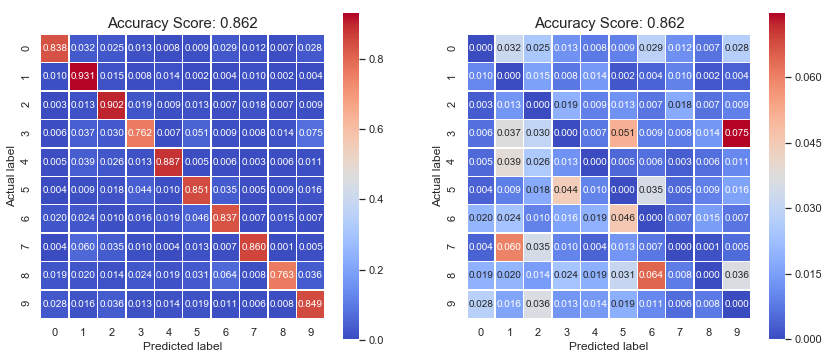

In [23]:
plot_conf_matrix(y_main_test, task_5_SVHN_aug_adam.predict(X_main_test_sc))

In [24]:
from sklearn.metrics import classification_report

print(classification_report(y_main_test,task_5_SVHN_aug_adam.predict(X_main_test_sc)))


              precision    recall  f1-score   support

           0       0.86      0.84      0.85      1744
           1       0.89      0.93      0.91      5099
           2       0.88      0.90      0.89      4149
           3       0.85      0.76      0.80      2882
           4       0.89      0.89      0.89      2523
           5       0.82      0.85      0.84      2384
           6       0.82      0.84      0.83      1977
           7       0.89      0.86      0.87      2019
           8       0.88      0.76      0.82      1660
           9       0.74      0.85      0.79      1595

   micro avg       0.86      0.86      0.86     26032
   macro avg       0.85      0.85      0.85     26032
weighted avg       0.86      0.86      0.86     26032



Let's reduce the size of network to see if we can get a similar results 

In [24]:
task_5_SVHN_aug_adam_v2 = vidigen_NN_task_5(size_h_layer=(X_train_aug_sc.shape[1], 256, 512, 256, len(np.unique(y_train_aug))), 
                          activation_h='ReLU', activation_o='softmax', initialization='he',
                          l_rate=0.00025, l_decay=0.95, bias= 1 , l2_reg= 0.000001, dropout=(1, (0,0.25,0.3,0.25)),
                          optimizer=('adam',{'beta1':0.9, 'beta2':0.999}),
                          plot_cost=False, print_=1, plots=1)

initial_cost:  3.8058  initial_acc:  0.0968
epoch_0  --> cost_train:  2.53 train_acc:  0.29  -- cost_val:  2.5755  val_acc:  0.2865  ==> grads:  0.0048
epoch_1  --> cost_train:  2.0777 train_acc:  0.5117  -- cost_val:  2.14  val_acc:  0.4996  ==> grads:  0.01017
epoch_2  --> cost_train:  1.8363 train_acc:  0.5893  -- cost_val:  1.8881  val_acc:  0.5789  ==> grads:  0.0124
epoch_3  --> cost_train:  1.6745 train_acc:  0.6339  -- cost_val:  1.7241  val_acc:  0.6204  ==> grads:  0.01459
epoch_4  --> cost_train:  1.5472 train_acc:  0.6694  -- cost_val:  1.6103  val_acc:  0.6543  ==> grads:  0.01373
epoch_5  --> cost_train:  1.4517 train_acc:  0.6934  -- cost_val:  1.5199  val_acc:  0.6797  ==> grads:  0.01738
epoch_6  --> cost_train:  1.3749 train_acc:  0.7143  -- cost_val:  1.4457  val_acc:  0.6937  ==> grads:  0.01849
epoch_7  --> cost_train:  1.3151 train_acc:  0.7251  -- cost_val:  1.3887  val_acc:  0.7049  ==> grads:  0.01678
epoch_8  --> cost_train:  1.2629 train_acc:  0.7381  -- cost

epoch_49  --> cost_train:  0.5077 train_acc:  0.8608  -- cost_val:  0.6716  val_acc:  0.801  ==> grads:  0.02015
training_cost_slope:  [-0.00563212]  --- val_cost_slope:  [-0.00340727]
epoch_50  --> cost_train:  0.503 train_acc:  0.8619  -- cost_val:  0.6672  val_acc:  0.8019  ==> grads:  0.01895
training_cost_slope:  [-0.00545515]  --- val_cost_slope:  [-0.00330727]
epoch_51  --> cost_train:  0.4974 train_acc:  0.8629  -- cost_val:  0.6646  val_acc:  0.8021  ==> grads:  0.01976
training_cost_slope:  [-0.00532848]  --- val_cost_slope:  [-0.00321879]
epoch_52  --> cost_train:  0.493 train_acc:  0.8625  -- cost_val:  0.6615  val_acc:  0.8031  ==> grads:  0.01885
training_cost_slope:  [-0.00513273]  --- val_cost_slope:  [-0.00321212]
epoch_53  --> cost_train:  0.4898 train_acc:  0.864  -- cost_val:  0.66  val_acc:  0.803  ==> grads:  0.02354
training_cost_slope:  [-0.00491212]  --- val_cost_slope:  [-0.00310727]
epoch_54  --> cost_train:  0.4856 train_acc:  0.8644  -- cost_val:  0.6569  v

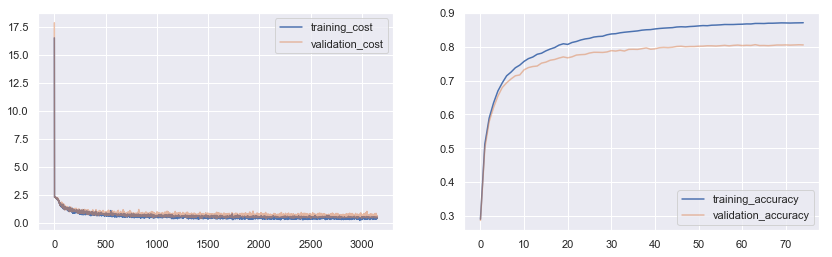

<Figure size 1008x288 with 0 Axes>

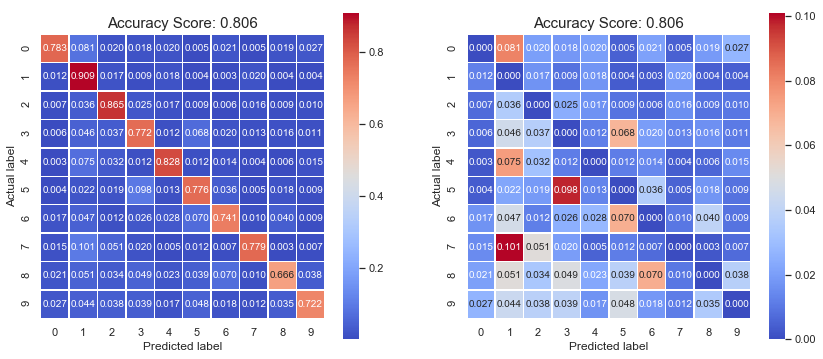

In [25]:
task_5_SVHN_aug_adam_v2.train_nn(X_train=X_train_aug_sc, y_train=y_train_aug, epochs=75, batch_size=128, cval=0.1,
                             early_stopping=('hard', {'epochs': 10}))

In [27]:
print('accuracy on the training set: ',(task_5_SVHN_aug_adam_v2.predict(X_train_aug_sc) == y_train_aug).mean())
print('')
print('accuracy on the "main" Test set: ',(task_5_SVHN_aug_adam_v2.predict(X_main_test_sc) == y_main_test).mean())

accuracy on the training set:  0.8647637768404385

accuracy on the "main" Test set:  0.8731561155500922


Actually the results have inproved furtherly to 87.35% accuracy... Definetly the augmentation worked quite well!

In [78]:
##saving the model
#import pickle

#model_ = task_5_SVHN_aug_adam_v2

#with open('SVHN_model_256_512_256_acc87.pickle', 'wb') as handle:
#    pickle.dump(model_, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [29]:
#saving the Augmented X
#import pickle

#aug_db = {'aug_X':Augmented_X, 'aug_y':Augmented_y, 'scaler':sc}

#with open('Augmented_db.pickle', 'wb') as handle:
#    pickle.dump(aug_db, handle, protocol=pickle.HIGHEST_PROTOCOL)

#### Load the best model

In [79]:
import pickle

df = loadmat('train_32x32.mat')
X = df['X'].reshape(3072,-1).T
y = df['y'].astype(int).copy()
y[y==10]=0

df_test = loadmat('test_32x32.mat')
X_main_test = df_test['X'].reshape(3072,-1).T
y_main_test = df_test['y'].astype(int).copy()
y_main_test[y_main_test==10]=0


model_load = open("SVHN_model_256_512_256_acc87.pickle","rb")
model_loaded = pickle.load(model_load)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

X_train_sc = sc.fit_transform(X.astype(float))
y_train = y
# scaling the test set
X_main_test_sc = sc.transform(X_main_test.astype(float))

#model performance
print('accuracy on the "main" Test set: ',(model_loaded.predict(X_main_test_sc) == y_main_test).mean())

accuracy on the "main" Test set:  0.873540258143823


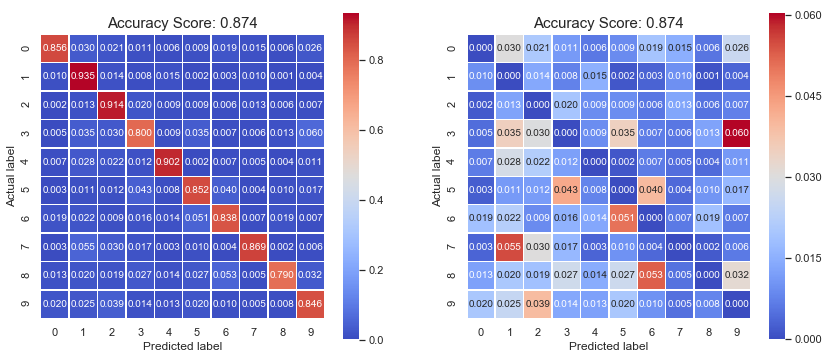

In [80]:
plot_conf_matrix(y_main_test, test_best.predict(X_main_test_sc))

In [81]:
from sklearn.metrics import classification_report

print(classification_report(y_main_test,model_loaded.predict(X_main_test_sc)))



              precision    recall  f1-score   support

           0       0.89      0.86      0.87      1744
           1       0.90      0.93      0.92      5099
           2       0.89      0.91      0.90      4149
           3       0.85      0.80      0.82      2882
           4       0.90      0.90      0.90      2523
           5       0.85      0.85      0.85      2384
           6       0.84      0.84      0.84      1977
           7       0.90      0.87      0.88      2019
           8       0.89      0.79      0.84      1660
           9       0.76      0.85      0.80      1595

   micro avg       0.87      0.87      0.87     26032
   macro avg       0.87      0.86      0.86     26032
weighted avg       0.87      0.87      0.87     26032



### K-means trick: colors compression

Here below I transformed the test data by collapsing the colors in the images in the test set (using MiniBatchKMeans) hoping that the best model trained above on the difficult augmented Training set would eventually perform better on a simplified Test set with the idea of "let's teach the model to solve a very difficult task and then let's present him with a very simple one!".


In [134]:
# warning takes 30min to run
from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(3)

new_test_data = np.zeros(X_main_test.shape)
for i in range(len(X_main_test)):
    kmeans.fit(X_main_test[i].reshape(-1,1))
    new_test_data[i] = kmeans.cluster_centers_[kmeans.predict(X_main_test[i].reshape(-1,1))].T

new_test_data.shape

(26032, 3072)

In [156]:
# load the new test data
import pickle
#new_test_data = new_test_data
#with open('new_test_data.pickle', 'wb') as handle:
#    pickle.dump(new_test_data, handle, protocol=pickle.HIGHEST_PROTOCOL)
new_test_data = open("new_test_data.pickle","rb")
new_test_data = pickle.load(new_test_data)

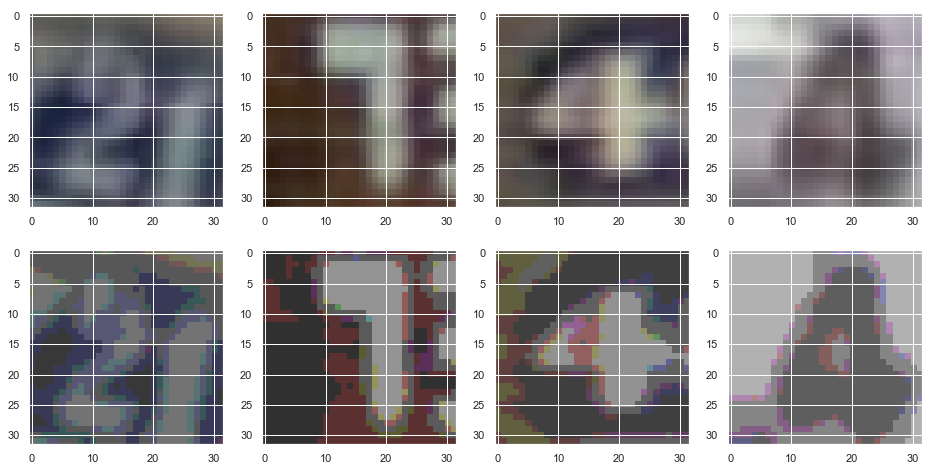

In [158]:
# here we plot some random data
rnd_choice = np.random.choice(X_main_test.shape[0],5)
plt.figure(figsize=(16,8))
plt.subplot(2,4,1)
plt.imshow(X_main_test[rnd_choice[0]].reshape(32,32,3))
plt.subplot(2,4,2)
plt.imshow(X_main_test[rnd_choice[1]].reshape(32,32,3))
plt.subplot(2,4,3)
plt.imshow(X_main_test[rnd_choice[2]].reshape(32,32,3))
plt.subplot(2,4,4)
plt.imshow(X_main_test[rnd_choice[3]].reshape(32,32,3))
plt.subplot(2,4,5)
plt.imshow(new_test_data[rnd_choice[0]].reshape(32,32,3)/255)
plt.subplot(2,4,6)
plt.imshow(new_test_data[rnd_choice[1]].reshape(32,32,3)/255)
plt.subplot(2,4,7)
plt.imshow(new_test_data[rnd_choice[2]].reshape(32,32,3)/255)
plt.subplot(2,4,8)
plt.imshow(new_test_data[rnd_choice[3]].reshape(32,32,3)/255)

From the example above, we can see that also to a human eye the modified (simpler) pictures on the 2nd line are actually clearer...

In [142]:
#scaling this new test data with the same scaler used before
X_new_test_sc = sc.transform(new_test_data.astype(float))

In [146]:
print('accuracy on the "main" Test set: ',(model_loaded.predict(X_new_test_sc) == y_main_test).mean())

accuracy on the "main" Test set:  0.8602489244007375


The results are ok (86% accuracy vs 87.4% on the actual Test set) but I was hoping better...

Different experiment by changing the shape of the network:

- 4 layers with a triangular shape (512, 256, 256, 128)
- reduce dropout and l2 reg
- batch size of 128

In [47]:
task_5_SVHN_aug_adamax_v2 = vidigen_NN_adamax(size_h_layer=(X_train_aug_sc.shape[1],512,256,256,128, len(np.unique(y_train_aug))), 
                          activation_h='ReLU', activation_o='softmax', initialization='he',
                          l_rate=0.0001, l_decay=0.95, bias= 1 , l2_reg= 1e-6, dropout=(1, (0,0.4,0.3,0.3,0.2)),
                          optimizer=('adamax',{'beta1':0.90, 'beta2':0.90}),
                          plot_cost=False, print_=1, plots=1)

initial_cost:  4.3847  initial_acc:  0.1036
epoch_0  --> cost_train:  2.2045 train_acc:  0.3031  -- cost_val:  2.2221  val_acc:  0.298  ==> grads:  0.01621
epoch_1  --> cost_train:  2.0255 train_acc:  0.4392  -- cost_val:  2.041  val_acc:  0.4342  ==> grads:  0.01662
epoch_2  --> cost_train:  1.8897 train_acc:  0.4903  -- cost_val:  1.9085  val_acc:  0.483  ==> grads:  0.02427
epoch_3  --> cost_train:  1.7849 train_acc:  0.5391  -- cost_val:  1.8139  val_acc:  0.5277  ==> grads:  0.02365
epoch_4  --> cost_train:  1.7049 train_acc:  0.5774  -- cost_val:  1.7365  val_acc:  0.5643  ==> grads:  0.02351
epoch_5  --> cost_train:  1.6341 train_acc:  0.6102  -- cost_val:  1.6774  val_acc:  0.5938  ==> grads:  0.02744
epoch_6  --> cost_train:  1.5783 train_acc:  0.6338  -- cost_val:  1.6255  val_acc:  0.616  ==> grads:  0.02323
training_cost_slope:  [-0.07736]  --- val_cost_slope:  [-0.07025]
epoch_7  --> cost_train:  1.5326 train_acc:  0.6534  -- cost_val:  1.5791  val_acc:  0.6362  ==> grads:

epoch_48  --> cost_train:  0.7581 train_acc:  0.8  -- cost_val:  0.8695  val_acc:  0.7542  ==> grads:  0.03147
training_cost_slope:  [-0.00602]  --- val_cost_slope:  [-0.00389]
epoch_49  --> cost_train:  0.754 train_acc:  0.8013  -- cost_val:  0.8659  val_acc:  0.7534  ==> grads:  0.02485
training_cost_slope:  [-0.00544]  --- val_cost_slope:  [-0.00379]
epoch_50  --> cost_train:  0.7474 train_acc:  0.8018  -- cost_val:  0.8615  val_acc:  0.7538  ==> grads:  0.02841
training_cost_slope:  [-0.00546]  --- val_cost_slope:  [-0.00385]
epoch_51  --> cost_train:  0.7432 train_acc:  0.8025  -- cost_val:  0.8562  val_acc:  0.7525  ==> grads:  0.03239
training_cost_slope:  [-0.00523]  --- val_cost_slope:  [-0.00424]
epoch_52  --> cost_train:  0.7396 train_acc:  0.8024  -- cost_val:  0.8529  val_acc:  0.7556  ==> grads:  0.02081
training_cost_slope:  [-0.00478]  --- val_cost_slope:  [-0.00429]
epoch_53  --> cost_train:  0.7361 train_acc:  0.804  -- cost_val:  0.8505  val_acc:  0.7548  ==> grads: 

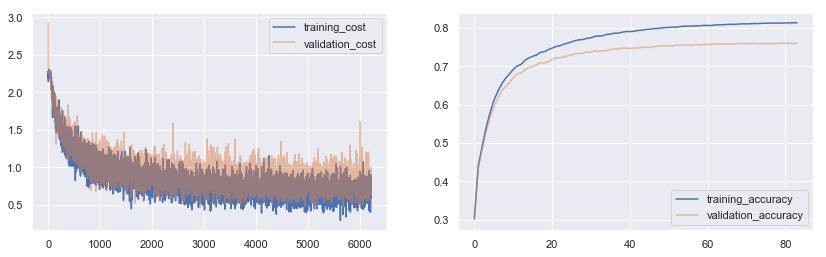

<Figure size 1008x288 with 0 Axes>

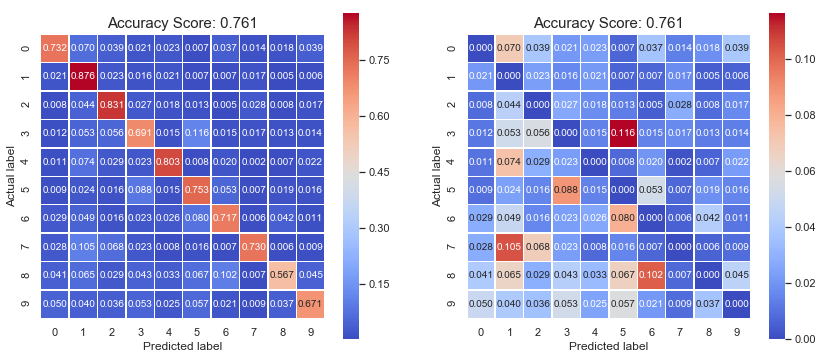

In [48]:
task_5_SVHN_aug_adamax_v2.train_nn(X_train=X_train_aug_sc, y_train=y_train_aug, epochs=100, batch_size=64, 
                                   cval=0.2, early_stopping=('hard', {'epochs': 5}))

In [49]:
print('accuracy on the "main" Test set: ',(task_5_SVHN_aug_adamax_v2.predict(X_main_test_sc) == y_main_test).mean())

accuracy on the "main" Test set:  0.8453057775046097


### Dimensionality Reduction for SVHN dataset

I now apply PCA to reduce the dimensionality of the SVHN dataset. Given the sparsity of the data it might work quite well and certainly it will train much faster.

In [82]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#we need the loadmat function to convert the MATLAB file downloaded into pandas dataframe
df = loadmat('train_32x32.mat')
X = df['X'].reshape(3072,-1).T
y = df['y'].astype(int).copy()
# for calculation reasons (it creates problem with the onehot encoding later) 

#we replace the target label 10 with 0
y[y==10]=0
y_train = y.copy()
unscaled_Xtrain = X.copy()

#scale the data
sc = StandardScaler()
X_train_sc = sc.fit_transform(X.astype(float))
print('Xtrain_shape: ',X_train_sc.shape, ' ytrain_shape: ',y_train.shape)

Xtrain_shape:  (73257, 3072)  ytrain_shape:  (73257, 1)


In [83]:
# main TEST set
df_test = loadmat('test_32x32.mat')
X_main_test = df_test['X'].reshape(3072,-1).T

#scale the test data
X_main_test_sc = sc.transform(X_main_test.astype(float))
y_main_test = df_test['y'].astype(int).copy()

y_main_test[y_main_test==10]=0

In [84]:
from sklearn.decomposition import PCA

# reduction to 99% of variance
pca = PCA(0.99).fit(X_train_sc)
X_tr_comp = pca.transform(X_train_sc)

X_main_test_comp = pca.transform(X_main_test_sc)

# create a denoised version of the datasets
Xtr_denoised = pca.inverse_transform(X_tr_comp)
Xtest_denoised = pca.inverse_transform(X_main_test_comp)

print('pca_components explaining 99% variance: ', len(pca.components_))

pca_components explaining 99% variance:  173


Let's now try a deeper network as we should be able to train it faster given the reduction in dimension to just 173! As as consequence, we need to increase a bit the regularization (L2) to avoid overfitting given that we increased the dimensionality of the parameters while we decreased the dataset one.

In [90]:
task_5_SVHN_pca = vidigen_NN_adamax(size_h_layer=(X_tr_comp.shape[1], 256, 512, 256, len(np.unique(y_train))), 
                          activation_h='ReLU', activation_o='softmax', initialization='he',
                          l_rate=0.0001, l_decay=0.98, bias= 1 , l2_reg= 0.00001, dropout=(1, (0,0.3,0.4,0.3)),
                          optimizer=('adamax',{'beta1':0.9, 'beta2':0.99}),
                          plot_cost=False, print_=1, plots=1)

initial_cost:  15.4593  initial_acc:  0.0885
epoch_0  --> cost_train:  2.3055 train_acc:  0.2259  -- cost_val:  2.3309  val_acc:  0.2196  ==> grads:  0.01006
epoch_1  --> cost_train:  2.1105 train_acc:  0.4681  -- cost_val:  2.1497  val_acc:  0.4629  ==> grads:  0.02384
epoch_2  --> cost_train:  1.8957 train_acc:  0.6278  -- cost_val:  1.9218  val_acc:  0.6167  ==> grads:  0.02642
epoch_3  --> cost_train:  1.7138 train_acc:  0.6892  -- cost_val:  1.7307  val_acc:  0.6767  ==> grads:  0.0222
epoch_4  --> cost_train:  1.5703 train_acc:  0.7231  -- cost_val:  1.59  val_acc:  0.7059  ==> grads:  0.02419
epoch_5  --> cost_train:  1.455 train_acc:  0.7477  -- cost_val:  1.4819  val_acc:  0.7307  ==> grads:  0.02161
epoch_6  --> cost_train:  1.3618 train_acc:  0.7684  -- cost_val:  1.3977  val_acc:  0.7496  ==> grads:  0.02973
training_cost_slope:  [-0.13266]  --- val_cost_slope:  [-0.1297]
epoch_7  --> cost_train:  1.2877 train_acc:  0.78  -- cost_val:  1.3259  val_acc:  0.7606  ==> grads:  

epoch_48  --> cost_train:  0.3643 train_acc:  0.9179  -- cost_val:  0.5135  val_acc:  0.8581  ==> grads:  0.02113
training_cost_slope:  [-0.00546]  --- val_cost_slope:  [-0.00353]
epoch_49  --> cost_train:  0.3604 train_acc:  0.9183  -- cost_val:  0.512  val_acc:  0.8595  ==> grads:  0.02092
training_cost_slope:  [-0.00505]  --- val_cost_slope:  [-0.0035]


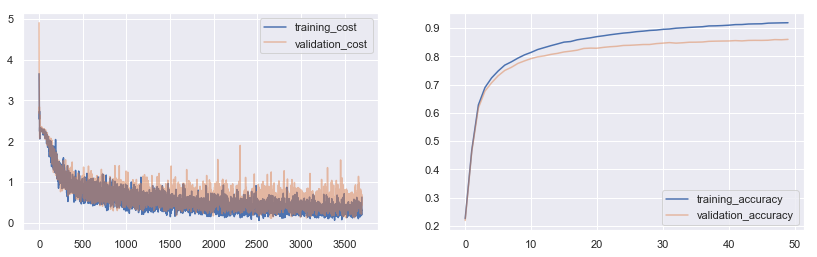

<Figure size 1008x288 with 0 Axes>

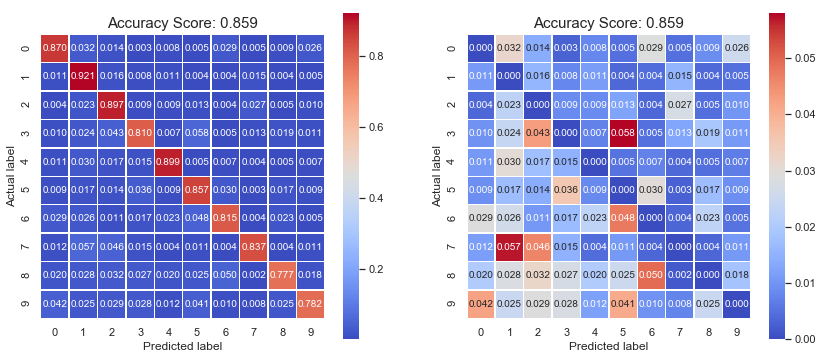

In [91]:
task_5_SVHN_pca.train_nn(X_train=X_tr_comp, y_train=y_train, epochs=50, batch_size=32, cval=0.2,
                             early_stopping=('hard', {'epochs': 5}))

In [93]:
print('accuracy on the training set: ',(task_5_SVHN_pca.predict(X_tr_comp) == y_train).mean())
print('')
print('accuracy on the "main" Test set: ',(task_5_SVHN_pca.predict(X_main_test_comp) == y_main_test).mean())

accuracy on the training set:  0.9064935774055721

accuracy on the "main" Test set:  0.8330900430239705


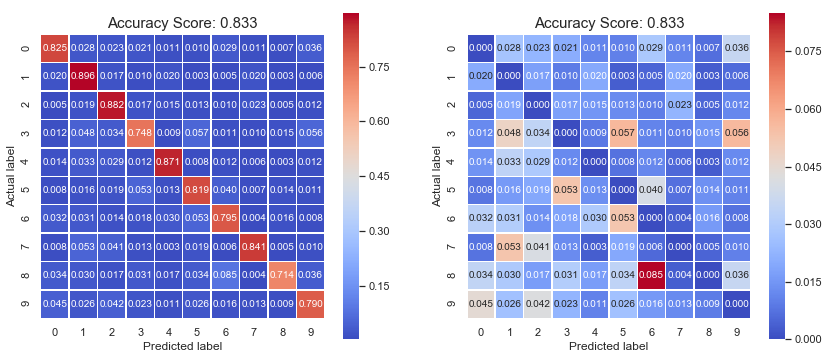

In [94]:
plot_conf_matrix(y_main_test, task_5_SVHN_pca.predict(X_main_test_comp))

The above results (83.5% accuracy) are quite good considering that I have trained the same network in a quarter of the time given the feature reduction to 173... the only class where it really does worse is the 6 vs 8 As we can see below:

In [96]:
print(classification_report(y_main_test,task_5_SVHN_pca.predict(X_main_test_comp)))


              precision    recall  f1-score   support

           0       0.77      0.82      0.80      1744
           1       0.88      0.90      0.89      5099
           2       0.87      0.88      0.88      4149
           3       0.82      0.75      0.78      2882
           4       0.86      0.87      0.87      2523
           5       0.79      0.82      0.81      2384
           6       0.78      0.80      0.79      1977
           7       0.85      0.84      0.84      2019
           8       0.86      0.71      0.78      1660
           9       0.73      0.79      0.76      1595

   micro avg       0.83      0.83      0.83     26032
   macro avg       0.82      0.82      0.82     26032
weighted avg       0.83      0.83      0.83     26032



The last attempt will be on the denoised version of the dataset:
    
this time will try with a single layer network of 800 neurons with 50% dropout

In [47]:
Xtr_denoised.shape

(73257, 3072)

In [52]:
task_5_SVHN_denoised = vidigen_NN_task_5(size_h_layer=(Xtr_denoised.shape[1], 800, len(np.unique(y_train))), 
                          activation_h='ReLU', activation_o='softmax', initialization='he',
                          l_rate=0.0005, l_decay=0.95, bias= 1 , l2_reg= 0.00001, dropout=(1, (0,0.5)),
                          optimizer=('adam',{'beta1':0.9, 'beta2':0.999}),
                          plot_cost=False, print_=1, plots=1)

initial_cost:  2.7173  initial_acc:  0.0969
epoch_0  --> cost_train:  1.6841 train_acc:  0.6777  -- cost_val:  1.8565  val_acc:  0.6691  ==> grads:  0.09484
epoch_1  --> cost_train:  1.2817 train_acc:  0.7471  -- cost_val:  1.4026  val_acc:  0.7332  ==> grads:  0.06169
epoch_2  --> cost_train:  1.1237 train_acc:  0.7654  -- cost_val:  1.2276  val_acc:  0.7554  ==> grads:  0.08327
epoch_3  --> cost_train:  1.0239 train_acc:  0.7757  -- cost_val:  1.1236  val_acc:  0.7642  ==> grads:  0.07177
epoch_4  --> cost_train:  0.9524 train_acc:  0.7983  -- cost_val:  1.0558  val_acc:  0.7872  ==> grads:  0.07262
epoch_5  --> cost_train:  0.9022 train_acc:  0.7842  -- cost_val:  1.0083  val_acc:  0.7707  ==> grads:  0.0731
epoch_6  --> cost_train:  0.8651 train_acc:  0.823  -- cost_val:  0.9592  val_acc:  0.8096  ==> grads:  0.08279
epoch_7  --> cost_train:  0.8277 train_acc:  0.8213  -- cost_val:  0.9173  val_acc:  0.8054  ==> grads:  0.0926
epoch_8  --> cost_train:  0.7994 train_acc:  0.8337  --

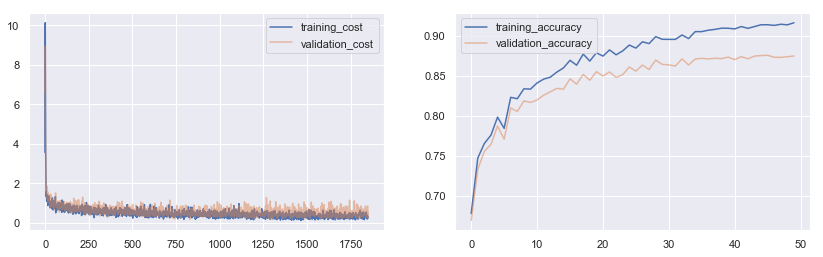

<Figure size 1008x288 with 0 Axes>

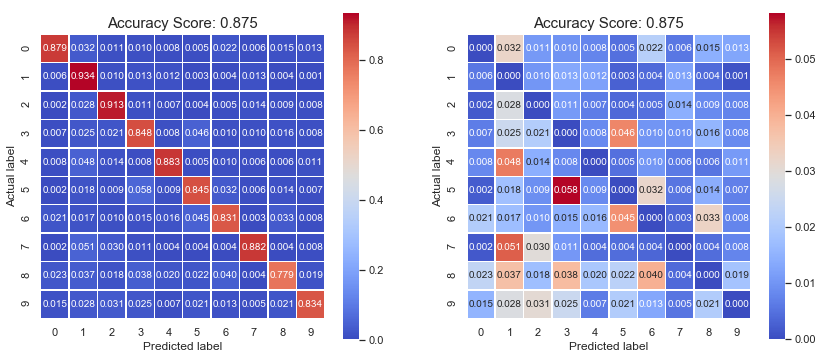

In [53]:
task_5_SVHN_denoised.train_nn(X_train=Xtr_denoised, y_train=y_train, epochs=50, batch_size=64, cval=0.2,
                             early_stopping=('hard', {'epochs': 20}))

In [55]:
print('accuracy on the training set: ',(task_5_SVHN_denoised.predict(Xtr_denoised) == ytrain).mean())
print('')
print('accuracy on the "main" Test set: ',(task_5_SVHN_denoised.predict(Xtest_denoised) == y_main_test).mean())

accuracy on the training set:  0.9079678392508566

accuracy on the "main" Test set:  0.855639213275968


That is pretty good with 85.5% accuracy! It seems that training the model on a denoising training dataset, the model manage to learn the main features 

In [59]:
from sklearn.metrics import classification_report,

print(classification_report(y_main_test,task_5_SVHN_denoised.predict(Xtest_denoised)))

              precision    recall  f1-score   support

           0       0.86      0.83      0.84      1744
           1       0.89      0.92      0.91      5099
           2       0.90      0.90      0.90      4149
           3       0.82      0.79      0.80      2882
           4       0.88      0.87      0.88      2523
           5       0.85      0.82      0.84      2384
           6       0.78      0.83      0.81      1977
           7       0.86      0.87      0.86      2019
           8       0.85      0.75      0.80      1660
           9       0.76      0.82      0.79      1595

   micro avg       0.86      0.86      0.86     26032
   macro avg       0.85      0.84      0.84     26032
weighted avg       0.86      0.86      0.86     26032



#### Summary of results on SVHN dataset
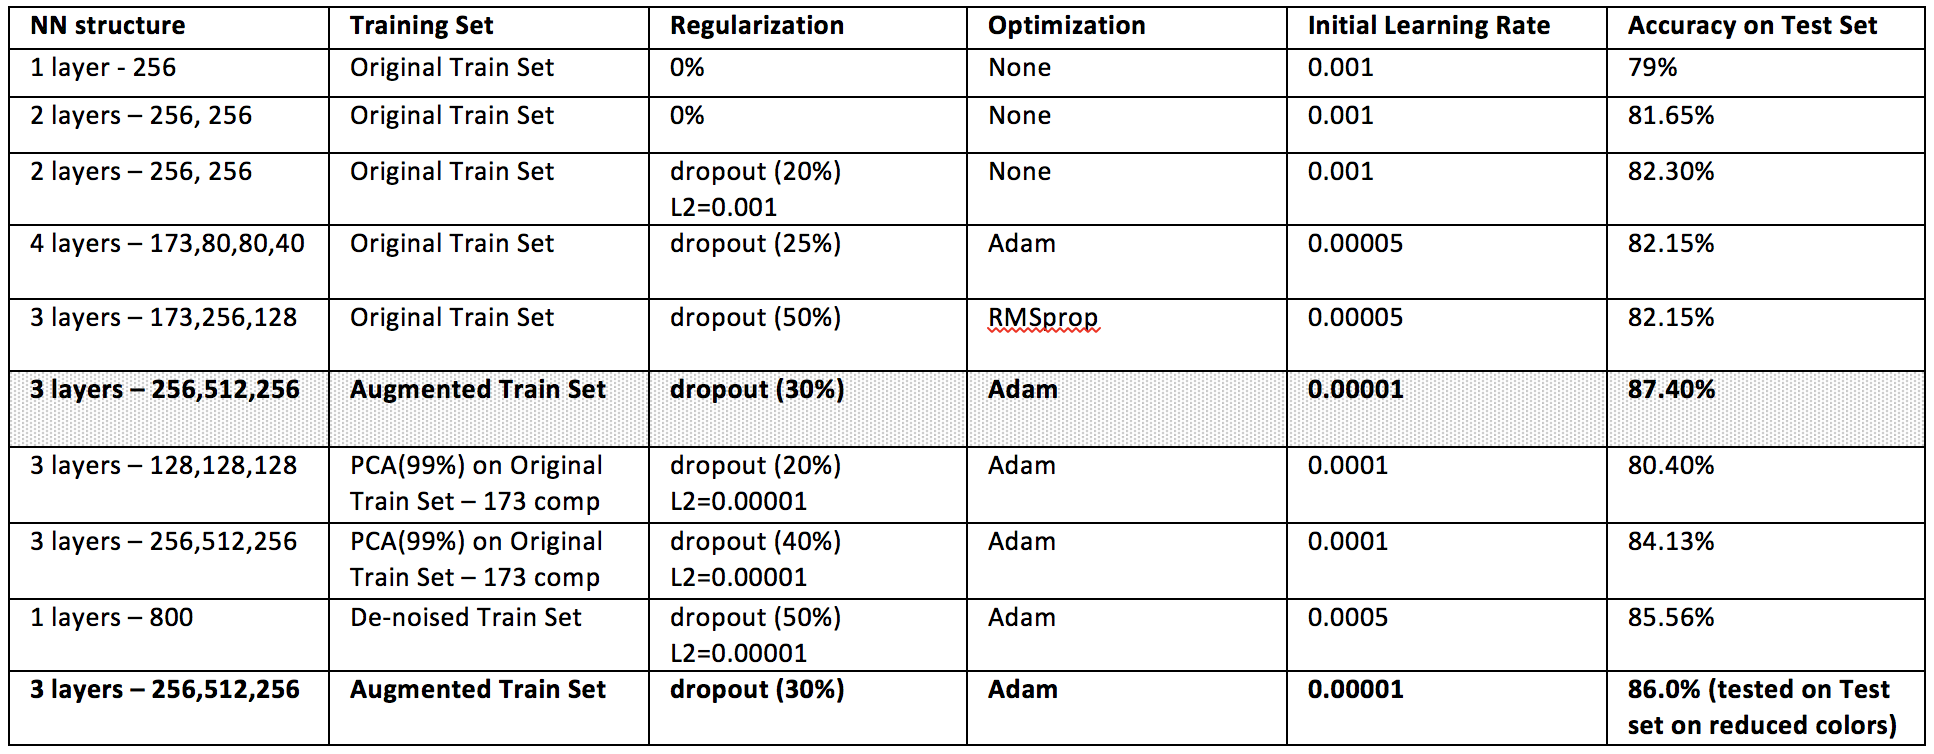

### Emotion dataset 

Let's now apply the NN on the emotion dataset.

The original dataset is available at this website: http://www.consortium.ri.cmu.edu/ckagree/

I use a cropped version of the images available at this website: http://www.dsp.utoronto.ca/projects/face_analysis/#dataset2

As reported in the website above: "The CK+ dataset, as a widely used dataset, was designed for promoting research into automatically recognizing action units and facial expressions. There are 593 sequences of images captured from videos across 123 subjects and 8 emotion labels in the dataset (neutral + 6 basic emotions + contempt). But only 327 sequences are labeled with one of 7 emotions and 5.5% of sequences with emotion labels are contempt. It is obvious that contempt is not as universal as others. So contempt is ignored in the reclassification"

So, we have the following emotions to classify: ["neutral", "anger", "disgust", "fear", "happy", "sadness", "surprise"] and the challenge is to create a FFNN as classifier. Obviously if we used a CNN, for this type of task, we would have got better results.

The code below creates the dataset from the pictures in the directory called "cohn-kanade - preprocessed images": the directory has been uploaded in the coursework submission 

In [4]:
import os
from scipy.misc import imread, imresize
from scipy import misc
import glob

path = "/Users/vincenzodigennaro/Documents/Jupyter_Python/My Python Notebooks/AI Master/Math and Programming/Vidigen_Coursework/cohn-kanade - preprocessed images/" 

def build_emotion_dataset(path):
    X = {'train':[], 'validation':[], 'test':[]}
    y = {'train':[], 'validation':[], 'test':[]}
    for data in ['train','validation','test']:
        for c in range(7):
            for image_path in glob.glob(path + str(data) + "/" +str(c) + "/*.png"):
                image = misc.imread(image_path)
                X[data].append(image)
                y[data].append(c)
    for k in X.keys():
        X[k] = np.array(X[k])
        y[k] = np.array(y[k]).reshape(-1,1)
    return X, y

In [24]:
X, y = build_emotion_dataset(path=path)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


In [5]:
labels_emotions = ["neutral", "anger", "disgust", "fear", "happy", "sadness", "surprise"]

Text(0.5, 1.0, 'disgust')

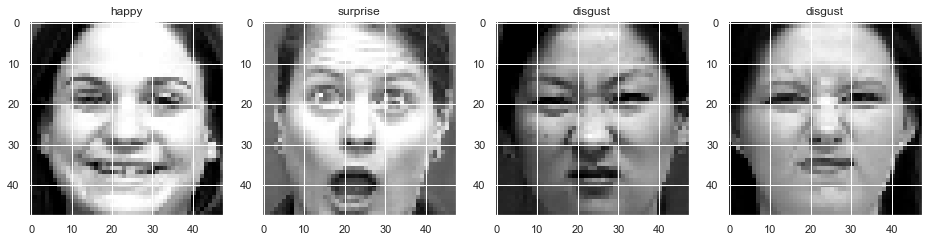

In [26]:
choice = np.random.choice(X['train'].shape[0],4)
plt.figure(figsize=(16,8))
plt.subplot(1,4,1)
plt.imshow(X['train'][choice[0]], cmap='gray')
plt.title(labels_emotions[np.int(y['train'][choice[0]])])
plt.subplot(1,4,2)
plt.imshow(X['train'][choice[1]], cmap='gray')
plt.title(labels_emotions[np.int(y['train'][choice[1]])])
plt.subplot(1,4,3)
plt.imshow(X['train'][choice[2]], cmap='gray')
plt.title(labels_emotions[np.int(y['train'][choice[2]])])
plt.subplot(1,4,4)
plt.imshow(X['train'][choice[3]], cmap='gray')
plt.title(labels_emotions[np.int(y['train'][choice[3]])])

In [27]:
print(X['train'].shape)
print(X['validation'].shape)
print(X['test'].shape)

(359, 48, 48)
(212, 48, 48)
(197, 48, 48)


Given that there are not many samples to train with in the emotion datset, I merge the training and validation dataset and most likely we will need some proper augmentation

In [1985]:
from keras.preprocessing.image import ImageDataGenerator

X, y = build_emotion_dataset(path=path)

X_train = X['train'].reshape(-1,48,48,1)
y_train = y['train']

X_val = X['validation'].reshape(-1,48,48,1)
y_val = y['validation']

#stacking the training data and validation data
X_train = np.vstack([X_train,X_val])
y_train = np.vstack([y_train,y_val])

X_test = X['test']
y_test = y['test']

# generating the augmented data
datagen_tr = ImageDataGenerator(rotation_range=25, width_shift_range=0.1, 
                             height_shift_range=0.1, shear_range=0.5, horizontal_flip=True)

# increase original data by a multiple of its original size
aug_times = 2

# here I create the sample generator
datagen_tr.fit(X_train)

it_train = datagen_tr.flow(X_train, y_train, batch_size=X_train.shape[0])
X_aug, y_aug = it_train.next()

for i in range(aug_times-1):
    add_X, add_y = it_train.next()
    X_aug = np.vstack([X_aug,add_X])
    y_aug = np.vstack([y_aug,add_y])

#scaling the data
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train.reshape(-1,2304).astype(float))#.reshape(-1,48,48,1)
X_test_sc = sc.transform(X_test.reshape(-1,2304).astype(float))#.reshape(-1,48,48,1)

    
X_train_aug_sc = np.vstack([X_train_sc, sc.transform(X_aug.reshape(-1,2304).astype(float))])
y_train_aug = np.vstack([y_train, y_aug])



print('X_train shape: ',X_train_sc.shape)
print('X_train_aug shape: ',X_train_aug_sc.shape)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


X_train shape:  (571, 2304)
X_train_aug shape:  (1713, 2304)


Here below are some samples generated:


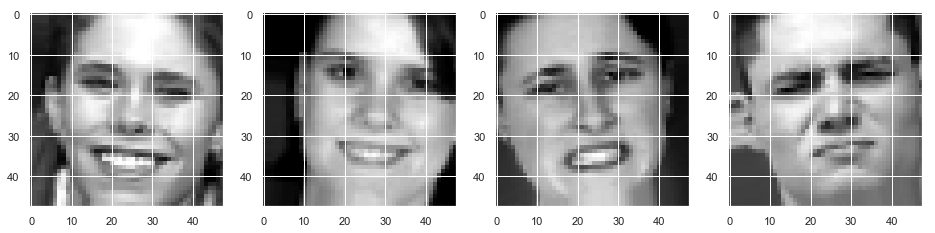

In [1986]:
choice = np.random.choice(X_aug.shape[0],4)
plt.figure(figsize=(16,8))
plt.subplot(1,4,1)
plt.imshow(X_aug[choice[0]].reshape(48,48), cmap='gray')
plt.subplot(1,4,2)
plt.imshow(X_aug[choice[1]].reshape(48,48), cmap='gray')
plt.subplot(1,4,3)
plt.imshow(X_aug[choice[2]].reshape(48,48), cmap='gray')
plt.subplot(1,4,4)
plt.imshow(X_aug[choice[3]].reshape(48,48), cmap='gray')

In [1987]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6])

Let's start training some network with 1 hidden layer and 128 neurons.

In [1948]:
task_5_emotion = vidigen_NN_task_5(size_h_layer=(X_train_sc.shape[1], 128, len(np.unique(y_train))), 
                          activation_h='ReLU', activation_o='softmax', initialization='he',
                          l_rate=0.0001, l_decay=0.95, bias= 1 , l2_reg= 0.01, dropout=(1, (0,0.5)),
                          optimizer=('adam',{'beta1':0.9, 'beta2':0.999}),
                          plot_cost=False, print_=1, plots=1)

initial_cost:  2.3141  initial_acc:  0.1323
epoch_0  --> cost_train:  0.86 train_acc:  0.8113  -- cost_val:  1.5304  val_acc:  0.7018  ==> grads:  0.01819
epoch_1  --> cost_train:  0.6176 train_acc:  0.8444  -- cost_val:  1.0981  val_acc:  0.8246  ==> grads:  0.06121
epoch_2  --> cost_train:  0.5334 train_acc:  0.9319  -- cost_val:  0.992  val_acc:  0.8421  ==> grads:  0.01721
epoch_3  --> cost_train:  0.4751 train_acc:  0.9514  -- cost_val:  0.8338  val_acc:  0.807  ==> grads:  0.00324
epoch_4  --> cost_train:  0.4339 train_acc:  0.963  -- cost_val:  0.7419  val_acc:  0.9298  ==> grads:  0.0163
epoch_5  --> cost_train:  0.3838 train_acc:  0.963  -- cost_val:  0.7107  val_acc:  0.9474  ==> grads:  0.03702
epoch_6  --> cost_train:  0.3541 train_acc:  0.9767  -- cost_val:  0.6518  val_acc:  0.8947  ==> grads:  0.02292
epoch_7  --> cost_train:  0.3297 train_acc:  0.9786  -- cost_val:  0.6089  val_acc:  0.9123  ==> grads:  0.0009
epoch_8  --> cost_train:  0.3032 train_acc:  0.9844  -- cost

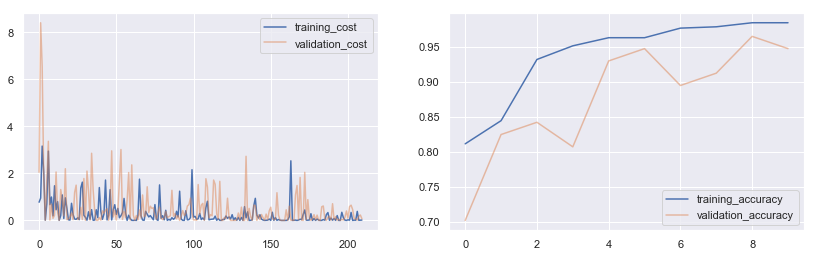

<Figure size 1008x288 with 0 Axes>

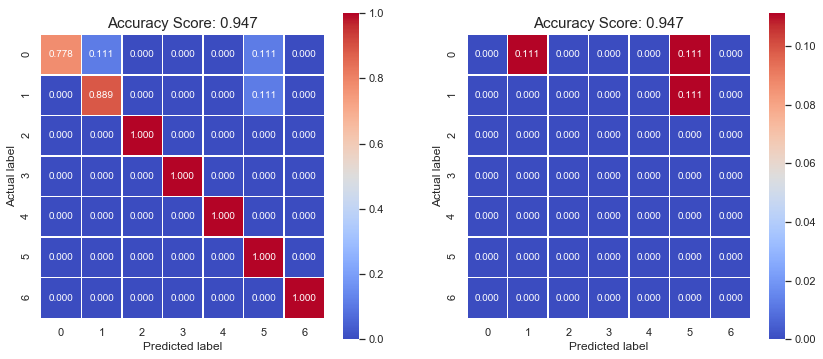

In [1949]:
task_5_emotion.train_nn(X_train=X_train_sc, y_train=y_train, batch_size=1, epochs=10, cval=0.1)

In [1950]:
print('accuracy on the training set: ',(task_5_emotion.predict(X_train_sc) == y_train).mean())

print('accuracy on the "main" Test set: ',(task_5_emotion.predict(X_test_sc) == y_test).mean())

accuracy on the training set:  0.9807355516637478
accuracy on the "main" Test set:  0.649746192893401


as we can see above model reaches quite quickly a 100% accuracy on the training set but fails to generalize on the test set (with 65%).

Let's now try to expand the network to 3 layers to see if it manage to abstruct/learn more features...

In [1988]:
task_5_emotion = vidigen_NN_task_5(size_h_layer=(X_train_aug_sc.shape[1], 128, 64,32, len(np.unique(y_train_aug))), 
                          activation_h='ReLU', activation_o='softmax', initialization='he',
                          l_rate=0.0001, l_decay=0.95, bias= 1 , l2_reg= 0.01, dropout=(1, (0,0.2,0.2, 0.2)),
                          optimizer=('adam',{'beta1':0.9, 'beta2':0.999}),
                          plot_cost=False, print_=1, plots=1)

initial_cost:  2.0623  initial_acc:  0.1316
epoch_0  --> cost_train:  1.8135 train_acc:  0.4501  -- cost_val:  1.6896  val_acc:  0.3275  ==> grads:  0.10605
epoch_1  --> cost_train:  1.6836 train_acc:  0.5409  -- cost_val:  1.6142  val_acc:  0.4211  ==> grads:  0.10209
epoch_2  --> cost_train:  1.5584 train_acc:  0.6025  -- cost_val:  1.5804  val_acc:  0.5322  ==> grads:  0.06365
epoch_3  --> cost_train:  1.4302 train_acc:  0.6407  -- cost_val:  1.5011  val_acc:  0.5731  ==> grads:  0.16397
epoch_4  --> cost_train:  1.3699 train_acc:  0.6751  -- cost_val:  1.4747  val_acc:  0.5322  ==> grads:  0.16761
epoch_5  --> cost_train:  1.2825 train_acc:  0.7088  -- cost_val:  1.413  val_acc:  0.5556  ==> grads:  0.17755
epoch_6  --> cost_train:  1.2356 train_acc:  0.7451  -- cost_val:  1.3345  val_acc:  0.5848  ==> grads:  0.17406
training_cost_slope:  [-0.07933]  --- val_cost_slope:  [-0.05799]
epoch_7  --> cost_train:  1.1852 train_acc:  0.7503  -- cost_val:  1.3144  val_acc:  0.6316  ==> gra

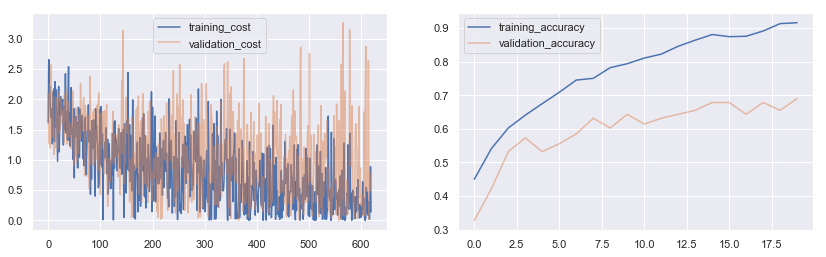

<Figure size 1008x288 with 0 Axes>

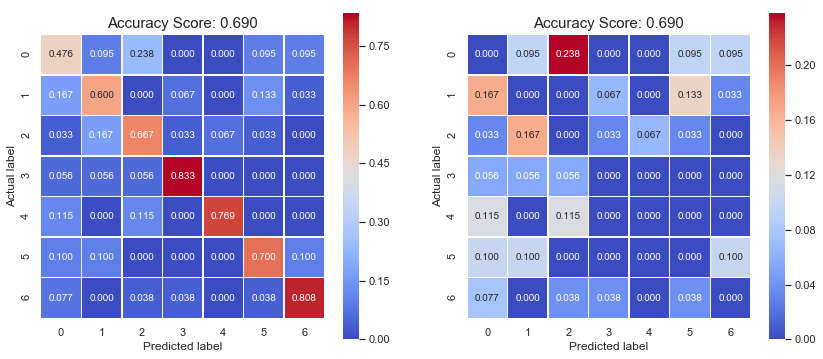

In [1989]:
task_5_emotion.train_nn(X_train=X_train_aug_sc, y_train=y_train_aug, batch_size=2, epochs=20, cval=0.1,
                       early_stopping=('hard', {'epochs': 5}))

In [1990]:
print('accuracy on the training set: ',(task_5_emotion.predict(X_train_aug_sc) == y_train_aug).mean())
#print('accuracy on the validation set: ',(task_5_emotion.predict(X_val_sc) == y_val).mean())
print('accuracy on the Test set: ',(task_5_emotion.predict(X_test_sc) == y_test).mean())

accuracy on the training set:  0.8931698774080561
accuracy on the Test set:  0.7055837563451777


A deeper network seems to be working better in generalizing on the test set with 70% accuracy

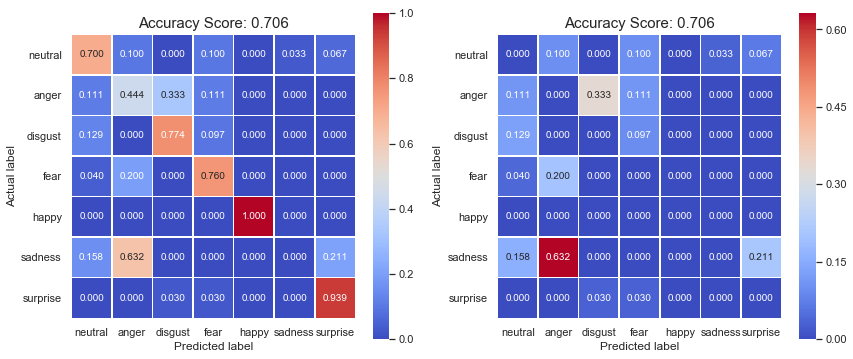

In [1991]:
plot_conf_matrix(y_test,task_5_emotion.predict(X_test_sc), normalized=True,labels=labels_emotions)

From the tabel below we can see that the model is quite bad in predicting anger and sadness as emotions... This might be understandable, using some heuristics, as the ways people express those 2 emotions are very different with each other while other emotions like happiness they are more standard in the way people express them...

In [1994]:
y_true = y_test
y_pred = (task_5_emotion.predict(X_test_sc))

labels = labels_emotions

cm = pd.DataFrame(confusion_matrix(y_true, y_pred), 
                  index=[['actual']*len(labels_emotions),labels_emotions], 
                  columns=[['predicted']*len(labels_emotions),labels_emotions])
print(cm)

                predicted                                          
                  neutral anger disgust fear happy sadness surprise
actual neutral         21     3       0    3     0       1        2
       anger            3    12       9    3     0       0        0
       disgust          4     0      24    3     0       0        0
       fear             1     5       0   19     0       0        0
       happy            0     0       0    0    32       0        0
       sadness          3    12       0    0     0       0        4
       surprise         0     0       1    1     0       0       31


In [1993]:
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.66      0.70      0.68        30
           1       0.38      0.44      0.41        27
           2       0.71      0.77      0.74        31
           3       0.66      0.76      0.70        25
           4       1.00      1.00      1.00        32
           5       0.00      0.00      0.00        19
           6       0.84      0.94      0.89        33

   micro avg       0.71      0.71      0.71       197
   macro avg       0.60      0.66      0.63       197
weighted avg       0.65      0.71      0.68       197



### "Online" training strategy 

Rather than normally training the network on the training set, I adopted the following strategy:

1)	I created 2 instances of the ImageDataGenerator: the 1st sampling from the training set and the 2nd sampling from the validation set (at least in this way the model trains on more faces).

2)	I set up a quite deep network (5 layers with 256 neurons on each layers) as I wanted a network which learns slowly but is robust to strange data coming in, heavy regularized with L2 and dropout (L2=0.6 and dropout of 60%).

3)	I set the patience (in minute): this is the maximum time I am willing to wait.

4)	I set the target accuracy for the training and validation set (I used 80% target).

5)	I start training the network feeding it with batches of 256 samples (on which I run 1 epoch with a mini batch of 2), taken randomly either (with 50% probability) from the original training set, or (with 50% prob) from the samples generated with ImageDataGenerator from the train and validation set. 

6)	I stop the training, when, the accuracy on both validation and training set is over the target or my patience, in minutes, has run out.

In this way I created an “online” training method which confuses and regularize the network by alternatively feeding it with either the original pictures (from training set) or with modified (twisted/flipped/sheared/shifted) pictures generated alternatively from the training and validation set.


In [1995]:
# reload the dataset
X, y = build_emotion_dataset(path=path)

X_train = X['train'].reshape(-1,48,48,1)
y_train = y['train']

X_val = X['validation'].reshape(-1,48,48,1)
y_val = y['validation']

X_test = X['test']

# set up the image generator
datagen_val = ImageDataGenerator(rotation_range=25, width_shift_range=0.1, 
                             height_shift_range=0.1, shear_range=5, horizontal_flip=True)

# here I created two instances for the image generator: 1 from the X train and 1 from the validation set
datagen_tr.fit(X_train)
datagen_val.fit(X_val)

# scale the data
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train.reshape(-1,2304).astype(float))
X_val_sc = sc.transform(X_val.reshape(-1,2304).astype(float))
X_test_sc = sc.transform(X_test.reshape(-1,2304).astype(float))

print('train_set: ', X_train_sc.shape)
print('val_set: ', X_val_sc.shape)
print('test_set: ', X_test_sc.shape)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


train_set:  (359, 2304)
val_set:  (212, 2304)
test_set:  (197, 2304)


In [1180]:
#task_5_emotion_sequential = vidigen_NN_task_5(size_h_layer=(X_train_sc.shape[1], 128,64,32, len(np.unique(y_train_aug))), 
#                          activation_h='ReLU', activation_o='softmax', initialization='truncnorm',
#                          l_rate=0.0001, l_decay=0.95, bias= 1 , l2_reg= 0.2, dropout=(1, (0,0.25,0.25,0.25)),
#                          optimizer=('adam',{'beta1':0.9, 'beta2':0.999}),
#                          plot_cost=False, print_=None, plots=None)

Deep Network set up

In [1996]:
task_5_emotion_sequential = vidigen_NN_task_5(size_h_layer=(X_train_sc.shape[1], 256,256,256,256,128, len(np.unique(y_train_aug))), 
                          activation_h='ReLU', activation_o='softmax', initialization='truncnorm',
                          l_rate=0.00001, l_decay=0.95, bias= 1 , l2_reg= 0.5, dropout=(1, (0,0.6,0.6,0.6,0.6,0.4)),
                          optimizer=('adam',{'beta1':0.9, 'beta2':0.999}),
                          plot_cost=False, print_=None, plots=None)

Online strategy run

In [1999]:
# accuracy target
val_acc_tgt = 0.80
patience = 60 # minutes
#samples feeded each time into the network
batch_chunk = 256

start_time = pd.datetime.now()
max_time = start_time + pd.Timedelta(str(patience)+' minute')

#samples generated from train set
it_train = datagen_tr.flow(X_train, y_train, batch_size=batch_chunk)
# samples generated from validation set
it_val = datagen_val.flow(X_val, y_val, batch_size=batch_chunk)

generator = {'0':it_train, '1':it_val }

counter = 0
val_acc = 0
while pd.datetime.now() < max_time :
    
    if counter % 100 == 0:
        print('accuracy on training: ', (task_5_emotion_sequential.predict(X_train_sc) == y_train).mean())
        print('accuracy on validation: ', (task_5_emotion_sequential.predict(X_val_sc) == y_val).mean())
    
    if pd.datetime.now() < max_time: 
        rnd_choice = np.int(np.random.choice(4,1))  
        if rnd_choice >= 2:
            choice = np.random.choice(X_train.shape[0],batch_chunk)
            X_, y_ = X_train_sc[choice], y_train[choice]
        else:
            X_, y_ = generator[str(rnd_choice)].next()
            X_ = X_.reshape(-1,2304)
            X_ = sc.transform(X_)
    
    task_5_emotion_sequential.train_nn(X_train=X_, y_train=y_, batch_size=2, epochs=1, cval=None,
                       early_stopping=(None, {'epochs': 100}))
    
    val_acc = (task_5_emotion_sequential.predict(X_val_sc) == y_val).mean()
    train_acc = (task_5_emotion_sequential.predict(X_train_sc) == y_train).mean()
    if val_acc > val_acc_tgt and train_acc > val_acc_tgt:
        print('validation_accuracy on target: ',val_acc)
        break
    counter += 1    
    

accuracy on training:  0.7855153203342619
accuracy on validation:  0.7169811320754716
accuracy on training:  0.8272980501392758
accuracy on validation:  0.7452830188679245
accuracy on training:  0.9303621169916435
accuracy on validation:  0.7216981132075472
accuracy on training:  0.9498607242339833
accuracy on validation:  0.7358490566037735


KeyboardInterrupt: 

In [2000]:
print('accuracy on training: ', (task_5_emotion_sequential.predict(X_train_sc) == y_train).mean())
print('accuracy on validation: ', (task_5_emotion_sequential.predict(X_val_sc) == y_val).mean())
print('accuracy on the "main" Test set: ',(task_5_emotion_sequential.predict(X_test_sc) == y_test).mean())

accuracy on training:  0.9637883008356546
accuracy on validation:  0.7216981132075472
accuracy on the "main" Test set:  0.7309644670050761


In [2001]:
y_true = y_test
y_pred = task_5_emotion_sequential.predict(X_test_sc)

labels = labels_emotions

cm = pd.DataFrame(confusion_matrix(y_true, y_pred), 
                  index=[['actual']*len(labels_emotions),labels_emotions], 
                  columns=[['predicted']*len(labels_emotions),labels_emotions])
print(cm)

                predicted                                          
                  neutral anger disgust fear happy sadness surprise
actual neutral         10     8       0    2     0       9        1
       anger            2    25       0    0     0       0        0
       disgust          1     0      30    0     0       0        0
       fear             0    10       0   15     0       0        0
       happy            0     0       0    0    32       0        0
       sadness          8     8       0    0     0       3        0
       surprise         0     0       2    1     0       1       29


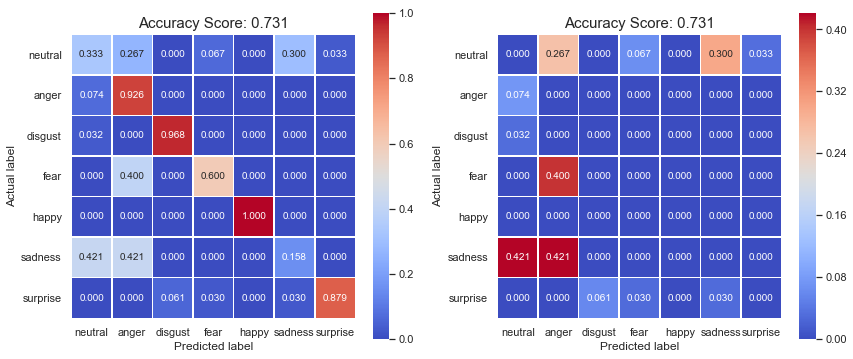

In [2002]:
plot_conf_matrix(y_true, y_pred, labels=labels_emotions)

In [2003]:
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.48      0.33      0.39        30
           1       0.49      0.93      0.64        27
           2       0.94      0.97      0.95        31
           3       0.83      0.60      0.70        25
           4       1.00      1.00      1.00        32
           5       0.23      0.16      0.19        19
           6       0.97      0.88      0.92        33

   micro avg       0.73      0.73      0.73       197
   macro avg       0.70      0.69      0.68       197
weighted avg       0.74      0.73      0.72       197



On several runs this DN “online” training strategy proved to perform better that running a normal NN (even with augmented data) reaching accuracy between 72% and 75%. Also, by running few times, I noticed that the longer and more gradually it trains (hence when both the accuracy on the train and val set grow slowly), the better the results. This might be due that this DN gradually learns to abstract features in a different way and generalize better on the test set.

#### Load best  FFNN for Emotions

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


accuracy on the Test set:  0.6954314720812182

              precision    recall  f1-score   support

           0       0.42      0.50      0.45        30
           1       0.49      0.70      0.58        27
           2       0.85      0.74      0.79        31
           3       0.79      0.60      0.68        25
           4       0.91      1.00      0.96        32
           5       0.60      0.16      0.25        19
           6       0.83      0.91      0.87        33

   micro avg       0.70      0.70      0.70       197
   macro avg       0.70      0.66      0.65       197
weighted avg       0.71      0.70      0.68       197



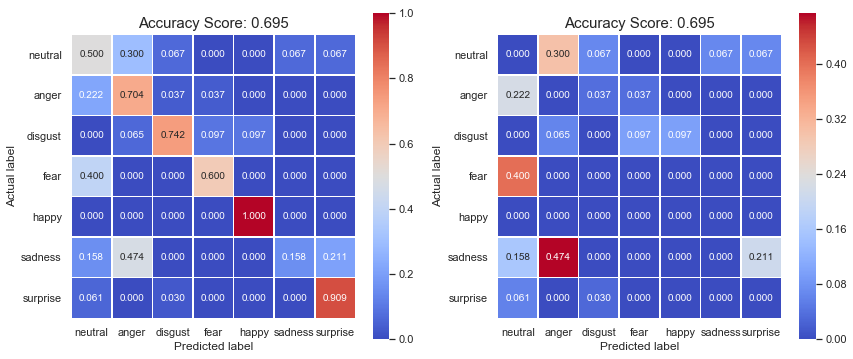

In [10]:
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import pickle

X, y = build_emotion_dataset(path=path)
labels_emotions = ["neutral", "anger", "disgust", "fear", "happy", "sadness", "surprise"]

X_train = X['train'].reshape(-1,48,48,1)
y_train = y['train']

X_val = X['validation'].reshape(-1,48,48,1)
y_val = y['validation']

#stacking the training data and validation data
X_train = np.vstack([X_train,X_val])
y_train = np.vstack([y_train,y_val])

X_test = X['test']
y_test = y['test']

sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train.reshape(-1,2304).astype(float))
X_test_sc = sc.transform(X_test.reshape(-1,2304).astype(float))

#load model
model_load = open("CK_model_512_256_acc_70pct.pickle","rb")
model_loaded = pickle.load(model_load)

print('accuracy on the Test set: ',(model_loaded.predict(X_test_sc) == y_test).mean())
print('')
print(classification_report(y_test, model_loaded.predict(X_test_sc)))
plot_conf_matrix(y_test, model_loaded.predict(X_test_sc), labels=labels_emotions)

## Task 6. Implementing your own deep NN

Processing and augmenting the data

In [37]:
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import StandardScaler

X, y = build_emotion_dataset(path=path)

X_train = X['train'].reshape(-1,48,48,1)
y_train = y['train']

X_val = X['validation'].reshape(-1,48,48,1)
y_val = y['validation']

#stacking the training data and validation data
X_train = np.vstack([X_train,X_val])
y_train = np.vstack([y_train,y_val])

X_test = X['test']
y_test = y['test']

# generating the augmented data
datagen_tr = ImageDataGenerator(rotation_range=15, width_shift_range=0.1, shear_range=0.1,
                             height_shift_range=0.1, horizontal_flip=True)


# increase original data by a multiple of its original size
aug_times = 4

# here I create the sample generator
datagen_tr.fit(X_train)

it_train = datagen_tr.flow(X_train, y_train, batch_size=X_train.shape[0])
X_aug, y_aug = it_train.next()

for i in range(aug_times-1):
    add_X, add_y = it_train.next()
    X_aug = np.vstack([X_aug,add_X])
    y_aug = np.vstack([y_aug,add_y])

#scaling the data
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train.reshape(-1,2304).astype(float)).reshape(-1,48,48,1)
X_test_sc = sc.transform(X_test.reshape(-1,2304).astype(float)).reshape(-1,48,48,1)
   
X_train_aug = np.vstack([X_train_sc, sc.transform(X_aug.reshape(-1,2304).astype(float)).reshape(-1,48,48,1)])

y_train_aug = np.vstack([y_train, y_aug])

print('X_train shape: ',X_train_sc.shape)
print('X_train_aug shape: ',X_train_aug.shape)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


X_train shape:  (571, 48, 48, 1)
X_train_aug shape:  (2855, 48, 48, 1)


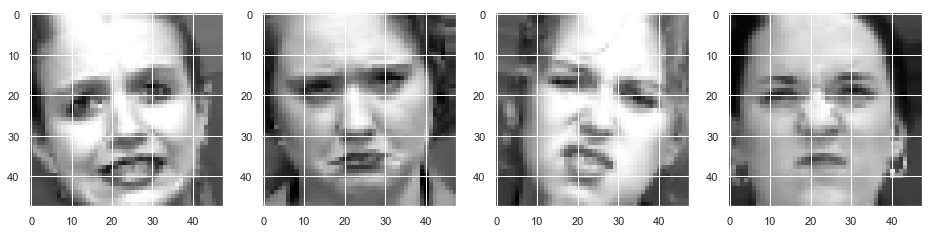

In [38]:
choice = np.random.choice(X_aug.shape[0],4)
plt.figure(figsize=(16,8))
plt.subplot(1,4,1)
plt.imshow(X_aug[choice[0]].reshape(48,48), cmap='gray')
plt.subplot(1,4,2)
plt.imshow(X_aug[choice[1]].reshape(48,48), cmap='gray')
plt.subplot(1,4,3)
plt.imshow(X_aug[choice[2]].reshape(48,48), cmap='gray')
plt.subplot(1,4,4)
plt.imshow(X_aug[choice[3]].reshape(48,48), cmap='gray')

Convolution Neural Network model

In [39]:

from keras.layers.normalization import BatchNormalization
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Activation, Flatten
from keras import optimizers

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1), 
                 padding = 'Same', input_shape=(48, 48, 1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


# fully connected layers
model.add(Flatten())

model.add(Dense(120, activation='relu',))
model.add(BatchNormalization())
model.add(Dropout(0.6))

model.add(Dense(30, activation='relu',))
model.add(Dropout(0.25))

#output layer
model.add(Dense(7, activation='softmax',))


opt = optimizers.adam(lr=0.001)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [40]:
#encoding labels for keras
y_train_enc = encode_labels(y_train, k=7).T
y_train_aug_enc = encode_labels(y_train_aug, k=7).T

# model training

model.fit(X_train_sc, y_train_enc, epochs=25, batch_size=16, validation_split=0.1)

Train on 513 samples, validate on 58 samples
Epoch 1/25
513/513 [==============================] - 2s 5ms/step - loss: 1.9803 - acc: 0.2865 - val_loss: 1.4768 - val_acc: 0.5000
Epoch 2/25
513/513 [==============================] - 1s 3ms/step - loss: 1.4912 - acc: 0.4444 - val_loss: 2.2898 - val_acc: 0.3448
Epoch 3/25
513/513 [==============================] - 1s 3ms/step - loss: 1.2050 - acc: 0.5731 - val_loss: 1.8086 - val_acc: 0.4310
Epoch 4/25
513/513 [==============================] - 1s 3ms/step - loss: 0.9785 - acc: 0.6608 - val_loss: 1.8300 - val_acc: 0.4310
Epoch 5/25
513/513 [==============================] - 1s 3ms/step - loss: 0.8696 - acc: 0.6959 - val_loss: 2.8378 - val_acc: 0.2241
Epoch 6/25
513/513 [==============================] - 1s 3ms/step - loss: 0.7547 - acc: 0.7368 - val_loss: 2.0384 - val_acc: 0.4483
Epoch 7/25
513/513 [==============================] - 1s 3ms/step - loss: 0.5993 - acc: 0.8187 - val_loss: 1.7230 - val_acc: 0.4828
Epoch 8/25
513/513 [===========

In [44]:
## load best model
#import pickle
#model_load = open("CK_cnn_model_acc84.pickle","rb")
#model_loaded = pickle.load(model_load)
#model = model_loaded

In [45]:
print('CNN_model accuracy on TEST set: ',(model.predict_classes(X_test_sc.reshape(-1,48,48,1))==y_test.T).mean())

CNN_model accuracy on TEST set:  0.8426395939086294


In [46]:
y_true = y_test
y_pred = model.predict_classes(X_test_sc.reshape(-1,48,48,1))

labels = labels_emotions

cm = pd.DataFrame(confusion_matrix(y_true, y_pred), 
                  index=[['actual']*len(labels_emotions),labels_emotions], 
                  columns=[['predicted']*len(labels_emotions),labels_emotions])

print(cm)

                predicted                                          
                  neutral anger disgust fear happy sadness surprise
actual neutral         21     4       1    0     0       3        1
       anger            8    17       0    0     0       2        0
       disgust          3     0      28    0     0       0        0
       fear             0     0       0   25     0       0        0
       happy            0     0       0    0    32       0        0
       sadness          1     5       0    0     0      11        2
       surprise         0     1       0    0     0       0       32


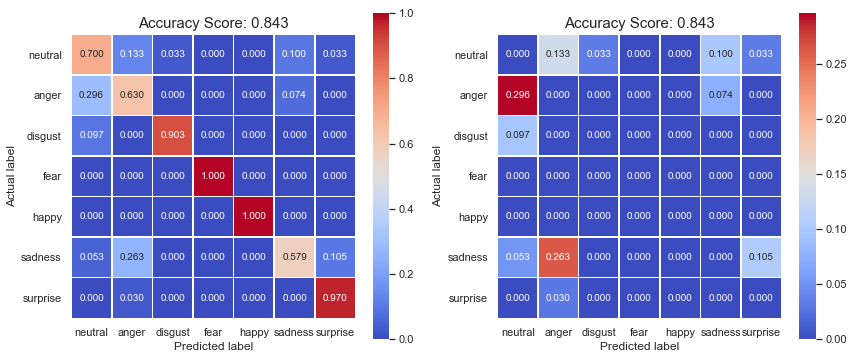

In [47]:
plot_conf_matrix(y_true, y_pred, labels=labels_emotions)

In [48]:
from sklearn.metrics import classification_report

print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.64      0.70      0.67        30
           1       0.63      0.63      0.63        27
           2       0.97      0.90      0.93        31
           3       1.00      1.00      1.00        25
           4       1.00      1.00      1.00        32
           5       0.69      0.58      0.63        19
           6       0.91      0.97      0.94        33

   micro avg       0.84      0.84      0.84       197
   macro avg       0.83      0.83      0.83       197
weighted avg       0.84      0.84      0.84       197



Below is the comparison of the three models used for the Emotion dataset

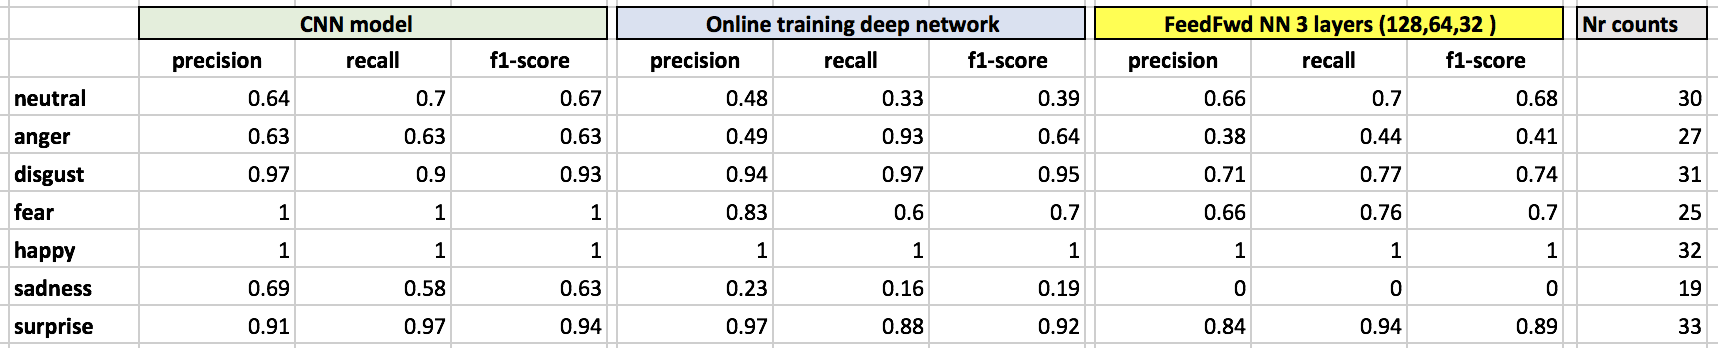

As we can see, for all models, the easiest classes to identify are fear, happiness and surprise. This, probably, was to be expected using some heuristics, as these emotions have quite peculiar positions for the mouth and eyes so the models recognize them quite easily. On the contrary, the problematic classes are anger and sadness: the FFNN does quite bad on “anger” with a f1-score of 41% vs 64% of the online DN and 52% of the CNN while it misclassifies entirely the “sadness” class vs 19% score of the DN and a 63% score of the CNN.  This, again using some heuristics, might be due to the fact that people express those two emotions in very different ways which translate in very different facial positions. Therefore, for a model to do well in peculiar classes like those two, it would need to train on way more samples with different people so that is able to find common features to recognize those two emotions. 


#### Summary of results on Cohn-Kanade datset
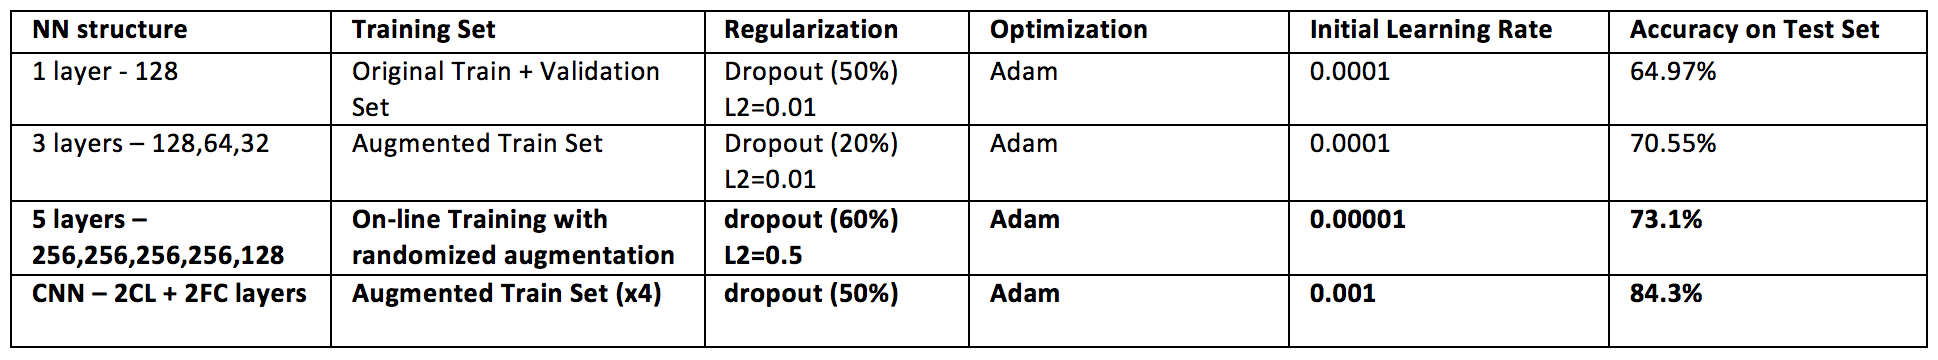

### Conclusions and general observations

•	I noticed that the deeper the network, the smaller should be the starting learning rate compared to a less deep network even keeping the same absolute number of neurons. I noticed, in fact, that the gradients go (or even start) to zero immediately not giving the change to the network to learn. Although, a higher learning rate could work if I increase the mini batch size.

•	The “normal” standardization (using the StandardScaler – (X – mean)/std) makes the network converging faster. A possible reason could be due to the sparsity of the feature set; hence the standard scaler concentrates the data more where the pixel intensity is higher while spreading further out the less relevant features. In contrast, standardizing the data dividing by 255 spreads the features more uniformly therefore the NN takes longer to identify the interesting features.

•	Adam and RMSprop optimizer don’t like a learning rate much bigger than 0.001: this might be due to the initialization phase of the v and s variables.   

•	L2 regularization, for this types of datasets, appears to be less effective than dropout. 

•	Noticed from several experiments, the deeper the layer, the bigger should be the dropout rate. Instead, the optimal l2 rate to apply looks like it’s less dependent from the depth of the network and size of the layers.

•	I didn’t notice much difference between “truncnorm” and “he” initialization.

•	In general, I noticed that networks with decreasing size of neurons in subsequent hidden layers seem to be working better than NN with flat structure. A possible reason is that the NN need to shoot the data into higher dimensions first to then recompose it into smaller dimension approaching to the output layer.

•	Regarding the augmentation of the dataset, I noticed that it works quite well as regularizer as, training the NN to a much noisier version of the testing data, makes the model being able to generalize better. In fact, I noticed from the results of several experiments that, after training, the accuracy on the main TEST data was much more in line with the accuracy of the training data and, interestingly, significantly higher than the accuracy on the validation set. Quite the opposite in the case of training on the “normal” (not augmented) training dataset, where the accuracy on the TEST data was far below the one on the training data and also below the validation set one. Also, training the NN on the augmented dataset, I could afford to use a lower dropout rate.



#### ... other model experiments on SVHN

(size_h_layer=(3072,128,64,32,10), activation_h='ReLU', activation_o='softmax',
 l_rate=0.001, bias= 1 , l2_reg= 0.0001, dropout=(1, (0,0.1,0.1,0.1)), epoch=100,
batch_size=5, cval=0.25, plot_cost=False)
score =  0.8283920283920284

vidigen_NN_v2(size_h_layer=(3072,64,128,32,10), activation_h='ReLU', activation_o='softmax',
                  l_rate=0.001, bias= 1 , l2_reg= 0.000, dropout=(1, (0,0.1,0.1,0.1)), epoch=200,
                  batch_size=5, cval=0.25, plot_cost=False)
epoch_199  ---- cost_train:  0.4416 train_acc:  0.8605  ---- cost_val:  0.5659  val_acc:  0.839
score =  0.833961233961234

vidigen_NN_v2(size_h_layer=(3072, 55, 25, 10), activation_h='ReLU', activation_o='softmax',
                  l_rate=0.001, bias= 1 , l2_reg= None, dropout=(None, (0, 0.2, 0.2, 0.2)), epoch=200,
                  batch_size= 2, cval=0.25, plot_cost=False)
epoch_199  ---- cost_train:  0.2419 train_acc:  0.9222  ---- cost_val:  1.075  val_acc:  0.7929
                
vidigen_NN_v2(size_h_layer=(3072, 50, 150, 25, 10), activation_h='ReLU', activation_o='softmax',
                  l_rate=0.001, bias= 1 , l2_reg= None, dropout=(None, (0, 0.2, 0.2, 0.2)), epoch=200,
                  batch_size= 2, cval=0.25, plot_cost=False)
epoch_71  ---- cost_train:  0.2511 train_acc:  0.9199  ---- cost_val:  1.047  val_acc:  0.7928
                
vidigen_NN_v2(size_h_layer=(3072, 800, 10), activation_h='ReLU', activation_o='softmax',
                  l_rate=0.001, bias= 1 , l2_reg= None, dropout=(None, (0, 0.2, 0.2, 0.2)), epoch=200,
                  batch_size= 32, cval=0.25, plot_cost=False)
epoch_65  ---- cost_train:  0.1827 train_acc:  0.9628  ---- cost_val:  0.6423  val_acc:  0.8259
score = 0.8178542178542179     

vidigen_NN_v2(size_h_layer=(3072, 800, 10), activation_h='ReLU', activation_o='softmax',
                  l_rate=0.001, bias= 1 , l2_reg= None, dropout=(1, (0, 0.5)), epoch=200,
                  batch_size= 32, cval=0.25, plot_cost=False)
epoch_100  ---- cost_train:  0.4324 train_acc:  0.8658  ---- cost_val:  0.5393  val_acc:  0.8545
epoch_199  ---- cost_train:  0.2745 train_acc:  0.9199  ---- cost_val:  0.5259  val_acc:  0.8608
score = 0.8574938574938575

vidigen_NN_v3_momentum(size_h_layer=(3072, 1024, 512,  10), activation_h='ReLU', activation_o='softmax',
                  l_rate=0.0001, bias= 1 , l2_reg= None, dropout=(1, (0, 0.5, 0.3)), epoch=200,
                  batch_size= 16, optimizer=('adam',{'beta1':0.9, 'beta2':0.999}), 
                  cval=0.25, plot_cost=False)
epoch_123  ---- cost_train:  0.3498 train_acc:  0.8863  ---- cost_val:  0.5803  val_acc:  0.8541
[-0.0002597]0.0%
epoch_124  ---- cost_train:  0.4038 train_acc:  0.8675  ---- cost_val:  0.5688  val_acc:  0.8534
[0.00019895]0.0%
score = 0.8496860496860497

vidigen_NN_v3_momentum(size_h_layer=(173, 1024,  10), activation_h='ReLU', activation_o='softmax',
                  l_rate=0.0001, bias= 1 , l2_reg= None, dropout=(1, (0, 0.5)), epoch=200,
                  batch_size= 32, optimizer=('RMSprop',{'beta1':0.9, 'beta2':0.999}),
                  early_stopping=('soft', {'epochs': 20}),
                  cval=0.25, plot_cost=False)
comment: trained on pca(0.99) components = 173
epoch_59  ---- cost_train:  0.2498 train_acc:  0.9248  ---- cost_val:  0.5694  val_acc:  0.8671
cost_slope:  [-0.00036241]
epoch_60  ---- cost_train:  0.2614 train_acc:  0.9231  ---- cost_val:  0.5701  val_acc:  0.866
cost_slope:  [0.00011842]
score = 0.865028665028665

task_5 = vidigen_NN_task_5(size_h_layer=(Xtrain.shape[1],516, 1024, 173, len(np.unique(ytrain))), 
                          activation_h='ReLU', activation_o='softmax',
                          l_rate=0.0001, l_decay=0.95, bias= 1 , l2_reg= None, dropout=(1, (0,0.3, 0.5, 0.2)),
                          optimizer=('adam',{'beta1':0.9, 'beta2':0.999}),
                          early_stopping=('soft', {'epochs': 20}),
                          cval=0.25, plot_cost=False, print_=1, plots=1)
epoch_199  ---- cost_train:  0.2065 train_acc:  0.945  ---- cost_val:  0.4572  val_acc:  0.866
training_cost_slope:  [-8.67361738e-19]  --- val_cost_slope:  -1
score = 0.8615


task_5 = vidigen_NN_task_5(size_h_layer=(Xtr_denoised.shape[1], 1024, len(np.unique(ytrain))), 
                          activation_h='ReLU', activation_o='softmax',
                          l_rate=0.0001, l_decay=0.95, bias= 1 , l2_reg= None, dropout=(1, (0,0.5)),
                          optimizer=('adam',{'beta1':0.9, 'beta2':0.95}),
                          early_stopping=('soft', {'epochs': 20}),
                          cval=0.25, plot_cost=False, print_=1, plots=1)
accuracy on the split test set:  0.8596232596232596
accuracy on the "main" test set:  0.836343284600789

task_5 = vidigen_NN_task_5(size_h_layer=(X_tr_comp.shape[1], 1024, len(np.unique(ytrain))), 
                          activation_h='ReLU', activation_o='softmax',
                          l_rate=0.001, l_decay=0.95, bias= 1 , l2_reg= 0.01, dropout=(1, (0,0.5)),
                          optimizer=('adam',{'beta1':0.9, 'beta2':0.999}),
                          early_stopping=('soft', {'epochs': 20}),
                          cval=0.25, plot_cost=False, print_=1, plots=1)
accuracy on the partial test set:  0.8750750750750751
accuracy on the "main" Test set:  0.8655828111989298
    